In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
import seaborn as sns
import math
import base64
from scipy.stats import chi2_contingency
import statsmodels.formula.api as sm

  # There was a conflict trying to import or install pingouin. Feel free to use that library on your Workspace. 

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)


In [ ]:
!pip install pingouin
import pingouin as pg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 KB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 63.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pingouin: filename=pingouin-0.5.3-py3-none-any.whl size=198588 sha256=9a0bb604f00d65b7b35cddd973e0f5ba4d3cc5e0bb830fe1c7c7f26426ab3db5
  Stored in directory: /root/.cache/pip/wheels/60/1e/21/710be95d0c93ea9ac3c0e6bacd8cce492ad5dd26bf3aedc4bf
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7047 sha256=89e19e4b4c832cf04d144d62b04db17fa969bba92118dd2cbccdd9fe5698ca82
  Stored in directory: /root/.cache/pip/wheels/6a/33/c4/0ef84d7f5568c2823e3d63a6e08988852fb9e4bc822034870a
Successfully built pingouin littleuti

#Median Income

In [ ]:
mi2010 = pd.read_csv('/content/drive/MyDrive/Team 33 Capstone Project/Data/Poverty/median_income_2010.csv').drop('Unnamed: 0', axis =1)
mi2015 = pd.read_csv('/content/drive/MyDrive/Team 33 Capstone Project/Data/Poverty/median_income_2015.csv').drop('Unnamed: 0', axis =1)
mi2019 = pd.read_csv('/content/drive/MyDrive/Team 33 Capstone Project/Data/Poverty/median_income_2019.csv').drop('Unnamed: 0', axis =1)

In [ ]:
mi2010['Year'] = pd.Series([2010 for x in range(len(mi2010.index))])
mi2015['Year'] = pd.Series([2015 for x in range(len(mi2015.index))])
mi2019['Year'] = pd.Series([2019 for x in range(len(mi2019.index))])

In [ ]:
#we want to merge the dataframes for median income on top of each other
mi = pd.concat([mi2010,mi2015,mi2019],axis = 0).reset_index().drop('index', axis =1)
mi = mi.rename(columns = {'Median Household Income':'median_income', 'Year':'year'})
mi = mi[['fips', 'state', 'county','year' ,'median_income',
       'percent_of_state_median_income', 'counties']]
#mi = mi[(mi.counties != 'mid-income counties')]
mi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   fips                            2106 non-null   int64  
 1   state                           2106 non-null   object 
 2   county                          2106 non-null   object 
 3   year                            2106 non-null   int64  
 4   median_income                   2106 non-null   int64  
 5   percent_of_state_median_income  2106 non-null   float64
 6   counties                        2106 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 115.3+ KB


#Poverty

In [ ]:
poverty2010 = pd.read_csv('/content/drive/MyDrive/Team 33 Capstone Project/Data/Poverty/poverty_rate_2010.csv').drop(columns = 'Unnamed: 0', axis = 1)
poverty2010['year'] = pd.Series([2010 for x in range(len(poverty2010.index))])
poverty2015 = pd.read_csv('/content/drive/MyDrive/Team 33 Capstone Project/Data/Poverty/poverty_rate_2015.csv').drop(columns = 'Unnamed: 0', axis = 1)
poverty2015['year'] = pd.Series([2015 for x in range(len(poverty2015.index))])
poverty2019 = pd.read_csv('/content/drive/MyDrive/Team 33 Capstone Project/Data/Poverty/poverty_rate_2019.csv').drop(columns = 'Unnamed: 0', axis = 1)
poverty2019['year'] = pd.Series([2019 for x in range(len(poverty2019.index))])
fipscode = pd.read_csv('/content/drive/MyDrive/Team 33 Capstone Project/Data/Poverty/FIPS_Codes.csv').drop(columns = 'Unnamed: 0')

In [ ]:
#we are using this function to add the fips code to the poverty datasets
def add_fips(df):
  fipscode
  fipscode1 = fipscode.rename(columns = {'Area name':'Name','State':'Postal Code'})
  fipscode1['Name'] = fipscode1['Name'].str.replace("County","").str.strip()
  fipscode2 = fipscode1[['FIPS Code','Postal Code','Name']].copy()
  df_0 = pd.merge(fipscode2,df, on =['Postal Code','Name'], how = 'inner').drop(columns = ['State FIPS Code','County FIPS Code'])

  #now we are going to clean up the column names
  col_names = {
      'FIPS Code':'fips',
      'Postal Code':'state',
      'Name':'county',
      'Year': 'year',
      'Poverty Estimate, All Ages':'poverty_estimate_all_ages',
      'Poverty Percent, All Ages':'poverty_percent_all_ages',
      'Poverty Estimate Ages 18+':'poverty_estimate_ages_18+',
      'Poverty Percent Ages 18+':'poverty_percent_ages_18+',
  }
  df_0 = df_0.rename(columns = col_names)

  return df_0

In [ ]:
poverty_2010 = add_fips(poverty2010)
poverty_2015 = add_fips(poverty2015)
poverty_2019 = add_fips(poverty2019)

In [ ]:
poverty = pd.concat([poverty_2010,poverty_2015,poverty_2019], axis = 0).reset_index().drop('index', axis =1)
poverty

fips state     county  poverty_estimate_all_ages  \
0      6001    CA    Alameda                   200273.0   
1      6003    CA     Alpine                      196.0   
2      6005    CA     Amador                     4286.0   
3      6007    CA      Butte                    43392.0   
4      6009    CA  Calaveras                     4996.0   
...     ...   ...        ...                        ...   
2101  48499    TX       Wood                     6231.0   
2102  48501    TX     Yoakum                      916.0   
2103  48503    TX      Young                     2405.0   
2104  48505    TX     Zapata                     4243.0   
2105  48507    TX     Zavala                     3374.0   

      poverty_percent_all_ages  poverty_estimate_ages_18+  \
0                         13.5                   142551.0   
1                         16.9                      119.0   
2                         12.8                     3247.0   
3                         20.1                    32053.0   
4                         11.1                     3423.0   
...                        ...                        ...   
2101                      14.3                     4357.0   
2102                      10.6                      495.0   
2103                      13.6                     1547.0   
2104                      30.1                     2208.0   
2105                      29.6                     2028.0   

      poverty_percent_ages_18+  year  
0                    71.200000  2010  
1                    60.700000  2010  
2                    75.800000  2010  
3                    73.900000  2010  
4                    68.500000  2010  
...                        ...   ...  
2101                 69.924571  2019  
2102                 54.039301  2019  
2103                 64.324324  2019  
2104                 52.038652  2019  
2105                 60.106698  2019  

[2106 rows x 8 columns]

In [ ]:
poverty = poverty[['fips', 'state', 'county', 'year','poverty_estimate_all_ages',
       'poverty_percent_all_ages', 'poverty_estimate_ages_18+',
       'poverty_percent_ages_18+']]

In [ ]:
poverty['Total Population'] = (poverty['poverty_estimate_all_ages'] * 100)/poverty['poverty_percent_all_ages']
poverty['poverty_percent_ages_18+'] = round((poverty['poverty_estimate_ages_18+']/poverty['Total Population']) * 100, 2)
poverty.drop('Total Population', axis =1, inplace = True)

<ipython-input-12-c8249517a6bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poverty['Total Population'] = (poverty['poverty_estimate_all_ages'] * 100)/poverty['poverty_percent_all_ages']
<ipython-input-12-c8249517a6bb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poverty['poverty_percent_ages_18+'] = round((poverty['poverty_estimate_ages_18+']/poverty['Total Population']) * 100, 2)


#Unemployment

In [ ]:
unemploy2010 = pd.read_excel('/content/drive/MyDrive/Team 33 Capstone Project/Data/unemployment/Unemployment and median household income for the U.S., States, and counties, 2000-2021.xlsx', sheet_name = 'Unemployment Med HH Income')
unemploy2015 = pd.read_excel('/content/drive/MyDrive/Team 33 Capstone Project/Data/unemployment/Unemployment and median household income for the U.S., States, and counties, 2000-2021.xlsx', sheet_name = 'Unemployment Med HH Income')
unemploy2019 = pd.read_excel('/content/drive/MyDrive/Team 33 Capstone Project/Data/unemployment/Unemployment and median household income for the U.S., States, and counties, 2000-2021.xlsx', sheet_name = 'Unemployment Med HH Income')

In [ ]:
unemploy2010 = unemploy2010[['FIPS_code','State','Area_name','Civilian_labor_force_2010','Employed_2010','Unemployed_2010','Unemployment_rate_2010']].copy()
unemploy2015 = unemploy2015[['FIPS_code','State','Area_name','Civilian_labor_force_2015','Employed_2015','Unemployed_2015','Unemployment_rate_2015']].copy()
unemploy2019 = unemploy2019[['FIPS_code','State','Area_name','Civilian_labor_force_2019','Employed_2019','Unemployed_2019','Unemployment_rate_2019']].copy()

In [ ]:
unemploy2010.insert(1,'year',2010)
unemploy2015.insert(1,'year',2015)
unemploy2019.insert(1,'year',2019)

In [ ]:
def unemploy_states(df):
  #extract the states of interest
  df1 = df[df['State'].isin(['CA','FL','GA','IL','NY','TX'])].reset_index().drop(columns = 'index')
  #we clean up the area name/county so that the county name is consistent across all datasets
  #we use str replace to get rid of the "County, " and the rstrip will get rid of the remaining spaces and the state initials
  df1['Area_name'] =df1['Area_name'].str.replace('County, ','').str.rstrip(' CAGANYTXILFL')
  #rename columns
  df1.columns=['fips','year','state','county','labor_force','employed','unemployed','unemployment_rate']
  #remove the rows that are not counties but states
  #df2 = df1[df1.fips.isin([6000,12000,13000,17000,36000,48000]) == False].reset_index().drop(columns = 'index')
  
  return df1

In [ ]:
unemploy_2010 = unemploy_states(unemploy2010)
unemploy_2015 = unemploy_states(unemploy2015)
unemploy_2019 = unemploy_states(unemploy2019)

In [ ]:
unemployment = pd.concat([unemploy_2010,unemploy_2015,unemploy_2019], axis = 0)
unemployment.head()

fips  year state      county  labor_force    employed  unemployed  \
0  6000  2010    CA  California   18370536.0  16078454.0   2292082.0   
1  6001  2010    CA     Alameda     782680.0    695343.0     87337.0   
2  6003  2010    CA      Alpine        542.0       471.0        71.0   
3  6005  2010    CA      Amador      15523.0     13291.0      2232.0   
4  6007  2010    CA       Butte     102713.0     88098.0     14615.0   

   unemployment_rate  
0               12.5  
1               11.2  
2               13.1  
3               14.4  
4               14.2

#Demographics

In [ ]:
demographic = pd.read_csv('/content/drive/MyDrive/Team 33 Capstone Project/Data/Demographics/Demos (all counties)/demos_allcounties_final.csv').drop(columns = 'Unnamed: 0')
demographic['State'] = demographic['State'].str.replace('California', 'CA')
demographic['State'] = demographic['State'].str.replace('Florida', 'FL')
demographic['State'] = demographic['State'].str.replace('Georgia', 'GA')
demographic['State'] = demographic['State'].str.replace('Illinois', 'IL')
demographic['State'] = demographic['State'].str.replace('New York', 'NY')
demographic['State'] = demographic['State'].str.replace('Texas', 'TX')
demographic = demographic.rename(columns = {'FIPS Code': 'fips', 'State': 'state', 'County': 'county', 'Year': 'year', 'Total Pop': 'Total Population'})

In [ ]:
demographic.loc[demographic['county'] == 'Trinity']

fips   county state  year  Total Population  18 years and over  \
52     6105  Trinity    CA  2010             12853              11093   
675   48455  Trinity    TX  2010             14422              11356   
754    6105  Trinity    CA  2015             12926              11055   
1377  48455  Trinity    TX  2015             14310              11501   
1456   6105  Trinity    CA  2019             12417              10534   
2079  48455  Trinity    TX  2019             14394              11632   

      25 to 64 years  35 to 64 years  65 years and over  Median age (years)  \
52              7745            6480               2483                48.5   
675             6946            5854               3207                46.1   
754             7205            5996               3115                50.3   
1377            6910            5558               3684                47.7   
1456            6437            5413               3410                52.5   
2079            6758            5442               3833                48.6   

      White  Black or African American  American Indian and Alaska Native  \
52    11482                         54                                220   
675   11767                       1546                                  6   
754   11096                        151                                456   
1377  11428                       1474                                 79   
1456  10427                        127                                698   
2079  11457                       1454                                 18   

      Asian and Pacific Islander  Hispanic or Latino  
52                           205                 892  
675                          102                1001  
754                          268                 955  
1377                          29                1300  
1456                         238                 927  
2079                           5                1460

#Medicaid

In [ ]:
med_2010 = pd.read_csv('/content/drive/MyDrive/Team 33 Capstone Project/Data/Medicaid Enrollment/Medicaid_Enrollment_2010/medicaid2010.csv').drop(columns = ['Unnamed: 0','SSA State County Code'])
med_2015 = pd.read_csv('/content/drive/MyDrive/Team 33 Capstone Project/Data/Medicaid Enrollment/2015 Medicaid Enrollment/medicaid2015.csv').drop(columns = ['Unnamed: 0','SSA State County Code'])
med_2019 = pd.read_csv('/content/drive/MyDrive/Team 33 Capstone Project/Data/Medicaid Enrollment/2019 Medicaid Enrollment/medicaid2019.csv').drop(columns = ['Unnamed: 0','SSA State County Code'])

In [ ]:
med_2010.insert(1,'year',2010)
med_2015.insert(1,'year',2015)
med_2019.insert(1,'year',2019)

In [ ]:
name_change = {
    'FIPS State County Code': 'fips',
    'State':'state',
    'County':'county',
    'Enrollment':'enrollment',
}
med_2010 = med_2010.rename(columns= name_change)
med_2015 = med_2015.rename(columns= name_change)
med_2019 = med_2019.rename(columns= name_change)

In [ ]:
medicaid = pd.concat([med_2010,med_2015,med_2019], axis = 0).reset_index().drop('index', axis =1)
medicaid.iat[18,4] = 873712
medicaid.iat[721,4] = 1095584
medicaid.iat[1424,4] = 1274155
medicaid.drop(medicaid.index[[19,722,1425]], inplace = True)
medicaid = medicaid.reset_index().drop('index', axis =1)

#Education

In [ ]:
ed_2010 = pd.read_csv('/content/drive/MyDrive/Team 33 Capstone Project/Data/Education/2010_education_allcounties.csv').drop('Unnamed: 0', axis =1)
ed_2015 = pd.read_csv('/content/drive/MyDrive/Team 33 Capstone Project/Data/Education/2015_education_allcounties.csv').drop('Unnamed: 0', axis =1)
ed_2019 = pd.read_csv('/content/drive/MyDrive/Team 33 Capstone Project/Data/Education/2019_education_allcounties.csv').drop('Unnamed: 0', axis =1)
ed_2010['year'] = pd.Series([2010 for x in range(len(ed_2010.index))])
ed_2015['year'] = pd.Series([2015 for x in range(len(ed_2015.index))])
ed_2019['year'] = pd.Series([2019 for x in range(len(ed_2019.index))])

In [ ]:
education = pd.concat([ed_2010, ed_2015, ed_2019], axis = 0).reset_index().drop('index', axis =1).drop('Year', axis = 1)
education.head()

FIPS Code State  Area name  Less than a high school diploma  \
0       6001    CA    Alameda                         141244.0   
1       6003    CA     Alpine                             57.0   
2       6005    CA     Amador                           3677.0   
3       6007    CA      Butte                          19423.0   
4       6009    CA  Calaveras                           2571.0   

   Percent of adults with less than a high school diploma  \
0                                          13.999566        
1                                           7.994390        
2                                          12.677562        
3                                          13.913324        
4                                           7.611914        

   High school diploma only  \
0                  200677.0   
1                     185.0   
2                    8527.0   
3                   32002.0   
4                   10209.0   

   Percent of adults with a high school diploma only  \
0                                          19.890338   
1                                          25.946704   
2                                          29.399393   
3                                          22.924069   
4                                          30.225604   

   Some college or associate degree  \
0                          255344.0   
1                             243.0   
2                           11361.0   
3                           54693.0   
4                           14009.0   

   Percent of adults completing some college or associate degree  \
0                                          25.308722               
1                                          34.081346               
2                                          39.170459               
3                                          39.178367               
4                                          41.476196               

   Bachelor degree or higher  \
0                   411652.0   
1                      228.0   
2                     5439.0   
3                    33482.0   
4                     6987.0   

   Percent of adults with a bachelor degree or higher  year  
0                                          40.801374   2010  
1                                          31.977560   2010  
2                                          18.752586   2010  
3                                          23.984241   2010  
4                                          20.686286   2010

In [ ]:
education = education.rename(columns = {'Area name': 'County'})

In [ ]:
education = education[['FIPS Code', 'State', 'County','year', 'Less than a high school diploma',
       'Percent of adults with less than a high school diploma',
       'High school diploma only',
       'Percent of adults with a high school diploma only',
       'Some college or associate degree',
       'Percent of adults completing some college or associate degree',
       'Bachelor degree or higher',
       'Percent of adults with a bachelor degree or higher']]
education.sample(10)

FIPS Code State    County  year  Less than a high school diploma  \
402       36033    NY  Franklin  2010                           5974.0   
1000      17029    IL     Coles  2015                           3099.0   
1994      48285    TX    Lavaca  2019                           1916.0   
832       13011    GA     Banks  2015                           3118.0   
352       17137    IL    Morgan  2010                           3074.0   
964       13279    GA    Toombs  2015                           3060.0   
1905      48107    TX    Crosby  2019                            892.0   
1719      17063    IL    Grundy  2019                           2187.0   
1482      12043    FL    Glades  2019                           2974.0   
1926      48149    TX   Fayette  2019                           2010.0   

      Percent of adults with less than a high school diploma  \
402                                           16.663412        
1000                                           9.754702        
1994                                          13.805029        
832                                           24.861493        
352                                           12.635127        
964                                           17.586579        
1905                                          23.812066        
1719                                           6.444294        
1482                                          28.080446        
1926                                          10.883691        

      High school diploma only  \
402                    13930.0   
1000                   10241.0   
1994                    5649.0   
832                     4812.0   
352                     9473.0   
964                     6673.0   
1905                    1227.0   
1719                   10766.0   
1482                    3788.0   
1926                    7294.0   

      Percent of adults with a high school diploma only  \
402                                           38.855262   
1000                                          32.191910   
1994                                          40.701780   
832                                           38.622227   
352                                           38.937071   
964                                           38.346747   
1905                                          32.754939   
1719                                          31.723488   
1482                                          35.766217   
1926                                          39.495343   

      Some college or associate degree  \
402                             9707.0   
1000                           10490.0   
1994                            3835.0   
832                             2912.0   
352                             6795.0   
964                             5007.0   
1905                            1070.0   
1719                           12356.0   
1482                            2615.0   
1926                            5039.0   

      Percent of adults completing some college or associate degree  \
402                                           27.075953               
1000                                          32.912956               
1994                                          27.631674               
832                                           23.092585               
352                                           27.929631               
964                                           28.747974               
1905                                          28.563801               
1719                                          36.408640               
1482                                          24.690775               
1926                                          27.285034               

      Bachelor degree or higher  \
402                      6240.0   
1000                     8016.0   
1994                     2479.0   
832                      1697.0   
352                      4987.0   
964   

In [ ]:
education = education.rename(columns = {'FIPS Code': 'fips', 'State': 'state', 'County': 'county'})

# Food Access

In [ ]:
fa2010 = pd.read_excel('/content/drive/MyDrive/Team 33 Capstone Project/Data/Food Access Research Atlas/2010/FoodAccessResearchAtlasData2010.xlsx', sheet_name ='Food Access Research Atlas')
fa2015 = pd.read_excel('/content/drive/MyDrive/Team 33 Capstone Project/Data/Food Access Research Atlas/2015/FoodAccessResearchAtlasData2015.xlsx', sheet_name = 'Food Access Research Atlas' )
fa2019 = pd.read_excel('/content/drive/MyDrive/Team 33 Capstone Project/Data/Food Access Research Atlas/2019/FoodAccessResearchAtlasData2019.xlsx', sheet_name = 'Food Access Research Atlas')

### Cleaning original datasets

In [ ]:
#adding a year column to each dataset
fa2010.insert(1,'year',2010)
fa2015.insert(1,'year',2015)
fa2019.insert(1,'year',2019)

In [ ]:
fa2019 = fa2019.rename(columns = {'Pop2010':'POP2010'})
fa2019.head()

CensusTract  year    State          County  Urban  POP2010  OHU2010  \
0   1001020100  2019  Alabama  Autauga County      1     1912      693   
1   1001020200  2019  Alabama  Autauga County      1     2170      743   
2   1001020300  2019  Alabama  Autauga County      1     3373     1256   
3   1001020400  2019  Alabama  Autauga County      1     4386     1722   
4   1001020500  2019  Alabama  Autauga County      1    10766     4082   

   GroupQuartersFlag  NUMGQTRS  PCTGQTRS  LILATracts_1And10  \
0                  0       0.0  0.000000                  0   
1                  0     181.0  8.341014                  1   
2                  0       0.0  0.000000                  0   
3                  0       0.0  0.000000                  0   
4                  0     181.0  1.681219                  0   

   LILATracts_halfAnd10  LILATracts_1And20  LILATracts_Vehicle  HUNVFlag  \
0                     0                  0                   0         0   
1                     1                  1                   0         0   
2                     0                  0                   0         0   
3                     0                  0                   0         0   
4                     0                  0                   0         1   

   LowIncomeTracts  PovertyRate  MedianFamilyIncome  LA1and10  LAhalfand10  \
0                0    11.336453             81250.0         1            1   
1                1    17.876788             49000.0         1            1   
2                0    15.046030             62609.0         1            1   
3                0     2.845210             70607.0         1            1   
4                0    15.150891             96334.0         1            1   

   LA1and20  LATracts_half  LATracts1  LATracts10  LATracts20  \
0         1              1          1           0           0   
1         1              1          1           0           0   
2         1              1          1           0           0   
3         1              1          1           0           0   
4         1              1          1           0           0   

   LATractsVehicle_20    LAPOP1_10   LAPOP05_10    LAPOP1_20  LALOWI1_10  \
0                   0  1896.493338  1912.000004  1896.493338  460.998748   
1                   0  1260.991651  2169.999998  1260.991651  603.892737   
2                   0  1551.703935  2856.859242  1551.703935  478.260886   
3                   0  1363.466885  3651.061015  1363.466885  343.215663   
4                   1  2643.095161  7778.396188  2643.095161  586.413137   

   LALOWI05_10  LALOWI1_20    lapophalf  lapophalfshare   lalowihalf  \
0   466.972228  460.998748  1912.000004      100.000000   466.972228   
1   962.199453  603.892737  2169.999998      100.000000   962.199453   
2   971.112475  478.260886  2856.859242       84.697873   971.112475   
3   893.201509  343.215663  3651.061015       83.243525   893.201509   
4  1718.885310  586.413137  7778.396188       72.249639  1718.885310   

   lalowihalfshare   lakidshalf  lakidshalfshare  laseniorshalf  \
0        24.423234   507.000002        26.516736     221.000002   
1        44.340989   606.000004        27.926267     214.000001   
2        28.790764   771.040463        22.859190     357.634554   
3        20.364831   846.613783        19.302640     766.521491   
4        15.965868  2309.475651        21.451567     839.885471   

   laseniorshalfshare  lawhitehalf  lawhitehalfshare  lablackhalf  \
0           11.558578  1622.000008         84.832636   216.999999   
1            9.861751   888.000003         40.921659  1216.999994   
2           10.602863  2176.590247         64.529803   554.235596   
3           17.476550  3395.061920         77.406793   170.065452   
4            7.801277  6298.710335         58.505576  1000.678496   

   lablackhalfshare  laasianhalf  laasianhalfshare  lanhopihalf  \
0         11.349372    14.000000          0.732218     0.000000   
1         56.082949 

In [ ]:
fa2010.head()

CensusTract  year State   County  LILATracts_1And10  LILATracts_halfAnd10  \
0   1001020100  2010    AL  Autauga                  0                     0   
1   1001020200  2010    AL  Autauga                  0                     0   
2   1001020300  2010    AL  Autauga                  0                     0   
3   1001020400  2010    AL  Autauga                  0                     0   
4   1001020500  2010    AL  Autauga                  0                     0   

   LILATracts_1And20  LILATracts_Vehicle  Urban  Rural  LA1and10  LAhalfand10  \
0                  0                   0      1      0         1            1   
1                  0                   0      1      0         0            1   
2                  0                   0      1      0         1            1   
3                  0                   0      1      0         1            1   
4                  0                   0      1      0         1            1   

   LA1and20  LATracts_half  LATracts1  LATracts10  LATracts20  \
0         1              1          1           0           0   
1         0              1          0           0           0   
2         1              1          1           0           0   
3         1              1          1           0           0   
4         1              1          1           0           0   

   LATractsVehicle_20  HUNVFlag  GroupQuartersFlag  OHU2010  NUMGQTRS  \
0                   0         0                  0      693       0.0   
1                   0         0                  0      743     181.0   
2                   0         0                  0     1256       0.0   
3                   0         0                  0     1722       0.0   
4                   1         1                  0     4082     181.0   

   PCTGQTRS  LowIncomeTracts  POP2010 UATYP10    lapophalf  lapophalfshare  \
0  0.000000                0     1912       U  1732.225468        0.905976   
1  0.083410                0     2170       U  1410.374828        0.649942   
2  0.000000                0     3373       U  2764.604126        0.819628   
3  0.000000                0     4386       U  4272.112205        0.974034   
4  0.016812                0    10766       U  7798.993990        0.724410   

    lalowihalf  lalowihalfshare   lakidshalf  lakidshalfshare  laseniorshalf  \
0   306.546737         0.160328   466.426429         0.919973     198.828220   
1   484.905037         0.223459   448.163512         0.739544     139.305390   
2   773.419284         0.229297   744.891575         0.833212     346.203097   
3   874.067405         0.199286   980.143479         0.965659     892.805993   
4  1131.052984         0.105058  2314.376847         0.731934     843.200608   

   laseniorshalfshare  lahunvhalf  lahunvhalfshare       lapop1  lapop1share  \
0            0.899675   44.212100         0.063798  1357.480940     0.709980   
1            0.650960   86.423433         0.116317   483.429683     0.222779   
2            0.788618   54.188593         0.043144  1417.874893     0.420360   
3            0.987617   16.964191         0.009851  1909.275364     0.435311   
4            0.748846  177.089308         0.043383  2753.648392     0.255773   

      lalowi1  lalowi1share     lakids1  lakids1share  laseniors1  \
0  245.277225      0.128283  363.638381      0.717235  162.497246   
1  170.838823      0.078728  174.770469      0.288400   50.976822   
2  380.786290      0.112892  377.128132      0.421844  190.001480   
3  311.160977      0.070944  470.411544      0.463460  374.051202   
4  373.426978      0.034686  745.740558      0.235845  373.826962   

   laseniors1share    lahunv1  lahunv1share  lapop10  lapop10share  lalowi10  \
0         0.735282  31.579173      0.045569      0.0           0.0       0.0   
1         0.238209  34.398590      0.046297      0.0           0.0       0.0   
2         0.432805  19.156371      0.015252      0.0           0.0       0.0   
3         0.413773   3.926144      0.00

In [ ]:
#purpose of this function is three-fold:
#1. to extract the six states of interest - California, Florida, Georgia, Illinois, New York, Texas
#2. clean up and extract columns of interest
#3. begin to create FIPS code
def six_states(df):
  df.fillna(0)
  df['lapoptotal'] = df['lapophalf']
  df['lalipoptotal'] = df['lalowihalf']
  #now let's only call on the columns of interest
  df = df[['CensusTract','year','State','County','LILATracts_1And10','LILATracts_halfAnd10','LILATracts_1And20','LATracts_half','LATracts1','LATracts10','LATracts20','POP2010','lapoptotal','lalipoptotal']].copy()

  #we are going to rename the columns
  column_names = {
      'CensusTract':'census_tract',
      'County':'county',
      'LATracts_half':'low_access_tract_1/2 mile',
      'LATracts1':'low_access_tract_1_mile',
      'LATracts10':'low_access_tract_10_miles',
      'LATracts20':'low_access_tract_20_miles',
      'LILATracts_1And10':'low_income_low_access_1_and_10 miles',
      'LILATracts_1And20':'low_income_low_access_1_and_20_miles',
      'LILATracts_halfAnd10':'low_income_low_access_1/2_and_10_miles',
      'POP2010':'population',
      'State':'state',
      }
  #replace column names
  df.rename(columns = column_names, inplace = True)
  
  state_dict = {
      'California':'CA',
      'Florida':'FL',
      'Georgia':'GA',
      'Illinois':'IL',
      'New York':'NY',
      'Texas':'TX',
  }
  #we are replacing the state names with their initial for formatting consistency
  df['state'] = df['state'].replace(state_dict)

  #this line will removing the word "County" from any count names as well as the trailing and leading spaces
  df["county"] = df["county"].str.replace("County","").str.strip()

  #we want to change Census Tract to a string so we can combine it later
  df["fips"] = df["census_tract"].astype(str) 

  df = df.loc[(df["state"]== 'TX')|(df["state"]== 'GA')|(df["state"]== 'NY')|(df["state"]== 'FL')|(df["state"]== 'IL')|(df["state"]== 'CA')]  

  return df



In [ ]:
fa_2010 = six_states(fa2010)
fa_2015 = six_states(fa2015)
fa_2019 = six_states(fa2019)

In [ ]:
def county_index(df):
    #make data frame with just the rows for CA and extract FIPS code that is only four digits
    states_CA = (df[df["state"] == "CA"]).copy()
    states_CA.loc[:,["fips"]]= [x[:4] for x in states_CA['fips']]
    #extract the FIPS for the remaining five states and these FIPS codes are five digits
    states_5= df[(df["state"] == "TX")|(df["state"] == "GA")|(df["state"] == "FL")|(df["state"] == "IL")|(df["state"] == "NY")].copy()
    states_5.loc[:,["fips"]]= [x[:5] for x in states_5['fips']]
    frame = [states_CA, states_5]
    county_in = pd.concat(frame)
    
    return county_in

In [ ]:
far2010 = county_index(fa_2010)
far2015 = county_index(fa_2015)
far2019 = county_index(fa_2019)

In [ ]:
def clean_up(df):
  #here we will join the following three columns(FIPS, State, and County) to create the "County Index"
  df["county_index"] = df[["fips","state","county"]].apply(" ".join, axis =1)
  #so for this next step we can determine if the area is low income AND low access by totaling the following columns
  #note that if the new column is >0 then the census tract is low income AND low access in some capacity
  #for now are scope does not include analyzing the metrics for determining to low access
  df['total_low_income_low_access'] = df['low_income_low_access_1_and_10 miles']+df['low_income_low_access_1/2_and_10_miles']+df['low_income_low_access_1_and_20_miles']
  #we take the sum of the different low access metrics to determine if the census tract is low access
  #if low access total is greater than 0 the it is low access
  df["total_low_access"] = df['low_access_tract_1/2 mile']+df['low_access_tract_1_mile']+df['low_access_tract_10_miles']+df['low_access_tract_20_miles']
  #we want to get a change the sums into yes(sum>0) or no(sum=0) for both total low access and total low income and low access
  df.loc[df['total_low_income_low_access'] > 0,'total_low_income_low_access']= 'Yes'
  df.loc[df['total_low_income_low_access'] == 0,'total_low_income_low_access']= 'No'
  df.loc[df['total_low_access'] > 0,'total_low_access']= 'Yes'
  df.loc[df['total_low_access'] == 0,'total_low_access']= 'No'

  return df

In [ ]:
far_2010 = clean_up(far2010)
far_2015 = clean_up(far2015)
far_2019 = clean_up(far2019)

In [ ]:
far_2010.head()

census_tract  year state   county  low_income_low_access_1_and_10 miles  \
3558    6001400100  2010    CA  Alameda                                     0   
3559    6001400200  2010    CA  Alameda                                     0   
3560    6001400300  2010    CA  Alameda                                     0   
3561    6001400400  2010    CA  Alameda                                     0   
3562    6001400500  2010    CA  Alameda                                     0   

      low_income_low_access_1/2_and_10_miles  \
3558                                       0   
3559                                       0   
3560                                       0   
3561                                       0   
3562                                       1   

      low_income_low_access_1_and_20_miles  low_access_tract_1/2 mile  \
3558                                     0                          1   
3559                                     0                          0   
3560                                     0                          0   
3561                                     0                          0   
3562                                     0                          1   

      low_access_tract_1_mile  low_access_tract_10_miles  \
3558                        1                          0   
3559                        0                          0   
3560                        0                          0   
3561                        0                          0   
3562                        0                          0   

      low_access_tract_20_miles  population   lapoptotal  lalipoptotal  fips  \
3558                          0        2937  2898.254926    147.005156  6001   
3559                          0        1974     0.000000      0.000000  6001   
3560                          0        4865   352.947122    104.273625  6001   
3561                          0        3703    79.819428     13.839095  6001   
3562                          0        3517  1012.963071    236.373440  6001   

         county_index total_low_income_low_access total_low_access  
3558  6001 CA Alameda                          No              Yes  
3559  6001 CA Alameda                          No               No  
3560  6001 CA Alameda                          No               No  
3561  6001 CA Alameda                          No               No  
3562  6001 CA Alameda                         Yes              Yes

### low access

In [ ]:
def perc_low_access(df):
  #this line of code gives us a total count of tracts within each county that are or are not low access
  df_1 = df.groupby(['fips','year','county_index','state','county'], dropna = False)['population'].sum().to_frame().reset_index().rename(columns = {'population':'county_population'})
  #df_2 takes the sum of tracts per each county
  df_2 = df.groupby(['fips','year','county_index','state','county','total_low_access'], dropna = False)['lapoptotal'].sum().to_frame().reset_index()
  #here we are only extracting the row with the "yes" count for each county
  df_3 = df_2[df_2['total_low_access']=='Yes'].rename(columns = {'lapoptotal':'yes_population'}).drop( columns = ['year','county_index','state','county','total_low_access'])
  #now we can merge
  df_4 = pd.merge(df_1, df_3, on = 'fips', how = 'inner')
  #we want the percentage of tracts within the county that are low access
  df_4['perc_low_access'] = round((df_4['yes_population']/df_4['county_population'])*100,1)
  #lets sort the data by fips, which will automatically organize by state
  #first we must turn 'fips' into an int data type
  df_4['fips'] = df_4['fips'].astype(int)
  #now we can sort by the fips value
  df_4 = df_4.sort_values('fips', ascending = True)

  return df_4

In [ ]:
la_far2010 = perc_low_access(far_2010)
la_far2010

fips  year       county_index state     county  county_population  \
644   6001  2010    6001 CA Alameda    CA    Alameda            1510271   
645   6003  2010     6003 CA Alpine    CA     Alpine               1175   
646   6005  2010     6005 CA Amador    CA     Amador              38091   
647   6007  2010      6007 CA Butte    CA      Butte             220000   
648   6009  2010  6009 CA Calaveras    CA  Calaveras              45578   
..     ...   ...                ...   ...        ...                ...   
639  48499  2010      48499 TX Wood    TX       Wood              41964   
640  48501  2010    48501 TX Yoakum    TX     Yoakum               7879   
641  48503  2010     48503 TX Young    TX      Young              18550   
642  48505  2010    48505 TX Zapata    TX     Zapata              14018   
643  48507  2010    48507 TX Zavala    TX     Zavala              11677   

     yes_population  perc_low_access  
644   748073.932953             49.5  
645     1174.999992            100.0  
646    33136.761407             87.0  
647   164427.958278             74.7  
648    40342.602426             88.5  
..              ...              ...  
639    39174.874095             93.4  
640     5129.342912             65.1  
641    16261.064026             87.7  
642    12112.423927             86.4  
643     8810.818984             75.5  

[702 rows x 8 columns]

In [ ]:
la_far2015 = perc_low_access(far_2015)
la_far2015

fips  year       county_index state     county  county_population  \
567   6001  2015    6001 CA Alameda    CA    Alameda            1510271   
568   6003  2015     6003 CA Alpine    CA     Alpine               1175   
569   6007  2015      6007 CA Butte    CA      Butte             220000   
570   6009  2015  6009 CA Calaveras    CA  Calaveras              45578   
571   6011  2015     6011 CA Colusa    CA     Colusa              21419   
..     ...   ...                ...   ...        ...                ...   
562  48499  2015      48499 TX Wood    TX       Wood              41964   
563  48501  2015    48501 TX Yoakum    TX     Yoakum               7879   
564  48503  2015     48503 TX Young    TX      Young              18550   
565  48505  2015    48505 TX Zapata    TX     Zapata              14018   
566  48507  2015    48507 TX Zavala    TX     Zavala              11677   

     yes_population  perc_low_access  
567   635431.319732             42.1  
568     1174.999992            100.0  
569   117241.101234             53.3  
570     9150.209004             20.1  
571     8254.878317             38.5  
..              ...              ...  
562    22447.648752             53.5  
563     4324.089371             54.9  
564    15567.737405             83.9  
565    12112.423927             86.4  
566     6598.292696             56.5  

[624 rows x 8 columns]

In [ ]:
la_far2019 = perc_low_access(far_2019)
la_far2019

fips  year       county_index state     county  county_population  \
572   6001  2019    6001 CA Alameda    CA    Alameda            1510271   
573   6003  2019     6003 CA Alpine    CA     Alpine               1175   
574   6007  2019      6007 CA Butte    CA      Butte             220000   
575   6009  2019  6009 CA Calaveras    CA  Calaveras              45578   
576   6011  2019     6011 CA Colusa    CA     Colusa              21419   
..     ...   ...                ...   ...        ...                ...   
567  48499  2019      48499 TX Wood    TX       Wood              41964   
568  48501  2019    48501 TX Yoakum    TX     Yoakum               7879   
569  48503  2019     48503 TX Young    TX      Young              18550   
570  48505  2019    48505 TX Zapata    TX     Zapata              14018   
571  48507  2019    48507 TX Zavala    TX     Zavala              11677   

     yes_population  perc_low_access  
572   632725.395997             41.9  
573     1174.999992            100.0  
574   111779.763201             50.8  
575     8426.450262             18.5  
576    13687.178313             63.9  
..              ...              ...  
567    22447.648752             53.5  
568     4540.989908             57.6  
569    15567.737405             83.9  
570     9704.231242             69.2  
571     6598.292696             56.5  

[628 rows x 8 columns]

In [ ]:
df2010 = la_far2010.drop( columns = ['county_population','yes_population']).rename(columns = {'perc_low_access':'low_access_percent'})
df2010

fips  year       county_index state     county  low_access_percent
644   6001  2010    6001 CA Alameda    CA    Alameda                49.5
645   6003  2010     6003 CA Alpine    CA     Alpine               100.0
646   6005  2010     6005 CA Amador    CA     Amador                87.0
647   6007  2010      6007 CA Butte    CA      Butte                74.7
648   6009  2010  6009 CA Calaveras    CA  Calaveras                88.5
..     ...   ...                ...   ...        ...                 ...
639  48499  2010      48499 TX Wood    TX       Wood                93.4
640  48501  2010    48501 TX Yoakum    TX     Yoakum                65.1
641  48503  2010     48503 TX Young    TX      Young                87.7
642  48505  2010    48505 TX Zapata    TX     Zapata                86.4
643  48507  2010    48507 TX Zavala    TX     Zavala                75.5

[702 rows x 6 columns]

In [ ]:
df32 = pd.merge(la_far2010, la_far2015, how = 'left', on = 'county_index', suffixes =('_2010', '_2015'))
df2015 = df32[['fips_2010','county_index','year_2015','state_2010','county_2010','county_population_2015','yes_population_2015','perc_low_access_2015']]
update_names = {
    'fips_2010':'fips',
    'year_2015':'year',
    'state_2010':'state',
    'county_2010':'county',
    'county_population_2015':'county_population',
    'yes_population_2015':'yes_population',
    'perc_low_access_2015':'low_access_percent'
}
df2015 = df2015.rename( columns = update_names)
df2015['year'] =  df2015['year'].fillna(2015.0).astype(int)
df2015 = df2015.drop( columns = ['county_population','yes_population'])
df2015 = df2015.fillna(0)
df2015

fips       county_index  year state     county  low_access_percent
0     6001    6001 CA Alameda  2015    CA    Alameda                42.1
1     6003     6003 CA Alpine  2015    CA     Alpine               100.0
2     6005     6005 CA Amador  2015    CA     Amador                 0.0
3     6007      6007 CA Butte  2015    CA      Butte                53.3
4     6009  6009 CA Calaveras  2015    CA  Calaveras                20.1
..     ...                ...   ...   ...        ...                 ...
697  48499      48499 TX Wood  2015    TX       Wood                53.5
698  48501    48501 TX Yoakum  2015    TX     Yoakum                54.9
699  48503     48503 TX Young  2015    TX      Young                83.9
700  48505    48505 TX Zapata  2015    TX     Zapata                86.4
701  48507    48507 TX Zavala  2015    TX     Zavala                56.5

[702 rows x 6 columns]

In [ ]:
df33 = pd.merge(la_far2010, la_far2019, how = 'left', on = 'county_index', suffixes = ('_2010','_2019'))
df2019 = df33[['fips_2010','county_index','year_2019','state_2010','county_2010','county_population_2019','yes_population_2019','perc_low_access_2019']]
update_names1 = {
    'fips_2010':'fips',
    'year_2019':'year',
    'state_2010':'state',
    'county_2010':'county',
    'county_population_2019':'county_population',
    'yes_population_2019':'yes_population',
    'perc_low_access_2019':'low_access_percent'
}
df2019 = df2019.rename( columns = update_names1)
df2019['year'] =  df2019['year'].fillna(2019.0).astype(int)
df2019 = df2019.drop( columns = ['county_population','yes_population'])
df2019 = df2019.fillna(0)
df2019

fips       county_index  year state     county  low_access_percent
0     6001    6001 CA Alameda  2019    CA    Alameda                41.9
1     6003     6003 CA Alpine  2019    CA     Alpine               100.0
2     6005     6005 CA Amador  2019    CA     Amador                 0.0
3     6007      6007 CA Butte  2019    CA      Butte                50.8
4     6009  6009 CA Calaveras  2019    CA  Calaveras                18.5
..     ...                ...   ...   ...        ...                 ...
697  48499      48499 TX Wood  2019    TX       Wood                53.5
698  48501    48501 TX Yoakum  2019    TX     Yoakum                57.6
699  48503     48503 TX Young  2019    TX      Young                83.9
700  48505    48505 TX Zapata  2019    TX     Zapata                69.2
701  48507    48507 TX Zavala  2019    TX     Zavala                56.5

[702 rows x 6 columns]

In [ ]:
food_low_access = pd.concat([df2010, df2015, df2019], axis = 0)
food_low_access

fips  year       county_index state     county  low_access_percent
644   6001  2010    6001 CA Alameda    CA    Alameda                49.5
645   6003  2010     6003 CA Alpine    CA     Alpine               100.0
646   6005  2010     6005 CA Amador    CA     Amador                87.0
647   6007  2010      6007 CA Butte    CA      Butte                74.7
648   6009  2010  6009 CA Calaveras    CA  Calaveras                88.5
..     ...   ...                ...   ...        ...                 ...
697  48499  2019      48499 TX Wood    TX       Wood                53.5
698  48501  2019    48501 TX Yoakum    TX     Yoakum                57.6
699  48503  2019     48503 TX Young    TX      Young                83.9
700  48505  2019    48505 TX Zapata    TX     Zapata                69.2
701  48507  2019    48507 TX Zavala    TX     Zavala                56.5

[2106 rows x 6 columns]

In [ ]:
food_low_access.query("county == 'Los Angeles'")

fips  year         county_index state       county  low_access_percent
662  6037  2010  6037 CA Los Angeles    CA  Los Angeles                39.3
18   6037  2015  6037 CA Los Angeles    CA  Los Angeles                37.0
18   6037  2019  6037 CA Los Angeles    CA  Los Angeles                36.1

### low income and low access

In [ ]:
far_2010 = clean_up(far2010)
far_2015 = clean_up(far2015)
far_2019 = clean_up(far2019)

In [ ]:
far_2010.head()

census_tract  year state   county  low_income_low_access_1_and_10 miles  \
3558    6001400100  2010    CA  Alameda                                     0   
3559    6001400200  2010    CA  Alameda                                     0   
3560    6001400300  2010    CA  Alameda                                     0   
3561    6001400400  2010    CA  Alameda                                     0   
3562    6001400500  2010    CA  Alameda                                     0   

      low_income_low_access_1/2_and_10_miles  \
3558                                       0   
3559                                       0   
3560                                       0   
3561                                       0   
3562                                       1   

      low_income_low_access_1_and_20_miles  low_access_tract_1/2 mile  \
3558                                     0                          1   
3559                                     0                          0   
3560                                     0                          0   
3561                                     0                          0   
3562                                     0                          1   

      low_access_tract_1_mile  low_access_tract_10_miles  \
3558                        1                          0   
3559                        0                          0   
3560                        0                          0   
3561                        0                          0   
3562                        0                          0   

      low_access_tract_20_miles  population   lapoptotal  lalipoptotal  fips  \
3558                          0        2937  2898.254926    147.005156  6001   
3559                          0        1974     0.000000      0.000000  6001   
3560                          0        4865   352.947122    104.273625  6001   
3561                          0        3703    79.819428     13.839095  6001   
3562                          0        3517  1012.963071    236.373440  6001   

         county_index total_low_income_low_access total_low_access  
3558  6001 CA Alameda                          No              Yes  
3559  6001 CA Alameda                          No               No  
3560  6001 CA Alameda                          No               No  
3561  6001 CA Alameda                          No               No  
3562  6001 CA Alameda                         Yes              Yes

#### code for 2010

In [ ]:
dfa = far_2010.groupby(['fips','year','county_index','state','county'])['population'].sum().to_frame().rename(columns = {'population':'low_access_population'}).reset_index()
dfa

fips  year       county_index state    county  low_access_population
0    12001  2010   12001 FL Alachua    FL   Alachua                 247336
1    12003  2010     12003 FL Baker    FL     Baker                  27115
2    12005  2010       12005 FL Bay    FL       Bay                 168852
3    12007  2010  12007 FL Bradford    FL  Bradford                  28520
4    12009  2010   12009 FL Brevard    FL   Brevard                 543376
..     ...   ...                ...   ...       ...                    ...
697   6107  2010     6107 CA Tulare    CA    Tulare                 442179
698   6109  2010   6109 CA Tuolumne    CA  Tuolumne                  55365
699   6111  2010    6111 CA Ventura    CA   Ventura                 823318
700   6113  2010       6113 CA Yolo    CA      Yolo                 200849
701   6115  2010       6115 CA Yuba    CA      Yuba                  72155

[702 rows x 6 columns]

In [ ]:
dfb = far_2010.groupby(['fips','year','county_index','state','county','total_low_income_low_access'], dropna = False)['lalipoptotal'].sum().to_frame().reset_index()
dfc = dfb[dfb['total_low_income_low_access']=='Yes']
dfc

fips  year      county_index state    county  \
1     12001  2010  12001 FL Alachua    FL   Alachua   
3     12003  2010    12003 FL Baker    FL     Baker   
5     12005  2010      12005 FL Bay    FL       Bay   
8     12009  2010  12009 FL Brevard    FL   Brevard   
10    12011  2010  12011 FL Broward    FL   Broward   
...     ...   ...               ...   ...       ...   
1190   6107  2010    6107 CA Tulare    CA    Tulare   
1192   6109  2010  6109 CA Tuolumne    CA  Tuolumne   
1194   6111  2010   6111 CA Ventura    CA   Ventura   
1196   6113  2010      6113 CA Yolo    CA      Yolo   
1198   6115  2010      6115 CA Yuba    CA      Yuba   

     total_low_income_low_access   lalipoptotal  
1                            Yes   45805.619178  
3                            Yes    6056.240636  
5                            Yes   11794.715552  
8                            Yes   43677.770839  
10                           Yes  157644.061910  
...                          ...            ...  
1190                         Yes   70845.575663  
1192                         Yes     944.201870  
1194                         Yes   44138.516298  
1196                         Yes   16151.820394  
1198                         Yes   14901.250135  

[527 rows x 7 columns]

In [ ]:
#here we are extracting low income low food access rows for Yes
dfc = dfc.drop(columns = ['year','state','county','total_low_income_low_access','county_index']).rename( columns = {'lalipoptotal':'yes_pop'})
dfc

fips        yes_pop
1     12001   45805.619178
3     12003    6056.240636
5     12005   11794.715552
8     12009   43677.770839
10    12011  157644.061910
...     ...            ...
1190   6107   70845.575663
1192   6109     944.201870
1194   6111   44138.516298
1196   6113   16151.820394
1198   6115   14901.250135

[527 rows x 2 columns]

In [ ]:
#we merge the low income sum and the low income count to get insight into missing data for the 702 rows
#we fill the Nan values with 0
df_lali = pd.merge(dfa, dfc, on = 'fips', how = 'left' )
df_lali = df_lali.fillna(0)
df_lali['fips'] = df_lali['fips'].astype(int)
df_lali = df_lali.sort_values(by = 'fips', ascending = True)
#calculate the low income low access percent
df_lali['low_income_low_access_percent'] = round((df_lali['yes_pop']/df_lali['low_access_population']*100),1)
lali2010 = df_lali.copy().drop(columns = ['low_access_population','yes_pop'])
lali2010

fips  year       county_index state     county  \
644   6001  2010    6001 CA Alameda    CA    Alameda   
645   6003  2010     6003 CA Alpine    CA     Alpine   
646   6005  2010     6005 CA Amador    CA     Amador   
647   6007  2010      6007 CA Butte    CA      Butte   
648   6009  2010  6009 CA Calaveras    CA  Calaveras   
..     ...   ...                ...   ...        ...   
639  48499  2010      48499 TX Wood    TX       Wood   
640  48501  2010    48501 TX Yoakum    TX     Yoakum   
641  48503  2010     48503 TX Young    TX      Young   
642  48505  2010    48505 TX Zapata    TX     Zapata   
643  48507  2010    48507 TX Zavala    TX     Zavala   

     low_income_low_access_percent  
644                            5.9  
645                            0.0  
646                            0.0  
647                           14.7  
648                            0.0  
..                             ...  
639                            1.5  
640                           21.6  
641                           13.9  
642                           56.7  
643                           40.2  

[702 rows x 6 columns]

#### code for 2015

In [ ]:
dfa1 = far_2015.groupby(['fips','year','county_index','state','county'])['population'].sum().to_frame().rename(columns = {'population':'low_access_population'}).reset_index()
dfb1 = far_2015.groupby(['fips','year','county_index','state','county','total_low_income_low_access'], dropna = False)['lalipoptotal'].sum().to_frame().reset_index()
#here we are extracting low income low food access rows for Yes
dfc1 = dfb1[dfb1['total_low_income_low_access']=='Yes']
dfc1 = dfc1.drop(columns = ['year','state','county','total_low_income_low_access','county_index']).rename( columns = {'lalipoptotal':'yes_pop'})
dfc


fips        yes_pop
1     12001   45805.619178
3     12003    6056.240636
5     12005   11794.715552
8     12009   43677.770839
10    12011  157644.061910
...     ...            ...
1190   6107   70845.575663
1192   6109     944.201870
1194   6111   44138.516298
1196   6113   16151.820394
1198   6115   14901.250135

[527 rows x 2 columns]

In [ ]:
dfa1

fips  year       county_index state    county  low_access_population
0    12001  2015   12001 FL Alachua    FL   Alachua                 247336
1    12003  2015     12003 FL Baker    FL     Baker                  27115
2    12005  2015       12005 FL Bay    FL       Bay                 168852
3    12007  2015  12007 FL Bradford    FL  Bradford                  28520
4    12009  2015   12009 FL Brevard    FL   Brevard                 543376
..     ...   ...                ...   ...       ...                    ...
697   6107  2015     6107 CA Tulare    CA    Tulare                 442179
698   6109  2015   6109 CA Tuolumne    CA  Tuolumne                  55365
699   6111  2015    6111 CA Ventura    CA   Ventura                 823318
700   6113  2015       6113 CA Yolo    CA      Yolo                 200849
701   6115  2015       6115 CA Yuba    CA      Yuba                  72155

[702 rows x 6 columns]

In [ ]:
#we merge the low income sum and the low income count to get insight into missing data for the 702 rows
#we fill the Nan values with 0
df_yes_c1 = pd.merge(dfa1, dfc1, on = 'fips', how = 'left' )
df_yesc1 = df_yes_c1.fillna(0)
df_yesc1['fips'] = df_yesc1['fips'].astype(int)
df_yesc1['low_income_low_access_percent'] = round((df_yesc1['yes_pop']/df_yesc1['low_access_population']*100),1)
lali2015 = df_yesc1.copy().drop(columns = ['low_access_population','yes_pop']).sort_values(by = 'fips', ascending = True)
lali2015

fips  year       county_index state     county  \
644   6001  2015    6001 CA Alameda    CA    Alameda   
645   6003  2015     6003 CA Alpine    CA     Alpine   
646   6005  2015     6005 CA Amador    CA     Amador   
647   6007  2015      6007 CA Butte    CA      Butte   
648   6009  2015  6009 CA Calaveras    CA  Calaveras   
..     ...   ...                ...   ...        ...   
639  48499  2015      48499 TX Wood    TX       Wood   
640  48501  2015    48501 TX Yoakum    TX     Yoakum   
641  48503  2015     48503 TX Young    TX      Young   
642  48505  2015    48505 TX Zapata    TX     Zapata   
643  48507  2015    48507 TX Zavala    TX     Zavala   

     low_income_low_access_percent  
644                            5.6  
645                            0.0  
646                            0.0  
647                           16.8  
648                            0.0  
..                             ...  
639                           19.0  
640                            0.0  
641                           23.2  
642                           51.3  
643                           32.4  

[702 rows x 6 columns]

In [ ]:
lali2015.isna().value_counts()

fips   year   county_index  state  county  low_income_low_access_percent
False  False  False         False  False   False                            702
dtype: int64

#### code for 2019

In [ ]:
dfa2 = far_2019.groupby(['fips','year','county_index','state','county'])['population'].sum().to_frame().rename(columns = {'population':'low_access_population'}).reset_index()
dfb2 = far_2019.groupby(['fips','year','county_index','state','county','total_low_income_low_access'], dropna = False)['lalipoptotal'].sum().to_frame().reset_index()
#here we are extracting low income low food access rows for Yes
dfc2 = dfb2[dfb2['total_low_income_low_access']=='Yes']
dfc2 = dfc2.drop(columns = ['year','state','county','total_low_income_low_access','county_index']).rename( columns = {'lalipoptotal':'yes_pop'})
dfc2

fips        yes_pop
1     12001   40570.655456
4     12005   14534.358221
7     12009   47807.356140
9     12011  135711.401000
12    12015    8674.580572
...     ...            ...
1201   6107   74005.060956
1203   6109     949.870981
1205   6111   32763.988328
1207   6113   13791.296424
1209   6115   12069.891520

[529 rows x 2 columns]

In [ ]:
dfa2

fips  year       county_index state    county  low_access_population
0    12001  2019   12001 FL Alachua    FL   Alachua                 247336
1    12003  2019     12003 FL Baker    FL     Baker                  27115
2    12005  2019       12005 FL Bay    FL       Bay                 168852
3    12007  2019  12007 FL Bradford    FL  Bradford                  28520
4    12009  2019   12009 FL Brevard    FL   Brevard                 543376
..     ...   ...                ...   ...       ...                    ...
697   6107  2019     6107 CA Tulare    CA    Tulare                 442179
698   6109  2019   6109 CA Tuolumne    CA  Tuolumne                  55365
699   6111  2019    6111 CA Ventura    CA   Ventura                 823318
700   6113  2019       6113 CA Yolo    CA      Yolo                 200849
701   6115  2019       6115 CA Yuba    CA      Yuba                  72155

[702 rows x 6 columns]

In [ ]:
#we merge the low income sum and the low income count to get insight into missing data for the 702 rows
#we fill the Nan values with 0
df_yesc2 = pd.merge(dfa2, dfc2, on = 'fips', how = 'left' )
df_yesc2 = df_yesc2.fillna(0)
df_yesc2['fips'] = df_yesc2['fips'].astype(int)
df_yesc2['low_income_low_access_percent'] = round((df_yesc2['yes_pop']/df_yesc2['low_access_population']*100),1)
lali2019 = df_yesc2.copy().drop(columns = ['low_access_population','yes_pop']).sort_values(by = 'fips', ascending = True)
lali2019

fips  year       county_index state     county  \
644   6001  2019    6001 CA Alameda    CA    Alameda   
645   6003  2019     6003 CA Alpine    CA     Alpine   
646   6005  2019     6005 CA Amador    CA     Amador   
647   6007  2019      6007 CA Butte    CA      Butte   
648   6009  2019  6009 CA Calaveras    CA  Calaveras   
..     ...   ...                ...   ...        ...   
639  48499  2019      48499 TX Wood    TX       Wood   
640  48501  2019    48501 TX Yoakum    TX     Yoakum   
641  48503  2019     48503 TX Young    TX      Young   
642  48505  2019    48505 TX Zapata    TX     Zapata   
643  48507  2019    48507 TX Zavala    TX     Zavala   

     low_income_low_access_percent  
644                            5.2  
645                            0.0  
646                            0.0  
647                           14.6  
648                            0.0  
..                             ...  
639                           12.2  
640                            0.0  
641                            7.3  
642                           42.7  
643                           37.2  

[702 rows x 6 columns]

In [ ]:
lali2019.iloc[333,4] = "La Salle"
lali2019.iloc[333,2] = "17099 IL La Salle"
lali2019

fips  year       county_index state     county  \
644   6001  2019    6001 CA Alameda    CA    Alameda   
645   6003  2019     6003 CA Alpine    CA     Alpine   
646   6005  2019     6005 CA Amador    CA     Amador   
647   6007  2019      6007 CA Butte    CA      Butte   
648   6009  2019  6009 CA Calaveras    CA  Calaveras   
..     ...   ...                ...   ...        ...   
639  48499  2019      48499 TX Wood    TX       Wood   
640  48501  2019    48501 TX Yoakum    TX     Yoakum   
641  48503  2019     48503 TX Young    TX      Young   
642  48505  2019    48505 TX Zapata    TX     Zapata   
643  48507  2019    48507 TX Zavala    TX     Zavala   

     low_income_low_access_percent  
644                            5.2  
645                            0.0  
646                            0.0  
647                           14.6  
648                            0.0  
..                             ...  
639                           12.2  
640                            0.0  
641                            7.3  
642                           42.7  
643                           37.2  

[702 rows x 6 columns]

In [ ]:
food_low_income_low_access = pd.concat([lali2010, lali2015, lali2019], axis = 0)
food_low_income_low_access

fips  year       county_index state     county  \
644   6001  2010    6001 CA Alameda    CA    Alameda   
645   6003  2010     6003 CA Alpine    CA     Alpine   
646   6005  2010     6005 CA Amador    CA     Amador   
647   6007  2010      6007 CA Butte    CA      Butte   
648   6009  2010  6009 CA Calaveras    CA  Calaveras   
..     ...   ...                ...   ...        ...   
639  48499  2019      48499 TX Wood    TX       Wood   
640  48501  2019    48501 TX Yoakum    TX     Yoakum   
641  48503  2019     48503 TX Young    TX      Young   
642  48505  2019    48505 TX Zapata    TX     Zapata   
643  48507  2019    48507 TX Zavala    TX     Zavala   

     low_income_low_access_percent  
644                            5.9  
645                            0.0  
646                            0.0  
647                           14.7  
648                            0.0  
..                             ...  
639                           12.2  
640                            0.0  
641                            7.3  
642                           42.7  
643                           37.2  

[2106 rows x 6 columns]

In [ ]:
food_low_income_low_access.query("fips == 17099")

fips  year       county_index state    county  \
275  17099  2010  17099 IL La Salle    IL  La Salle   
275  17099  2015  17099 IL La Salle    IL  La Salle   
275  17099  2019  17099 IL La Salle    IL  La Salle   

     low_income_low_access_percent  
275                            4.4  
275                            4.7  
275                            7.0

In [ ]:
food_low_access.query("county == 'Los Angeles'")

fips  year         county_index state       county  low_access_percent
662  6037  2010  6037 CA Los Angeles    CA  Los Angeles                39.3
18   6037  2015  6037 CA Los Angeles    CA  Los Angeles                37.0
18   6037  2019  6037 CA Los Angeles    CA  Los Angeles                36.1

In [ ]:
food_low_income_low_access.query("county == 'Los Angeles'")

fips  year         county_index state       county  \
662  6037  2010  6037 CA Los Angeles    CA  Los Angeles   
662  6037  2015  6037 CA Los Angeles    CA  Los Angeles   
662  6037  2019  6037 CA Los Angeles    CA  Los Angeles   

     low_income_low_access_percent  
662                            7.4  
662                            7.8  
662                            6.7

In [ ]:
food_low_access.groupby('state')['low_access_percent'].mean()

state
CA    54.499425
FL    64.090050
GA    52.806080
IL    58.018301
NY    47.895699
TX    64.225722
Name: low_access_percent, dtype: float64

In [ ]:
food_low_income_low_access.groupby('state')['low_income_low_access_percent'].mean()

state
CA     8.732184
FL    11.402488
GA    11.121174
IL     9.833333
NY     5.665054
TX    12.755381
Name: low_income_low_access_percent, dtype: float64

#CVD

In [ ]:
cvd = pd.read_csv('/content/drive/MyDrive/Team 33 Capstone Project/Data/Final Datasets/cvd_pivot_table_allcounties_allyears[Jan26].csv').drop( columns = 'Unnamed: 0')
cvd.head()

FIPS/State/County  American Indian and Alaska Native 35-64  \
0   12001 FL Alachua                                      0.0   
1     12003 FL Baker                                      0.0   
2       12005 FL Bay                                     41.5   
3  12007 FL Bradford                                      0.0   
4   12009 FL Brevard                                     32.9   

   American Indian and Alaska Native 65+  Asian and Pacific Islander 35-64  \
0                                    0.0                              15.0   
1                                    0.0                               0.0   
2                                    0.0                              19.2   
3                                    0.0                               0.0   
4                                    0.0                              11.9   

   Asian and Pacific Islander 65+  Black 35-64  Black 65+  Hispanic 35-64  \
0                             0.0         59.2      611.7            20.0   
1                             0.0         82.6        0.0             0.0   
2                             0.0        111.8      750.1            24.5   
3                             0.0         67.0        0.0             0.0   
4                           246.5         56.3      485.1            16.0   

   Hispanic 65+  Overall 35-64  Overall 65+  White 35-64  White 65+  Year  
0         291.8           27.2        379.4         19.7      343.3  2010  
1           0.0           36.1        524.7         29.2      517.3  2010  
2           0.0           57.3        562.2         53.8      556.1  2010  
3           0.0           39.6        599.6         33.9      597.7  2010  
4         205.8           28.7        349.9         27.2      348.3  2010

In [ ]:
cvd['fips'] = cvd['FIPS/State/County'].str.split(' ').str[0]
cvd['state'] = cvd['FIPS/State/County'].str.split(' ').str[1]
cvd['county'] = cvd['FIPS/State/County'].str.split(' ').str[2:].str.join(' ')

In [ ]:
cvd = cvd.rename(columns = {'Year': 'year'})

In [ ]:
cvd = cvd[['fips', 'state', 'county','year', 'American Indian and Alaska Native 35-64',
       'American Indian and Alaska Native 65+',
       'Asian and Pacific Islander 35-64', 'Asian and Pacific Islander 65+',
       'Black 35-64', 'Black 65+', 'Hispanic 35-64', 'Hispanic 65+', 
       'Overall 35-64', 'Overall 65+',
       'White 35-64', 'White 65+']]
cvd['fips'] = cvd['fips'].astype(int)

In [ ]:
demographic['state'] = demographic['state'].str.strip()
demographic['county'] = demographic['county'].str.strip()

In [ ]:
poverty['state'] = poverty['state'].str.strip()
poverty['county'] = poverty['county'].str.strip()

#MERGE

In [ ]:
m1 = pd.merge(food_low_access, food_low_income_low_access, on = ['fips','year','county_index','state','county'], how = 'inner')
m1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2106 entries, 0 to 2105
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   fips                           2106 non-null   int64  
 1   year                           2106 non-null   int64  
 2   county_index                   2106 non-null   object 
 3   state                          2106 non-null   object 
 4   county                         2106 non-null   object 
 5   low_access_percent             2106 non-null   float64
 6   low_income_low_access_percent  2106 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 131.6+ KB


In [ ]:
m2 = m1.merge(mi, on = ['fips', 'state', 'county', 'year'], how = 'inner').reset_index()
m2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           2106 non-null   int64  
 1   fips                            2106 non-null   int64  
 2   year                            2106 non-null   int64  
 3   county_index                    2106 non-null   object 
 4   state                           2106 non-null   object 
 5   county                          2106 non-null   object 
 6   low_access_percent              2106 non-null   float64
 7   low_income_low_access_percent   2106 non-null   float64
 8   median_income                   2106 non-null   int64  
 9   percent_of_state_median_income  2106 non-null   float64
 10  counties                        2106 non-null   object 
dtypes: float64(3), int64(4), object(4)
memory usage: 181.1+ KB


In [ ]:
m2['fips'].drop_duplicates().count()
m1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2106 entries, 0 to 2105
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   fips                           2106 non-null   int64  
 1   year                           2106 non-null   int64  
 2   county_index                   2106 non-null   object 
 3   state                          2106 non-null   object 
 4   county                         2106 non-null   object 
 5   low_access_percent             2106 non-null   float64
 6   low_income_low_access_percent  2106 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 131.6+ KB


In [ ]:
m2_1 = m2.merge(poverty, on = ['fips', 'state', 'county', 'year'], how = 'inner').reset_index().drop(columns = ['index','level_0'])
m2_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   fips                            2106 non-null   int64  
 1   year                            2106 non-null   int64  
 2   county_index                    2106 non-null   object 
 3   state                           2106 non-null   object 
 4   county                          2106 non-null   object 
 5   low_access_percent              2106 non-null   float64
 6   low_income_low_access_percent   2106 non-null   float64
 7   median_income                   2106 non-null   int64  
 8   percent_of_state_median_income  2106 non-null   float64
 9   counties                        2106 non-null   object 
 10  poverty_estimate_all_ages       2106 non-null   float64
 11  poverty_percent_all_ages        2106 non-null   float64
 12  poverty_estimate_ages_18+       21

In [ ]:
unemployment1 = unemployment.drop(columns = ['state','county'])
m3 = m2_1.merge(unemployment1, on = ['fips', 'year'], how = 'inner')
m3['fips'].drop_duplicates().count()
m3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2106 entries, 0 to 2105
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   fips                            2106 non-null   int64  
 1   year                            2106 non-null   int64  
 2   county_index                    2106 non-null   object 
 3   state                           2106 non-null   object 
 4   county                          2106 non-null   object 
 5   low_access_percent              2106 non-null   float64
 6   low_income_low_access_percent   2106 non-null   float64
 7   median_income                   2106 non-null   int64  
 8   percent_of_state_median_income  2106 non-null   float64
 9   counties                        2106 non-null   object 
 10  poverty_estimate_all_ages       2106 non-null   float64
 11  poverty_percent_all_ages        2106 non-null   float64
 12  poverty_estimate_ages_18+       21

In [ ]:
m4 = m3.merge(medicaid,on = ['fips', 'state', 'county', 'year'], how = 'inner' )
m4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2106 entries, 0 to 2105
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   fips                            2106 non-null   int64  
 1   year                            2106 non-null   int64  
 2   county_index                    2106 non-null   object 
 3   state                           2106 non-null   object 
 4   county                          2106 non-null   object 
 5   low_access_percent              2106 non-null   float64
 6   low_income_low_access_percent   2106 non-null   float64
 7   median_income                   2106 non-null   int64  
 8   percent_of_state_median_income  2106 non-null   float64
 9   counties                        2106 non-null   object 
 10  poverty_estimate_all_ages       2106 non-null   float64
 11  poverty_percent_all_ages        2106 non-null   float64
 12  poverty_estimate_ages_18+       21

In [ ]:
demographic1 = demographic.drop(columns = ['county','state']).rename(columns = {'Year':'year'})
m5 = m4.merge(demographic1, on = ['fips', 'year'], how = 'inner')
m5['poverty_percent_ages_18+'] = (m5['poverty_estimate_ages_18+']/m5['18 years and over'])*100

In [ ]:
m5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2106 entries, 0 to 2105
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   fips                               2106 non-null   int64  
 1   year                               2106 non-null   int64  
 2   county_index                       2106 non-null   object 
 3   state                              2106 non-null   object 
 4   county                             2106 non-null   object 
 5   low_access_percent                 2106 non-null   float64
 6   low_income_low_access_percent      2106 non-null   float64
 7   median_income                      2106 non-null   int64  
 8   percent_of_state_median_income     2106 non-null   float64
 9   counties                           2106 non-null   object 
 10  poverty_estimate_all_ages          2106 non-null   float64
 11  poverty_percent_all_ages           2106 non-null   float

In [ ]:
m6= m5.merge(education, on = ['fips', 'state', 'county', 'year'], how = 'inner')

In [ ]:
m5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2106 entries, 0 to 2105
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   fips                               2106 non-null   int64  
 1   year                               2106 non-null   int64  
 2   county_index                       2106 non-null   object 
 3   state                              2106 non-null   object 
 4   county                             2106 non-null   object 
 5   low_access_percent                 2106 non-null   float64
 6   low_income_low_access_percent      2106 non-null   float64
 7   median_income                      2106 non-null   int64  
 8   percent_of_state_median_income     2106 non-null   float64
 9   counties                           2106 non-null   object 
 10  poverty_estimate_all_ages          2106 non-null   float64
 11  poverty_percent_all_ages           2106 non-null   float

In [ ]:
cvd1 = cvd.drop(columns = ['state','county']).rename(columns = {'Year':'year'})
m7 = m6.merge(cvd1, on = ['fips', 'year'], how = 'inner')
m7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2106 entries, 0 to 2105
Data columns (total 50 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   fips                                                           2106 non-null   int64  
 1   year                                                           2106 non-null   int64  
 2   county_index                                                   2106 non-null   object 
 3   state                                                          2106 non-null   object 
 4   county                                                         2106 non-null   object 
 5   low_access_percent                                             2106 non-null   float64
 6   low_income_low_access_percent                                  2106 non-null   float64
 7   median_income                                               

In [ ]:
m7 = m7.rename(columns = {'enrollment':'total_medicaid_enrollment'})
m7.head()

fips  year       county_index state     county  low_access_percent  \
0  6001  2010    6001 CA Alameda    CA    Alameda                49.5   
1  6003  2010     6003 CA Alpine    CA     Alpine               100.0   
2  6005  2010     6005 CA Amador    CA     Amador                87.0   
3  6007  2010      6007 CA Butte    CA      Butte                74.7   
4  6009  2010  6009 CA Calaveras    CA  Calaveras                88.5   

   low_income_low_access_percent  median_income  \
0                            5.9          66937   
1                            0.0          44241   
2                            0.0          49516   
3                           14.7          41168   
4                            0.0          50745   

   percent_of_state_median_income              counties  \
0                           116.0  high income counties   
1                            77.0   low income counties   
2                            86.0   mid-income counties   
3                            71.0   low income counties   
4                            88.0   mid-income counties   

   poverty_estimate_all_ages  poverty_percent_all_ages  \
0                   200273.0                      13.5   
1                      196.0                      16.9   
2                     4286.0                      12.8   
3                    43392.0                      20.1   
4                     4996.0                      11.1   

   poverty_estimate_ages_18+  poverty_percent_ages_18+  labor_force  employed  \
0                   142551.0                 12.514771     782680.0  695343.0   
1                      119.0                 13.693901        542.0     471.0   
2                     3247.0                 10.265571      15523.0   13291.0   
3                    32053.0                 18.638933     102713.0   88098.0   
4                     3423.0                  9.308966      21045.0   17931.0   

   unemployed  unemployment_rate  total_medicaid_enrollment  Total Population  \
0     87337.0               11.2                     133614           1422741   
1        71.0               13.1                         44              1130   
2      2232.0               14.4                       4984             37158   
3     14615.0               14.2                      23175            210176   
4      3114.0               14.8                       5317             45021   

   18 years and over  25 to 64 years  35 to 64 years  65 years and over  \
0            1139062          835267          609613             159693   
1                869             634             588                116   
2              31630           21808           18302               7389   
3             171968          105658           80799              33075   
4              36771           24659           21169               9212   

   Median age (years)   White  Black or African American  \
0                36.2  519461                     183122   
1                40.9     746                          0   
2                47.2   30784                        705   
3                37.2  166463                       3012   
4                48.5   38615                        467   

   American Indian and Alaska Native  Asian and Pacific Islander  \
0                               4074                      392777   
1                                273                          48   
2                                563                         540   
3                               2050                        9139   
4                                695                         649   

   Hispanic or Latino  Less than a high school diploma  \
0              323307                         141244.0   
1                  63                             57.0   
2                4566                           3677.0   
3               29512                          19423.0   
4                4595                           2571.0   

   Percen

In [ ]:
df = m7.copy()

#Normalizing CVD Death Rates

Total Population and Percentages

In [ ]:
df['Total Population_25+'] = df['25 to 64 years'] +df['65 years and over']
df['Total Population_35+'] = df['35 to 64 years'] +df['65 years and over']
df['Percent 25-64'] = round((df['25 to 64 years']/df['Total Population']) * 100,1)
df['Percent 35-64'] = round((df['35 to 64 years']/df['Total Population']) * 100,1)
df['Percent 65+'] = round((df['65 years and over']/df['Total Population']) * 100,1)
df['Percent 25+'] = round((df['Total Population_25+']/df['Total Population']) * 100, 1)
df['Percent 35+'] = round((df['Total Population_35+']/df['Total Population']) * 100, 1)

Death Rates in Relation to Total Population by Age Group

Death Count (Crude Number)

In [ ]:
df.columns

Index(['fips', 'year', 'county_index', 'state', 'county', 'low_access_percent',
       'low_income_low_access_percent', 'median_income',
       'percent_of_state_median_income', 'counties',
       'poverty_estimate_all_ages', 'poverty_percent_all_ages',
       'poverty_estimate_ages_18+', 'poverty_percent_ages_18+', 'labor_force',
       'employed', 'unemployed', 'unemployment_rate',
       'total_medicaid_enrollment', 'Total Population', '18 years and over',
       '25 to 64 years', '35 to 64 years', '65 years and over',
       'Median age (years)', 'White', 'Black or African American',
       'American Indian and Alaska Native', 'Asian and Pacific Islander',
       'Hispanic or Latino', 'Less than a high school diploma',
       'Percent of adults with less than a high school diploma',
       'High school diploma only',
       'Percent of adults with a high school diploma only',
       'Some college or associate degree',
       'Percent of adults completing some college or associate d

In [ ]:
df['35to64_cvd_deaths_crude'] = round((df['Overall 35-64'] *df['35 to 64 years'])/100000)
df['65plus_cvd_deaths_crude'] = round((df['Overall 65+'] * df['65 years and over'])/100000)

In [ ]:
df['total_cvd_deaths_crude'] = (df['35to64_cvd_deaths_crude'] + df['65plus_cvd_deaths_crude']).astype(int)

In [ ]:
df.head()

fips  year       county_index state     county  low_access_percent  \
0  6001  2010    6001 CA Alameda    CA    Alameda                49.5   
1  6003  2010     6003 CA Alpine    CA     Alpine               100.0   
2  6005  2010     6005 CA Amador    CA     Amador                87.0   
3  6007  2010      6007 CA Butte    CA      Butte                74.7   
4  6009  2010  6009 CA Calaveras    CA  Calaveras                88.5   

   low_income_low_access_percent  median_income  \
0                            5.9          66937   
1                            0.0          44241   
2                            0.0          49516   
3                           14.7          41168   
4                            0.0          50745   

   percent_of_state_median_income              counties  \
0                           116.0  high income counties   
1                            77.0   low income counties   
2                            86.0   mid-income counties   
3                            71.0   low income counties   
4                            88.0   mid-income counties   

   poverty_estimate_all_ages  poverty_percent_all_ages  \
0                   200273.0                      13.5   
1                      196.0                      16.9   
2                     4286.0                      12.8   
3                    43392.0                      20.1   
4                     4996.0                      11.1   

   poverty_estimate_ages_18+  poverty_percent_ages_18+  labor_force  employed  \
0                   142551.0                 12.514771     782680.0  695343.0   
1                      119.0                 13.693901        542.0     471.0   
2                     3247.0                 10.265571      15523.0   13291.0   
3                    32053.0                 18.638933     102713.0   88098.0   
4                     3423.0                  9.308966      21045.0   17931.0   

   unemployed  unemployment_rate  total_medicaid_enrollment  Total Population  \
0     87337.0               11.2                     133614           1422741   
1        71.0               13.1                         44              1130   
2      2232.0               14.4                       4984             37158   
3     14615.0               14.2                      23175            210176   
4      3114.0               14.8                       5317             45021   

   18 years and over  25 to 64 years  35 to 64 years  65 years and over  \
0            1139062          835267          609613             159693   
1                869             634             588                116   
2              31630           21808           18302               7389   
3             171968          105658           80799              33075   
4              36771           24659           21169               9212   

   Median age (years)   White  Black or African American  \
0                36.2  519461                     183122   
1                40.9     746                          0   
2                47.2   30784                        705   
3                37.2  166463                       3012   
4                48.5   38615                        467   

   American Indian and Alaska Native  Asian and Pacific Islander  \
0                               4074                      392777   
1                                273                          48   
2                                563                         540   
3                               2050                        9139   
4                                695                         649   

   Hispanic or Latino  Less than a high school diploma  \
0              323307                         141244.0   
1                  63                             57.0   
2                4566                           3677.0   
3               29512                          19423.0   
4                4595                           2571.0   

   Percen

#Quick EDA

In [ ]:
df2010 = df[df['year'] == 2010]

In [ ]:
df2019 = df[df['year'] == 2019]

In [ ]:
df2010.describe()

fips    year  low_access_percent  \
count    702.000000   702.0          702.000000   
mean   27762.613960  2010.0           82.595157   
std    16901.516452     0.0           13.091697   
min     6001.000000  2010.0            0.100000   
25%    13103.500000  2010.0           77.625000   
50%    17134.000000  2010.0           85.300000   
75%    48156.500000  2010.0           90.900000   
max    48507.000000  2010.0          100.000000   

       low_income_low_access_percent  median_income  \
count                     702.000000     702.000000   
mean                       10.701425   43356.210826   
std                        11.456511   10738.298106   
min                         0.000000   22948.000000   
25%                         0.100000   35918.250000   
50%                         8.550000   41419.500000   
75%                        15.700000   48465.000000   
max                        72.300000   90294.000000   

       percent_of_state_median_income  poverty_estimate_all_ages  \
count                      702.000000               7.020000e+02   
mean                        87.454416               2.780003e+04   
std                         20.202683               9.639776e+04   
min                         47.000000               1.200000e+01   
25%                         74.000000               2.354000e+03   
50%                         83.000000               4.917000e+03   
75%                         96.000000               1.511650e+04   
max                        176.000000               1.699264e+06   

       poverty_percent_all_ages  poverty_estimate_ages_18+  \
count                702.000000               7.020000e+02   
mean                  17.950142               1.809318e+04   
std                    6.260960               6.280200e+04   
min                    4.600000               8.000000e+00   
25%                   13.400000               1.504000e+03   
50%                   17.100000               3.173000e+03   
75%                   21.400000               9.952750e+03   
max                   39.900000               1.121104e+06   

       poverty_percent_ages_18+   labor_force      employed     unemployed  \
count                702.000000  7.020000e+02  7.020000e+02     702.000000   
mean                  14.692052  8.651042e+04  7.750058e+04    9009.840456   
std                    4.894456  2.846972e+05  2.529094e+05   32320.527957   
min                    4.267376  7.100000e+01  6.700000e+01       4.000000   
25%                   11.266760  5.510000e+03  4.984500e+03     548.250000   
50%                   14.123701  1.392550e+04  1.245300e+04    1355.000000   
75%                   17.336007  5.074150e+04  4.554225e+04    4620.750000   
max                   33.750094  4.940672e+06  4.318722e+06  621950.000000   

       unemployment_rate  total_medicaid_enrollment  Total Population  \
count         702.000000                 702.000000      7.020000e+02   
mean            9.972507               15060.592593      1.690496e+05   
std             2.888024               48658.215698      5.488062e+05   
min             3.900000                   0.000000      4.100000e+01   
25%             8.000000                1242.000000      1.286050e+04   
50%             9.600000                2872.500000      2.984200e+04   
75%            11.700000                8663.500000      9.872875e+04   
max            29.400000              873712.000000      9.564430e+06   

       18 years and over  25 to 64 years  35 to 64 years  65 years and over  \
count       7.020000e+02    7.020000e+02    7.020000e+02       7.020000e+02   
mean        1.294794e+05    9.111025e+04    6.738169e+04       2.102026e+04   
std         4.190771e+05    3.007024e+05    2.161459e+05       6.218139e+04   
min         3.900000e+01    3.900000e+01    2.400000e+01       0.000000e+00   
25%         9.980500e+03    6.700000e+03    5.131250e+03       1.933250e+03   
50%         2.278800e+04    1.580750e+04    1.206900

In [ ]:
df2019.describe()

fips    year  low_access_percent  \
count    702.000000   702.0          702.000000   
mean   27762.613960  2019.0           46.453419   
std    16901.516452     0.0           26.206164   
min     6001.000000  2019.0            0.000000   
25%    13103.500000  2019.0           28.525000   
50%    17134.000000  2019.0           47.550000   
75%    48156.500000  2019.0           65.100000   
max    48507.000000  2019.0          100.000000   

       low_income_low_access_percent  median_income  \
count                     702.000000     702.000000   
mean                       10.568234   56528.297721   
std                        10.807833   15437.063678   
min                         0.000000   24732.000000   
25%                         0.125000   46171.750000   
50%                         8.350000   53635.000000   
75%                        15.800000   62569.250000   
max                        58.400000  135234.000000   

       percent_of_state_median_income  poverty_estimate_all_ages  \
count                      702.000000               7.020000e+02   
mean                        85.675214               2.335955e+04   
std                         21.641745               7.790693e+04   
min                         40.000000               1.200000e+01   
25%                         71.000000               1.920500e+03   
50%                         81.000000               4.307500e+03   
75%                         95.000000               1.312575e+04   
max                        183.000000               1.319242e+06   

       poverty_percent_all_ages  poverty_estimate_ages_18+  \
count                702.000000                 702.000000   
mean                  15.181624               16026.779202   
std                    5.489143               53767.780076   
min                    4.000000                   7.000000   
25%                   11.400000                1307.250000   
50%                   14.400000                3000.000000   
75%                   18.400000                8953.000000   
max                   35.900000              933767.000000   

       poverty_percent_ages_18+   labor_force      employed     unemployed  \
count                702.000000  7.020000e+02  7.020000e+02     702.000000   
mean                  12.634562  9.279548e+04  8.931704e+04    3478.441595   
std                    4.087596  3.034168e+05  2.916391e+05   11999.750387   
min                    3.685290  2.280000e+02  2.200000e+02       4.000000   
25%                    9.807480  5.158500e+03  4.889250e+03     206.250000   
50%                   12.016942  1.342200e+04  1.299500e+04     532.500000   
75%                   15.051043  5.076100e+04  4.899700e+04    1883.500000   
max                   27.851140  5.153091e+06  4.926056e+06  227035.000000   

       unemployment_rate  total_medicaid_enrollment  Total Population  \
count         702.000000               7.020000e+02      7.020000e+02   
mean            3.958405               2.540646e+04      1.822035e+05   
std             1.313708               7.476580e+04      5.815145e+05   
min             0.800000               0.000000e+00      9.800000e+01   
25%             3.200000               1.970750e+03      1.267025e+04   
50%             3.700000               5.071000e+03      2.968100e+04   
75%             4.400000               1.530125e+04      1.067218e+05   
max            20.900000               1.274155e+06      9.820653e+06   

       18 years and over  25 to 64 years  35 to 64 years  65 years and over  \
count       7.020000e+02    7.020000e+02    7.020000e+02       7.020000e+02   
mean        1.440804e+05    9.847014e+04    7.152439e+04       2.799049e+04   
std         4.610957e+05    3.249672e+05    2.304913e+05       8.135289e+04   
min         7.300000e+01    4.600000e+01    3.700000e+01       2.500000e+01   
25%         9.988000e+03    6.369500e+03    4.900250e+03       2.336000e+03   
50%         2.355900e+04    1.530250e+04    1.167900

#Percent Change Comparisons

In [ ]:
df['Percent 18+'] = round((df['18 years and over']/df['Total Population'])* 100, 1)
df.head()

fips  year       county_index state     county  low_access_percent  \
0  6001  2010    6001 CA Alameda    CA    Alameda                49.5   
1  6003  2010     6003 CA Alpine    CA     Alpine               100.0   
2  6005  2010     6005 CA Amador    CA     Amador                87.0   
3  6007  2010      6007 CA Butte    CA      Butte                74.7   
4  6009  2010  6009 CA Calaveras    CA  Calaveras                88.5   

   low_income_low_access_percent  median_income  \
0                            5.9          66937   
1                            0.0          44241   
2                            0.0          49516   
3                           14.7          41168   
4                            0.0          50745   

   percent_of_state_median_income              counties  \
0                           116.0  high income counties   
1                            77.0   low income counties   
2                            86.0   mid-income counties   
3                            71.0   low income counties   
4                            88.0   mid-income counties   

   poverty_estimate_all_ages  poverty_percent_all_ages  \
0                   200273.0                      13.5   
1                      196.0                      16.9   
2                     4286.0                      12.8   
3                    43392.0                      20.1   
4                     4996.0                      11.1   

   poverty_estimate_ages_18+  poverty_percent_ages_18+  labor_force  employed  \
0                   142551.0                 12.514771     782680.0  695343.0   
1                      119.0                 13.693901        542.0     471.0   
2                     3247.0                 10.265571      15523.0   13291.0   
3                    32053.0                 18.638933     102713.0   88098.0   
4                     3423.0                  9.308966      21045.0   17931.0   

   unemployed  unemployment_rate  total_medicaid_enrollment  Total Population  \
0     87337.0               11.2                     133614           1422741   
1        71.0               13.1                         44              1130   
2      2232.0               14.4                       4984             37158   
3     14615.0               14.2                      23175            210176   
4      3114.0               14.8                       5317             45021   

   18 years and over  25 to 64 years  35 to 64 years  65 years and over  \
0            1139062          835267          609613             159693   
1                869             634             588                116   
2              31630           21808           18302               7389   
3             171968          105658           80799              33075   
4              36771           24659           21169               9212   

   Median age (years)   White  Black or African American  \
0                36.2  519461                     183122   
1                40.9     746                          0   
2                47.2   30784                        705   
3                37.2  166463                       3012   
4                48.5   38615                        467   

   American Indian and Alaska Native  Asian and Pacific Islander  \
0                               4074                      392777   
1                                273                          48   
2                                563                         540   
3                               2050                        9139   
4                                695                         649   

   Hispanic or Latino  Less than a high school diploma  \
0              323307                         141244.0   
1                  63                             57.0   
2                4566                           3677.0   
3               29512                          19423.0   
4                4595                           2571.0   

   Percen

Income Percent Change

In [ ]:
df['income_change'] = df.groupby('fips')['median_income'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))

Medicaid Rate

In [ ]:
df['medicaid_rate'] = round((df['total_medicaid_enrollment']/df['18 years and over']) * 100, 1)


Total Population 25+ Change

In [ ]:
df['total_pop_change'] = df.groupby('fips')['Total Population_25+'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))

Unemployment Rate Change

In [ ]:
df['unemployment_change'] = df.groupby('fips')['unemployment_rate'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))

Medicaid Rate Change

In [ ]:
df['medicaid_change'] = df.groupby('fips')['medicaid_rate'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))

Poverty Change

In [ ]:
df['poverty_change'] = df.groupby('fips')['poverty_estimate_ages_18+'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))


Education Change

In [ ]:
df['less_hs_diploma_change'] = df.groupby('fips')['Less than a high school diploma'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))
df['hs_diploma_change'] = df.groupby('fips')['High school diploma only'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))
df['some_college_change'] = df.groupby('fips')['Some college or associate degree'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))
df['bachelor_plus_change'] = df.groupby('fips')['Bachelor degree or higher'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))


Food Access Change

In [ ]:
df['low_access_change'] = df.groupby('fips')['low_access_percent'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))
df['low_income_low_access_change'] = df.groupby('fips')['low_income_low_access_percent'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))


CVD Change

In [ ]:
df['Native American Alaska CVD'] = df['American Indian and Alaska Native 35-64'] + df['American Indian and Alaska Native 65+']
df['Asian Pacific Islander CVD'] = (df['Asian and Pacific Islander 35-64'] + df['Asian and Pacific Islander 65+']).fillna(0)
df['Black CVD'] = (df['Black 35-64'] + df['Black 65+']).fillna(0)
df['Hispanic CVD'] = (df['Hispanic 35-64'] + df['Hispanic 65+']).fillna(0)
df['White CVD'] = (df['White 35-64'] + df['White 65+']).fillna(0)
  # And we finally create a total of deaths / 100K for all ethnicities
#df['Deaths/100k'] = df['Native American Alaska CVD'] + df['Asian Pacific Islander CVD'] + df['Black CVD'] + df['Hispanic CVD'] + df['White CVD']

In [ ]:
df['Deaths/100k'] = round((df['total_cvd_deaths_crude'] * 100000)/df['Total Population_35+'])

In [ ]:
df.head()

fips  year       county_index state     county  low_access_percent  \
0  6001  2010    6001 CA Alameda    CA    Alameda                49.5   
1  6003  2010     6003 CA Alpine    CA     Alpine               100.0   
2  6005  2010     6005 CA Amador    CA     Amador                87.0   
3  6007  2010      6007 CA Butte    CA      Butte                74.7   
4  6009  2010  6009 CA Calaveras    CA  Calaveras                88.5   

   low_income_low_access_percent  median_income  \
0                            5.9          66937   
1                            0.0          44241   
2                            0.0          49516   
3                           14.7          41168   
4                            0.0          50745   

   percent_of_state_median_income              counties  \
0                           116.0  high income counties   
1                            77.0   low income counties   
2                            86.0   mid-income counties   
3                            71.0   low income counties   
4                            88.0   mid-income counties   

   poverty_estimate_all_ages  poverty_percent_all_ages  \
0                   200273.0                      13.5   
1                      196.0                      16.9   
2                     4286.0                      12.8   
3                    43392.0                      20.1   
4                     4996.0                      11.1   

   poverty_estimate_ages_18+  poverty_percent_ages_18+  labor_force  employed  \
0                   142551.0                 12.514771     782680.0  695343.0   
1                      119.0                 13.693901        542.0     471.0   
2                     3247.0                 10.265571      15523.0   13291.0   
3                    32053.0                 18.638933     102713.0   88098.0   
4                     3423.0                  9.308966      21045.0   17931.0   

   unemployed  unemployment_rate  total_medicaid_enrollment  Total Population  \
0     87337.0               11.2                     133614           1422741   
1        71.0               13.1                         44              1130   
2      2232.0               14.4                       4984             37158   
3     14615.0               14.2                      23175            210176   
4      3114.0               14.8                       5317             45021   

   18 years and over  25 to 64 years  35 to 64 years  65 years and over  \
0            1139062          835267          609613             159693   
1                869             634             588                116   
2              31630           21808           18302               7389   
3             171968          105658           80799              33075   
4              36771           24659           21169               9212   

   Median age (years)   White  Black or African American  \
0                36.2  519461                     183122   
1                40.9     746                          0   
2                47.2   30784                        705   
3                37.2  166463                       3012   
4                48.5   38615                        467   

   American Indian and Alaska Native  Asian and Pacific Islander  \
0                               4074                      392777   
1                                273                          48   
2                                563                         540   
3                               2050                        9139   
4                                695                         649   

   Hispanic or Latino  Less than a high school diploma  \
0              323307                         141244.0   
1                  63                             57.0   
2                4566                           3677.0   
3               29512                          19423.0   
4                4595                           2571.0   

   Percen

In [ ]:
df['total_cvd_change'] = df.groupby('fips')['Deaths/100k'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100)).fillna(0)

In [ ]:
df['total_crude_cvd_change'] = df.groupby('fips')['total_cvd_deaths_crude'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100)).fillna(0)

County Counts

In [ ]:
print(len(df.query("counties == 'high income counties'").query("year == 2010")))
print(len(df.query("counties == 'high income counties'").query("year == 2015")))
print(len(df.query("counties == 'high income counties'").query("year == 2019")))
#4% decrease

147
150
141


In [ ]:
print(len(df.query("counties == 'mid-income counties'").query("year == 2010")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2015")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2019")))
#13% decrease

266
263
231


In [ ]:
print(len(df.query("counties == 'low income counties'").query("year == 2010")))
print(len(df.query("counties == 'low income counties'").query("year == 2015")))
print(len(df.query("counties == 'low income counties'").query("year == 2019")))
#14% increase

289
289
330


In [ ]:
print('year - 2010')
print(len(df.query("counties == 'high income counties'").query("year == 2010").query("state == 'CA'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2010").query("state == 'CA'")))
print(len(df.query("counties == 'low income counties'").query("year == 2010").query("state == 'CA'")))
print('year - 2015')
print(len(df.query("counties == 'high income counties'").query("year == 2015").query("state == 'CA'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2015").query("state == 'CA'")))
print(len(df.query("counties == 'low income counties'").query("year == 2015").query("state == 'CA'")))
print('year - 2019')
print(len(df.query("counties == 'high income counties'").query("year == 2019").query("state == 'CA'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2019").query("state == 'CA'")))
print(len(df.query("counties == 'low income counties'").query("year == 2019").query("state == 'CA'")))

year - 2010
16
16
26
year - 2015
16
17
25
year - 2019
16
13
29


In [ ]:
print('year - 2010')
print(len(df.query("counties == 'high income counties'").query("year == 2010").query("state == 'FL'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2010").query("state == 'FL'")))
print(len(df.query("counties == 'low income counties'").query("year == 2010").query("state == 'FL'")))
print('year - 2015')
print(len(df.query("counties == 'high income counties'").query("year == 2015").query("state == 'FL'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2015").query("state == 'FL'")))
print(len(df.query("counties == 'low income counties'").query("year == 2015").query("state == 'FL'")))
print('year - 2019')
print(len(df.query("counties == 'high income counties'").query("year == 2019").query("state == 'FL'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2019").query("state == 'FL'")))
print(len(df.query("counties == 'low income counties'").query("year == 2019").query("state == 'FL'")))

year - 2010
25
30
12
year - 2015
23
27
17
year - 2019
21
26
20


In [ ]:
print('year - 2010')
print(len(df.query("counties == 'high income counties'").query("year == 2010").query("state == 'GA'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2010").query("state == 'GA'")))
print(len(df.query("counties == 'low income counties'").query("year == 2010").query("state == 'GA'")))
print('year - 2015')
print(len(df.query("counties == 'high income counties'").query("year == 2015").query("state == 'GA'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2015").query("state == 'GA'")))
print(len(df.query("counties == 'low income counties'").query("year == 2015").query("state == 'GA'")))
print('year - 2019')
print(len(df.query("counties == 'high income counties'").query("year == 2019").query("state == 'GA'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2019").query("state == 'GA'")))
print(len(df.query("counties == 'low income counties'").query("year == 2019").query("state == 'GA'")))

year - 2010
32
38
89
year - 2015
32
39
88
year - 2019
28
32
99


In [ ]:
print('year - 2010')
print(len(df.query("counties == 'high income counties'").query("year == 2010").query("state == 'IL'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2010").query("state == 'IL'")))
print(len(df.query("counties == 'low income counties'").query("year == 2010").query("state == 'IL'")))
print('year - 2015')
print(len(df.query("counties == 'high income counties'").query("year == 2015").query("state == 'IL'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2015").query("state == 'IL'")))
print(len(df.query("counties == 'low income counties'").query("year == 2015").query("state == 'IL'")))
print('year - 2019')
print(len(df.query("counties == 'high income counties'").query("year == 2019").query("state == 'IL'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2019").query("state == 'IL'")))
print(len(df.query("counties == 'low income counties'").query("year == 2019").query("state == 'IL'")))

year - 2010
15
55
32
year - 2015
15
51
36
year - 2019
15
39
48


In [ ]:
print('year - 2010')
print(len(df.query("counties == 'high income counties'").query("year == 2010").query("state == 'NY'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2010").query("state == 'NY'")))
print(len(df.query("counties == 'low income counties'").query("year == 2010").query("state == 'NY'")))
print('year - 2015')
print(len(df.query("counties == 'high income counties'").query("year == 2015").query("state == 'NY'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2015").query("state == 'NY'")))
print(len(df.query("counties == 'low income counties'").query("year == 2015").query("state == 'NY'")))
print('year - 2019')
print(len(df.query("counties == 'high income counties'").query("year == 2019").query("state == 'NY'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2019").query("state == 'NY'")))
print(len(df.query("counties == 'low income counties'").query("year == 2019").query("state == 'NY'")))

year - 2010
11
35
16
year - 2015
10
34
18
year - 2019
11
26
25


In [ ]:
print('year - 2010')
print(len(df.query("counties == 'high income counties'").query("year == 2010").query("state == 'TX'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2010").query("state == 'TX'")))
print(len(df.query("counties == 'low income counties'").query("year == 2010").query("state == 'TX'")))
print('year - 2015')
print(len(df.query("counties == 'high income counties'").query("year == 2015").query("state == 'TX'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2015").query("state == 'TX'")))
print(len(df.query("counties == 'low income counties'").query("year == 2015").query("state == 'TX'")))
print('year - 2019')
print(len(df.query("counties == 'high income counties'").query("year == 2019").query("state == 'TX'")))
print(len(df.query("counties == 'mid-income counties'").query("year == 2019").query("state == 'TX'")))
print(len(df.query("counties == 'low income counties'").query("year == 2019").query("state == 'TX'")))

year - 2010
48
92
114
year - 2015
54
95
105
year - 2019
50
95
109


##Average Change

Median Income

In [ ]:
mean_income_change = df.groupby(['year', 'counties'])['income_change'].mean().to_frame().reset_index()
mean_income = df.groupby(['year', 'counties'])['median_income'].mean().to_frame().reset_index()

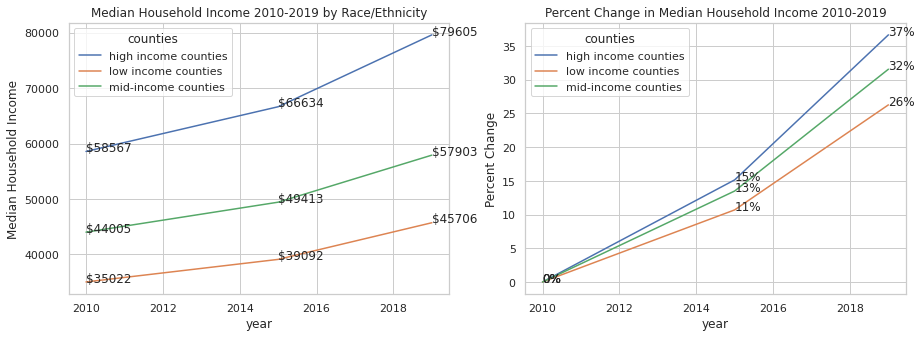

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data = mean_income, x = 'year', y = 'median_income', hue = 'counties')
for x, y in zip(mean_income['year'], mean_income['median_income']):
    plt.text(x = x, y = y, s = '${:.0f}'.format(y))
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Median Household Income')
plt.title('Median Household Income 2010-2019 by Race/Ethnicity')
plt.subplot(1,2,2)
sns.lineplot(data = mean_income_change, x = 'year', y = 'income_change', hue = 'counties')
for x, y in zip(mean_income_change['year'], mean_income_change['income_change']):
    plt.text(x = x, y = y, s = '{:.0f}%'.format(y))
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Percent Change')
plt.title('Percent Change in Median Household Income 2010-2019')
plt.show()

In [ ]:
df['pop_35_to_64_change'] = df.groupby(['fips'])['Percent 35-64'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))
#df['pop_65plus_change'] = df.groupby(['county'])['Percent 65+'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))

In [ ]:
df['pop_65plus_change'] = df.groupby(['fips'])['Percent 65+'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100)).fillna(0)

In [ ]:
df1 = df.copy()

In [ ]:
df1.drop(1996, axis =0, inplace = True)

In [ ]:
df1.drop(1296, axis =0, inplace = True)

In [ ]:
mean_pop_65plus_change = df1.groupby(['year', 'counties'])['pop_65plus_change'].mean().to_frame().reset_index()

In [ ]:
mean_pop_35to64_change = df1.groupby(['year', 'counties'])['pop_35_to_64_change'].mean().to_frame().reset_index()
mean_pop_65plus_change = df1.groupby(['year', 'counties'])['pop_65plus_change'].mean().to_frame().reset_index()

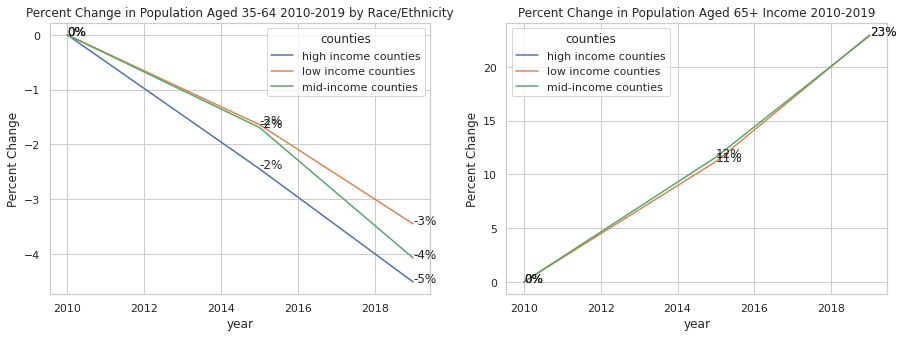

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data = mean_pop_35to64_change, x = 'year', y = 'pop_35_to_64_change', hue = 'counties')
for x, y in zip(mean_pop_35to64_change['year'], mean_pop_35to64_change['pop_35_to_64_change']):
    plt.text(x = x, y = y, s = '{:.0f}%'.format(y))
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Percent Change')
plt.title('Percent Change in Population Aged 35-64 2010-2019 by Race/Ethnicity')
plt.subplot(1,2,2)
sns.lineplot(data = mean_pop_65plus_change, x = 'year', y = 'pop_65plus_change', hue = 'counties')
for x, y in zip(mean_pop_65plus_change['year'], mean_pop_65plus_change['pop_65plus_change']):
    plt.text(x = x, y = y, s = '{:.0f}%'.format(y))
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Percent Change')
plt.title('Percent Change in Population Aged 65+ Income 2010-2019')
plt.show()

In [ ]:
mean_65pluspop =  df.groupby(['year','counties'])['65 years and over'].mean().to_frame().reset_index()
mean_65pluspop

year              counties  65 years and over
0  2010  high income counties       42532.204082
1  2010   low income counties        6930.761246
2  2010   mid-income counties       24439.842105
3  2015  high income counties       50124.766667
4  2015   low income counties        6973.013841
5  2015   mid-income counties       29017.174905
6  2019  high income counties       63987.475177
7  2019   low income counties        7828.933333
8  2019   mid-income counties       34820.515152

In [ ]:
mean_35to64pop = df.groupby(['year','counties'])['35 to 64 years'].mean().to_frame().reset_index()
mean_35to64pop

year              counties  35 to 64 years
0  2010  high income counties   146416.387755
1  2010   low income counties    20791.750865
2  2010   mid-income counties    74323.000000
3  2015  high income counties   151037.920000
4  2015   low income counties    18447.712803
5  2015   mid-income counties    81196.885932
6  2019  high income counties   168176.411348
7  2019   low income counties    18435.018182
8  2019   mid-income counties    88370.965368

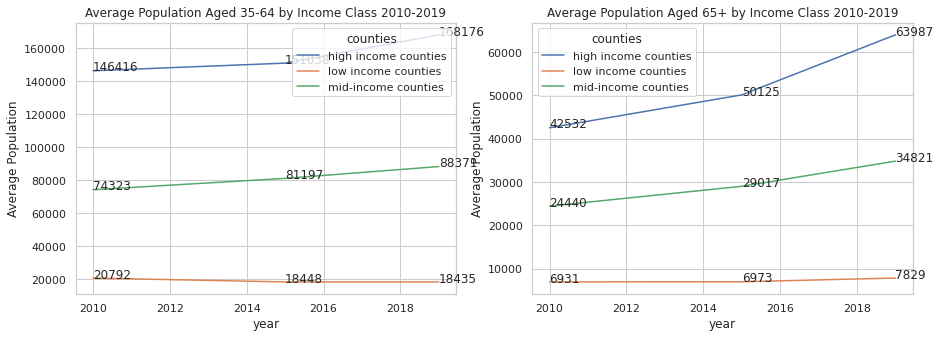

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data = mean_35to64pop, x = 'year', y = '35 to 64 years', hue = 'counties')
for x, y in zip(mean_35to64pop['year'], mean_35to64pop['35 to 64 years']):
    plt.text(x = x, y = y, s = '{:.0f}'.format(y))
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Average Population')
plt.title('Average Population Aged 35-64 by Income Class 2010-2019')
plt.subplot(1,2,2)
sns.lineplot(data = mean_65pluspop, x = 'year', y = '65 years and over', hue = 'counties')
for x, y in zip(mean_65pluspop['year'], mean_65pluspop['65 years and over']):
    plt.text(x = x, y = y, s = '{:.0f}'.format(y))
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Average Population')
plt.title('Average Population Aged 65+ by Income Class 2010-2019')
plt.show()

Unemployment Change

In [ ]:
mean_unemployment_change =df.groupby(['year', 'counties'])['unemployment_change'].mean().to_frame().reset_index()

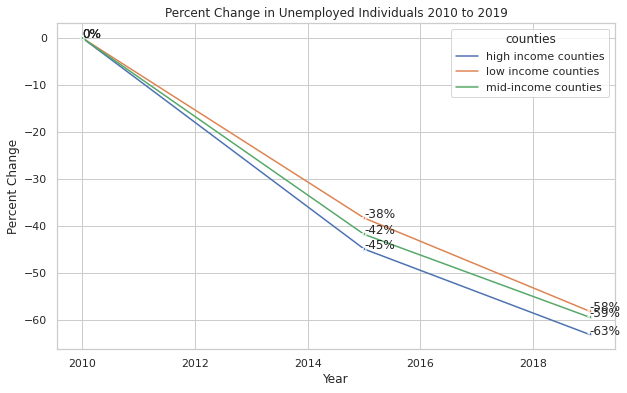

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(data = mean_unemployment_change, x = 'year', y = 'unemployment_change', hue = 'counties', legend = 'full', marker = '*')
for x, y in zip(mean_unemployment_change['year'], mean_unemployment_change['unemployment_change']):
    plt.text(x = x, y = y, s = '{:.0f}%'.format(y)) 
plt.xlabel('Year')
plt.ylabel('Percent Change')
plt.title('Percent Change in Unemployed Individuals 2010 to 2019')
plt.ticklabel_format(style='plain')

Medicaid Change

In [ ]:
mean_medicaid_change = df.groupby(['year', 'counties'])['medicaid_change'].mean().to_frame().reset_index()

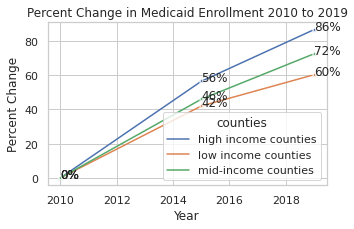

In [ ]:
plt.figure(figsize=(5,3))
sns.lineplot(data = mean_medicaid_change, x = 'year', y = 'medicaid_change', hue = 'counties', legend = 'full', marker = '*')
for x, y in zip(mean_unemployment_change['year'], mean_medicaid_change['medicaid_change']):
    plt.text(x = x, y = y, s = '{:.0f}%'.format(y)) 
plt.xlabel('Year')
plt.ylabel('Percent Change')
plt.title('Percent Change in Medicaid Enrollment 2010 to 2019')
plt.ticklabel_format(style='plain')

Poverty Change

In [ ]:
mean_poverty_change = df.groupby(['year', 'counties'])['poverty_change'].mean().to_frame().reset_index()

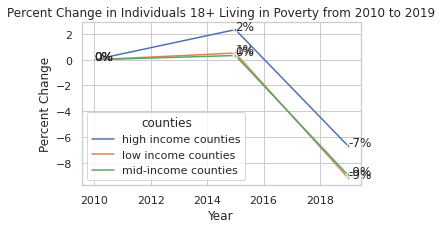

In [ ]:
plt.figure(figsize=(5,3))
sns.lineplot(data = mean_poverty_change, x = 'year', y = 'poverty_change', hue = 'counties', legend = 'full', marker = '*')
for x, y in zip(mean_unemployment_change['year'], mean_poverty_change['poverty_change']):
    plt.text(x = x, y = y, s = '{:.0f}%'.format(y)) 
plt.xlabel('Year')
plt.ylabel('Percent Change')
plt.title('Percent Change in Individuals 18+ Living in Poverty from 2010 to 2019')
plt.ticklabel_format(style='plain')

Food Access Change 

In [ ]:
mean_la_change = df.groupby(['year', 'counties'])['low_access_change'].mean().to_frame().reset_index()
mean_lila_change = (df[df['low_income_low_access_change']!=np.inf]).groupby(['year', 'counties'])['low_income_low_access_change'].mean().to_frame().reset_index()

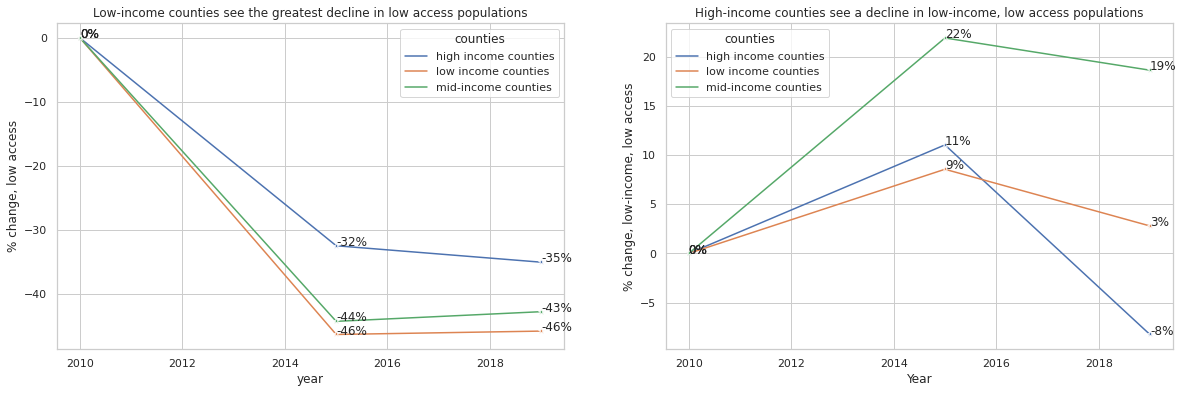

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.lineplot(data = mean_la_change, x = 'year', y = 'low_access_change', hue = 'counties', legend = 'full', marker = '*')
for x, y in zip(mean_la_change['year'], mean_la_change['low_access_change']):
    plt.text(x = x, y = y, s = '{:.0f}%'.format(y)) 
plt.xlabel('year')
plt.ylabel('% change, low access')
plt.title('Low-income counties see the greatest decline in low access populations')
plt.ticklabel_format(style='plain')
plt.subplot(1,2,2)
sns.lineplot(data = mean_lila_change, x = 'year', y = 'low_income_low_access_change', hue = 'counties', legend = 'full', marker = '*')
for x, y in zip(mean_lila_change['year'], mean_lila_change['low_income_low_access_change']):
    plt.text(x = x, y = y, s = '{:.0f}%'.format(y)) 
plt.xlabel('Year')
plt.ylabel('% change, low-income, low access')
plt.title('High-income counties see a decline in low-income, low access populations')
plt.ticklabel_format(style='plain')

In [ ]:
mean_la = df.groupby(['year','counties'])['low_access_percent'].mean().to_frame().reset_index()
mean_la

year              counties  low_access_percent
0  2010  high income counties           80.213605
1  2010   low income counties           82.961938
2  2010   mid-income counties           83.512782
3  2015  high income counties           53.733333
4  2015   low income counties           43.829412
5  2015   mid-income counties           45.007224
6  2019  high income counties           51.113475
7  2019   low income counties           44.432424
8  2019   mid-income counties           46.496104

In [ ]:
mean_lila = df.groupby(['year','counties'])['low_income_low_access_percent'].mean().to_frame().reset_index()
mean_lila

year              counties  low_income_low_access_percent
0  2010  high income counties                       5.102041
1  2010   low income counties                      16.188927
2  2010   mid-income counties                       7.833835
3  2015  high income counties                       5.454667
4  2015   low income counties                      16.380623
5  2015   mid-income counties                       9.182129
6  2019  high income counties                       3.831915
7  2019   low income counties                      14.905758
8  2019   mid-income counties                       8.483550

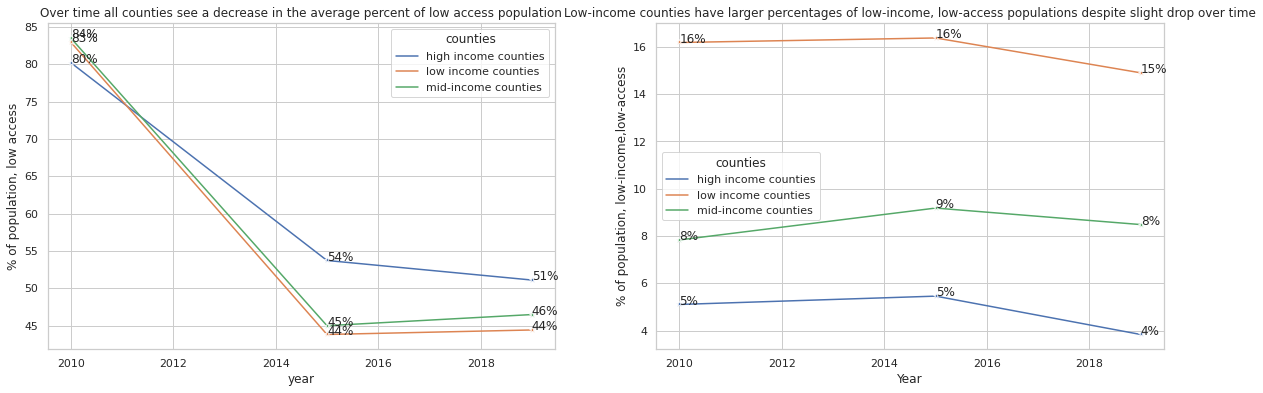

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.lineplot(data = mean_la, x = 'year', y = 'low_access_percent', hue = 'counties', legend = 'full', marker = '*')
for x, y in zip(mean_la['year'], mean_la['low_access_percent']):
    plt.text(x = x, y = y, s = '{:.0f}%'.format(y)) 
plt.xlabel('year')
plt.ylabel('% of population, low access')
plt.title('Over time all counties see a decrease in the average percent of low access population')
plt.ticklabel_format(style='plain')
plt.subplot(1,2,2)
sns.lineplot(data = mean_lila, x = 'year', y = 'low_income_low_access_percent', hue = 'counties', legend = 'full', marker = '*')
for x, y in zip(mean_lila['year'], mean_lila['low_income_low_access_percent']):
    plt.text(x = x, y = y, s = '{:.0f}%'.format(y)) 
plt.xlabel('Year')
plt.ylabel('% of population, low-income,low-access')
plt.title('Low-income counties have larger percentages of low-income, low-access populations despite slight drop over time')
plt.ticklabel_format(style='plain')

Education Change

In [ ]:
df['less_hs_diploma_change'] = df.groupby('fips')['Less than a high school diploma'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))
df['hs_diploma_change'] = df.groupby('fips')['High school diploma only'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))
df['some_college_change'] = df.groupby('fips')['Some college or associate degree'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))
df['bachelor_plus_change'] = df.groupby('fips')['Bachelor degree or higher'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))


In [ ]:
mean_less_hs_change = df.groupby(['year', 'counties'])['less_hs_diploma_change'].mean().to_frame().reset_index()
mean_hs_only_change = df.groupby(['year', 'counties'])['hs_diploma_change'].mean().to_frame().reset_index()
mean_some_college_change = df.groupby(['year', 'counties'])['some_college_change'].mean().to_frame().reset_index()
mean_bach_plus_change = df.groupby(['year', 'counties'])['bachelor_plus_change'].mean().to_frame().reset_index()

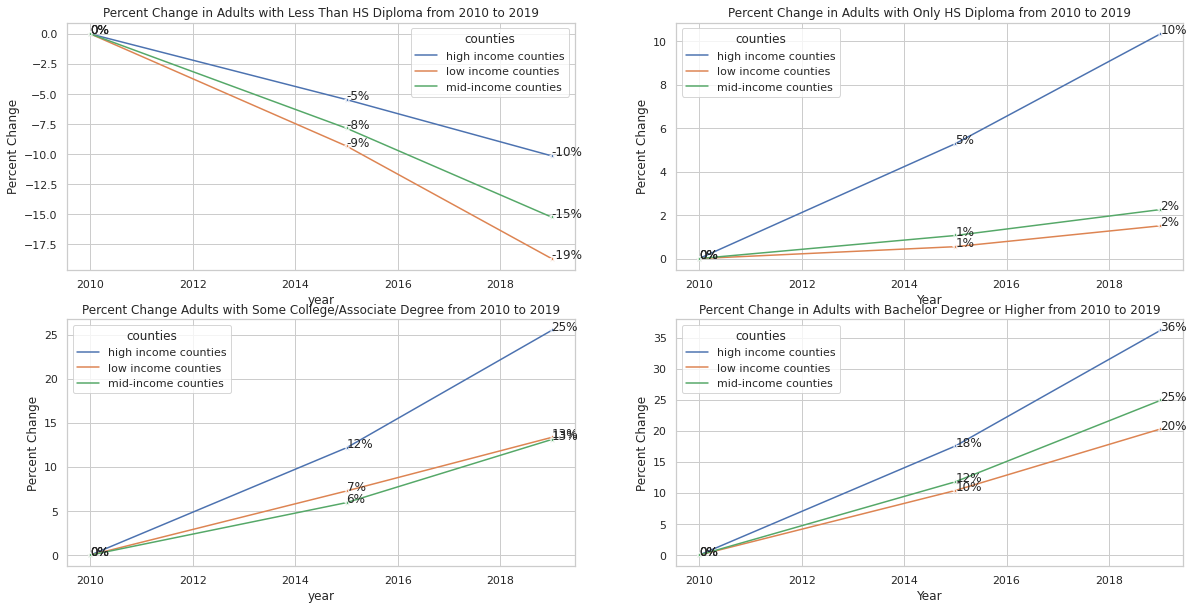

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.lineplot(data = mean_less_hs_change, x = 'year', y = 'less_hs_diploma_change', hue = 'counties', legend = 'full', marker = '*')
for x, y in zip(mean_less_hs_change['year'], mean_less_hs_change['less_hs_diploma_change']):
    plt.text(x = x, y = y, s = '{:.0f}%'.format(y)) 
plt.xlabel('year')
plt.ylabel('Percent Change')
plt.title('Percent Change in Adults with Less Than HS Diploma from 2010 to 2019')
plt.ticklabel_format(style='plain')
plt.subplot(2,2,2)
sns.lineplot(data = mean_hs_only_change, x = 'year', y = 'hs_diploma_change', hue = 'counties', legend = 'full', marker = '*')
for x, y in zip(mean_hs_only_change['year'], mean_hs_only_change['hs_diploma_change']):
    plt.text(x = x, y = y, s = '{:.0f}%'.format(y)) 
plt.xlabel('Year')
plt.ylabel('Percent Change')
plt.title('Percent Change in Adults with Only HS Diploma from 2010 to 2019')
plt.ticklabel_format(style='plain')
plt.subplot(2,2,3)
sns.lineplot(data = mean_some_college_change, x = 'year', y = 'some_college_change', hue = 'counties', legend = 'full', marker = '*')
for x, y in zip(mean_some_college_change['year'], mean_some_college_change['some_college_change']):
    plt.text(x = x, y = y, s = '{:.0f}%'.format(y)) 
plt.xlabel('year')
plt.ylabel('Percent Change')
plt.title('Percent Change Adults with Some College/Associate Degree from 2010 to 2019')
plt.ticklabel_format(style='plain')
plt.subplot(2,2,4)
sns.lineplot(data = mean_bach_plus_change, x = 'year', y = 'bachelor_plus_change', hue = 'counties', legend = 'full', marker = '*')
for x, y in zip(mean_bach_plus_change['year'], mean_bach_plus_change['bachelor_plus_change']):
    plt.text(x = x, y = y, s = '{:.0f}%'.format(y)) 
plt.xlabel('Year')
plt.ylabel('Percent Change')
plt.title('Percent Change in Adults with Bachelor Degree or Higher from 2010 to 2019')
plt.ticklabel_format(style='plain')

CVD Change

In [ ]:
df_no_inf = df[df['total_cvd_change'] != np.inf]


In [ ]:
mean_cvd_change = df_no_inf.groupby(['year', 'counties'])['total_cvd_change'].mean().to_frame().reset_index()

In [ ]:
mean_cvd_change

year              counties  total_cvd_change
0  2010  high income counties          0.000000
1  2010   low income counties          0.000000
2  2010   mid-income counties          0.000000
3  2015  high income counties          9.253993
4  2015   low income counties         15.914192
5  2015   mid-income counties         13.388824
6  2019  high income counties         30.209685
7  2019   low income counties         43.422959
8  2019   mid-income counties         38.574928

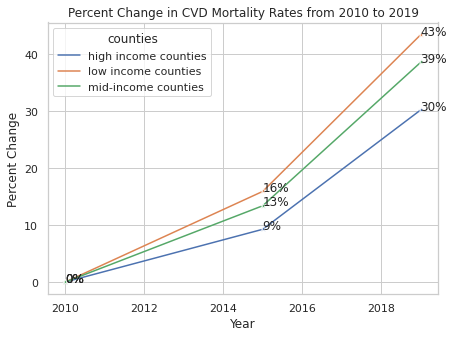

In [ ]:
plt.figure(figsize=(7,5))
sns.lineplot(data = mean_cvd_change, x = 'year', y = 'total_cvd_change', hue = 'counties', legend = 'full', marker = '*')
for x, y in zip(mean_cvd_change['year'], mean_cvd_change['total_cvd_change']):
    plt.text(x = x, y = y, s = '{:.0f}%'.format(y)) 
plt.xlabel('Year')
plt.ylabel('Percent Change')
plt.title('Percent Change in CVD Mortality Rates from 2010 to 2019')
plt.ticklabel_format(style='plain')

In [ ]:
df.groupby('counties')['Total Population'].mean()

counties
high income counties    379005.105023
low income counties      52080.157489
mid-income counties     207359.226316
Name: Total Population, dtype: float64

In [ ]:
mean_deathsper100k = df.groupby(['year','counties'])['Deaths/100k'].mean().unstack()
mean_deathsper100k

counties  high income counties  low income counties  mid-income counties
year                                                                    
2010                109.503401           140.211073           130.781955
2015                116.153333           161.262976           151.091255
2019                136.290780           196.945455           181.649351

In [ ]:
df.groupby('counties')['Total Population'].mean()

counties
high income counties    379005.105023
low income counties      52080.157489
mid-income counties     207359.226316
Name: Total Population, dtype: float64

#Testing Correlations (high vs. low income scatterplots)

Medicaid and CVD

In [ ]:
medicaid_cvd = df[['medicaid_rate', 'Deaths/100k', 'counties']]

In [ ]:
medicaid_cvd.corr()

medicaid_rate  Deaths/100k
medicaid_rate       1.000000     0.416599
Deaths/100k         0.416599     1.000000

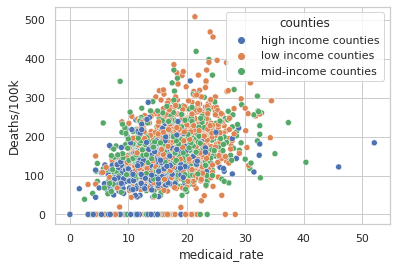

In [ ]:
sns.scatterplot(data = medicaid_cvd, x = "medicaid_rate", y = "Deaths/100k", hue = 'counties')

Median Income and CVD

In [ ]:
df['median_income'].corr(df['Deaths/100k'])

-0.10535631968017252

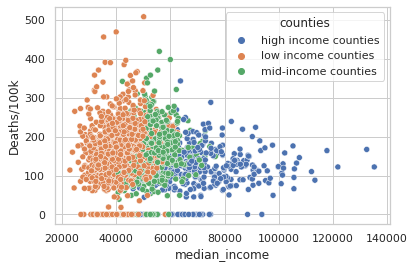

In [ ]:
sns.scatterplot(data = df, x = "median_income", y = "Deaths/100k", hue = 'counties')

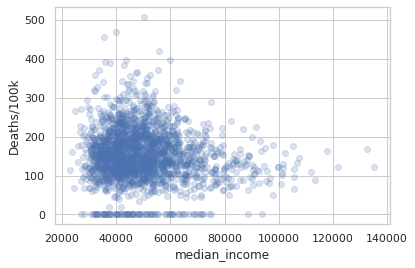

In [ ]:
sns.regplot(x="median_income",y="Deaths/100k",data=df,fit_reg=False,scatter_kws={"alpha":0.2})

Unemployment and CVD

-0.13523270824422734


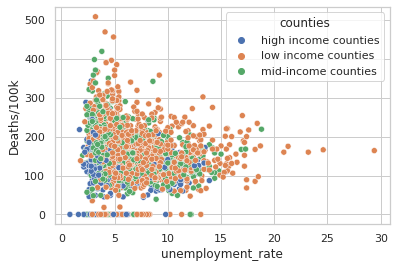

In [ ]:
print(df['unemployment_rate'].corr(df['Deaths/100k']))
sns.scatterplot(data = df, x = "unemployment_rate", y = "Deaths/100k", hue = 'counties')

Poverty and CVD

-0.7367134291760643


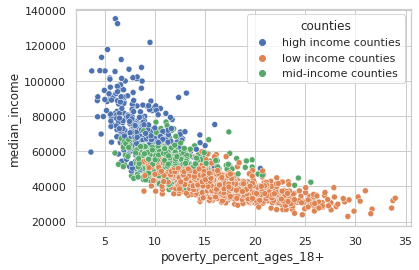

In [ ]:
print(df['poverty_percent_ages_18+'].corr(df['median_income']))
sns.scatterplot(data = df, x = 'poverty_percent_ages_18+', y = "median_income", hue = 'counties')

Education and CVD

2010


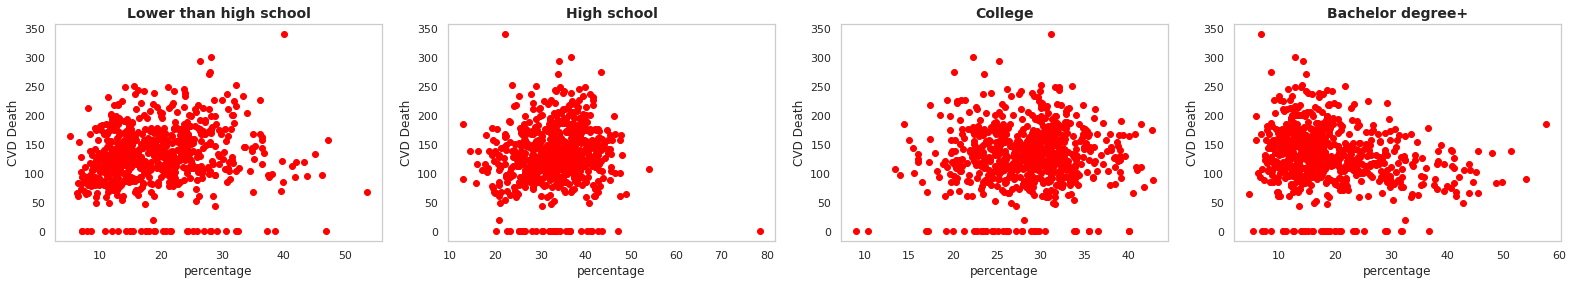

In [ ]:
#Filter the dataframe to have only the variable needed for this visualization. For simplicity, visualize each year at a time
df_for_analysis = df[["year", "state", "county", "Percent of adults with less than a high school diploma","Percent of adults with a high school diploma only","Percent of adults completing some college or associate degree","Percent of adults with a bachelor degree or higher","Deaths/100k"]]

def education_death_rate_plot(df_for_analysis, year):
  df_for_analysis_2010 = df_for_analysis[df_for_analysis["year"]== year]

  fig, (ax1, ax2,ax3, ax4) = plt.subplots(1, 4, figsize = (27,4));


  #Making a dicationary of the plots so that I can make the four plots at once
  ax_dict = {
      ax1:["Lower than high school", "Percent of adults with less than a high school diploma"],
      ax2:["High school", "Percent of adults with a high school diploma only"],
      ax3:["College", "Percent of adults completing some college or associate degree"],
      ax4:["Bachelor degree+", "Percent of adults with a bachelor degree or higher"]

  }

  for ax in (ax1, ax2, ax3, ax4):
    ax.scatter(y = df_for_analysis_2010["Deaths/100k"], x = df_for_analysis_2010[ax_dict[ax][1]], color='red')
    ax.set_title(ax_dict[ax][0], fontdict={'fontweight':'bold', 'fontsize':14})
    ax.set_xlabel("percentage")
    ax.set_ylabel("CVD Death")
  for ax in (ax1, ax2, ax3,ax4):
    ax.grid(False)

print("2010")
education_death_rate_plot(df_for_analysis, 2010)


In [ ]:
df2010 = df[(df.year == 2010)]
df2010_var = df2010[['Deaths/100k','Percent of adults with less than a high school diploma', 'Percent of adults with a high school diploma only', 'Percent of adults completing some college or associate degree', 'Percent of adults with a bachelor degree or higher']]
df2010_var.corr()

Deaths/100k  \
Deaths/100k                                            1.000000   
Percent of adults with less than a high school ...     0.115856   
Percent of adults with a high school diploma only      0.082110   
Percent of adults completing some college or as...     0.042095   
Percent of adults with a bachelor degree or higher    -0.196138   

                                                    Percent of adults with less than a high school diploma  \
Deaths/100k                                                                                  0.115856        
Percent of adults with less than a high school ...                                           1.000000        
Percent of adults with a high school diploma only                                            0.094821        
Percent of adults completing some college or as...                                          -0.617756        
Percent of adults with a bachelor degree or higher                                          -0.612363        

                                                    Percent of adults with a high school diploma only  \
Deaths/100k                                                                                  0.082110   
Percent of adults with less than a high school ...                                           0.094821   
Percent of adults with a high school diploma only                                            1.000000   
Percent of adults completing some college or as...                                          -0.295131   
Percent of adults with a bachelor degree or higher                                          -0.703343   

                                                    Percent of adults completing some college or associate degree  \
Deaths/100k                                                                                  0.042095               
Percent of adults with less than a high school ...                                          -0.617756               
Percent of adults with a high school diploma only                                           -0.295131               
Percent of adults completing some college or as...                                           1.000000               
Percent of adults with a bachelor degree or higher                                           0.193045               

                                                    Percent of adults with a bachelor degree or higher  
Deaths/100k                                                                                 -0.196138   
Percent of adults with less than a high school ...                                          -0.612363   
Percent of adults with a high school diploma only                                           -0.703343   
Percent of adults completing some college or as...                                           0.193045   
Percent of adults with a bachelor degree or higher                                           1.000000

2015


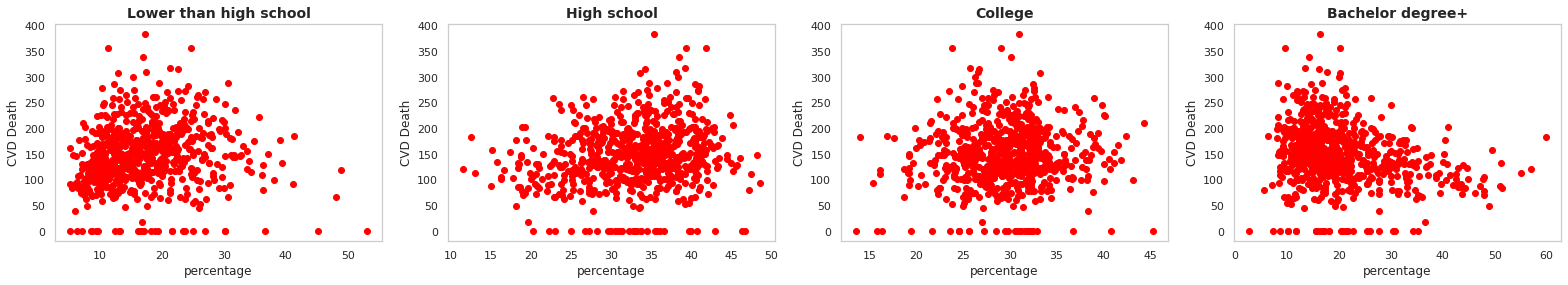

In [ ]:
print("2015")
education_death_rate_plot(df_for_analysis, 2015)

In [ ]:
df2015 = df[(df.year == 2015)]
df2015_var = df2015[['Deaths/100k','Percent of adults with less than a high school diploma', 'Percent of adults with a high school diploma only', 'Percent of adults completing some college or associate degree', 'Percent of adults with a bachelor degree or higher']]
df2015_var.corr()

Deaths/100k  \
Deaths/100k                                            1.000000   
Percent of adults with less than a high school ...     0.105924   
Percent of adults with a high school diploma only      0.164658   
Percent of adults completing some college or as...     0.058282   
Percent of adults with a bachelor degree or higher    -0.234684   

                                                    Percent of adults with less than a high school diploma  \
Deaths/100k                                                                                  0.105924        
Percent of adults with less than a high school ...                                           1.000000        
Percent of adults with a high school diploma only                                            0.169302        
Percent of adults completing some college or as...                                          -0.612964        
Percent of adults with a bachelor degree or higher                                          -0.609367        

                                                    Percent of adults with a high school diploma only  \
Deaths/100k                                                                                  0.164658   
Percent of adults with less than a high school ...                                           0.169302   
Percent of adults with a high school diploma only                                            1.000000   
Percent of adults completing some college or as...                                          -0.163974   
Percent of adults with a bachelor degree or higher                                          -0.770147   

                                                    Percent of adults completing some college or associate degree  \
Deaths/100k                                                                                  0.058282               
Percent of adults with less than a high school ...                                          -0.612964               
Percent of adults with a high school diploma only                                           -0.163974               
Percent of adults completing some college or as...                                           1.000000               
Percent of adults with a bachelor degree or higher                                           0.089408               

                                                    Percent of adults with a bachelor degree or higher  
Deaths/100k                                                                                 -0.234684   
Percent of adults with less than a high school ...                                          -0.609367   
Percent of adults with a high school diploma only                                           -0.770147   
Percent of adults completing some college or as...                                           0.089408   
Percent of adults with a bachelor degree or higher                                           1.000000

2019


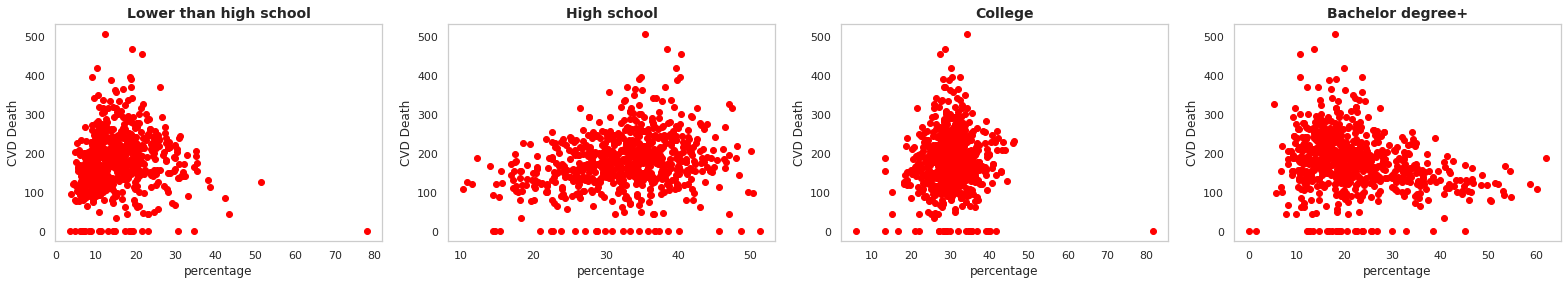

In [ ]:
print("2019")
education_death_rate_plot(df_for_analysis, 2019)

In [ ]:
df2019 = df[(df.year == 2019)]
df2019_var = df2019[['Deaths/100k','Percent of adults with less than a high school diploma', 'Percent of adults with a high school diploma only', 'Percent of adults completing some college or associate degree', 'Percent of adults with a bachelor degree or higher']]
df2019_var.corr()

Deaths/100k  \
Deaths/100k                                            1.000000   
Percent of adults with less than a high school ...     0.075454   
Percent of adults with a high school diploma only      0.231101   
Percent of adults completing some college or as...     0.033395   
Percent of adults with a bachelor degree or higher    -0.244160   

                                                    Percent of adults with less than a high school diploma  \
Deaths/100k                                                                                  0.075454        
Percent of adults with less than a high school ...                                           1.000000        
Percent of adults with a high school diploma only                                            0.147226        
Percent of adults completing some college or as...                                          -0.525336        
Percent of adults with a bachelor degree or higher                                          -0.570537        

                                                    Percent of adults with a high school diploma only  \
Deaths/100k                                                                                  0.231101   
Percent of adults with less than a high school ...                                           0.147226   
Percent of adults with a high school diploma only                                            1.000000   
Percent of adults completing some college or as...                                          -0.163116   
Percent of adults with a bachelor degree or higher                                          -0.750967   

                                                    Percent of adults completing some college or associate degree  \
Deaths/100k                                                                                  0.033395               
Percent of adults with less than a high school ...                                          -0.525336               
Percent of adults with a high school diploma only                                           -0.163116               
Percent of adults completing some college or as...                                           1.000000               
Percent of adults with a bachelor degree or higher                                          -0.038634               

                                                    Percent of adults with a bachelor degree or higher  
Deaths/100k                                                                                 -0.244160   
Percent of adults with less than a high school ...                                          -0.570537   
Percent of adults with a high school diploma only                                           -0.750967   
Percent of adults completing some college or as...                                          -0.038634   
Percent of adults with a bachelor degree or higher                                           1.000000

In [ ]:
df_var = df[['Deaths/100k','Percent of adults with less than a high school diploma', 'Percent of adults with a high school diploma only', 'Percent of adults completing some college or associate degree', 'Percent of adults with a bachelor degree or higher']]
df_var.corr()

Deaths/100k  \
Deaths/100k                                            1.000000   
Percent of adults with less than a high school ...     0.025192   
Percent of adults with a high school diploma only      0.141116   
Percent of adults completing some college or as...     0.086528   
Percent of adults with a bachelor degree or higher    -0.174145   

                                                    Percent of adults with less than a high school diploma  \
Deaths/100k                                                                                  0.025192        
Percent of adults with less than a high school ...                                           1.000000        
Percent of adults with a high school diploma only                                            0.144646        
Percent of adults completing some college or as...                                          -0.595816        
Percent of adults with a bachelor degree or higher                                          -0.604430        

                                                    Percent of adults with a high school diploma only  \
Deaths/100k                                                                                  0.141116   
Percent of adults with less than a high school ...                                           0.144646   
Percent of adults with a high school diploma only                                            1.000000   
Percent of adults completing some college or as...                                          -0.214369   
Percent of adults with a bachelor degree or higher                                          -0.741269   

                                                    Percent of adults completing some college or associate degree  \
Deaths/100k                                                                                  0.086528               
Percent of adults with less than a high school ...                                          -0.595816               
Percent of adults with a high school diploma only                                           -0.214369               
Percent of adults completing some college or as...                                           1.000000               
Percent of adults with a bachelor degree or higher                                           0.093029               

                                                    Percent of adults with a bachelor degree or higher  
Deaths/100k                                                                                 -0.174145   
Percent of adults with less than a high school ...                                          -0.604430   
Percent of adults with a high school diploma only                                           -0.741269   
Percent of adults completing some college or as...                                           0.093029   
Percent of adults with a bachelor degree or higher                                           1.000000

Across the years, we see that high school diploma and bachelor's degrees are the two variables with the higher correlation (compared to less than hs and some college). However, overtime, the correlations are decreasing.

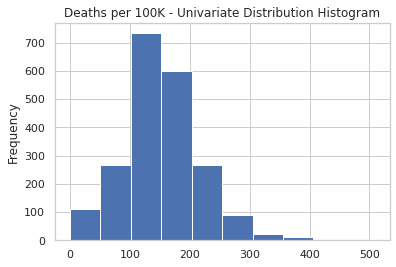

In [ ]:
df['Deaths/100k'].plot(kind = 'hist', xlabel = 'Deaths', title = 'Deaths per 100K - Univariate Distribution Histogram')
plt.show()

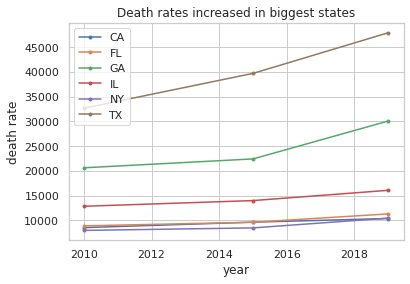

In [ ]:
#variations of total death rates per year by state
df.groupby(['year', 'state'])['Deaths/100k'].sum().unstack().plot(kind='line', ylabel='death rate', title='Death rates increased in biggest states', style='.-').legend(loc='best')
plt.show()

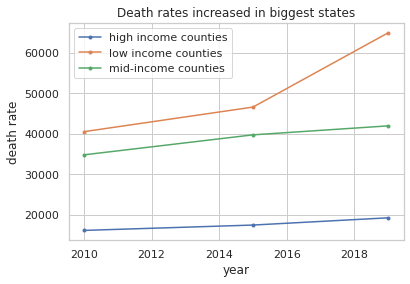

In [ ]:
df.groupby(['year', 'counties'])['Deaths/100k'].sum().unstack().plot(kind='line', ylabel='death rate', title='Death rates increased in biggest states', style='.-').legend(loc='best')
plt.show()

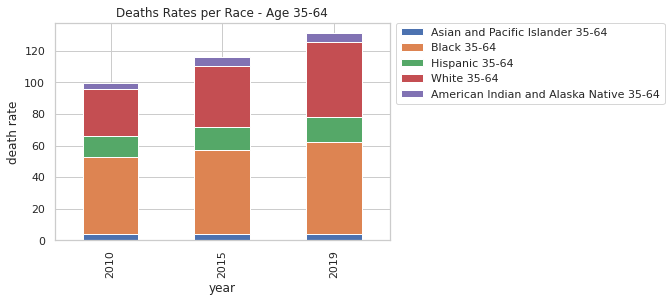

In [ ]:
df3564 = df[['year', 'Asian and Pacific Islander 35-64', 'Black 35-64', 'Hispanic 35-64', 'White 35-64','American Indian and Alaska Native 35-64']]
df3564.groupby('year').mean().plot(kind='bar', stacked=True, ylabel='death rate', title='Deaths Rates per Race - Age 35-64').legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

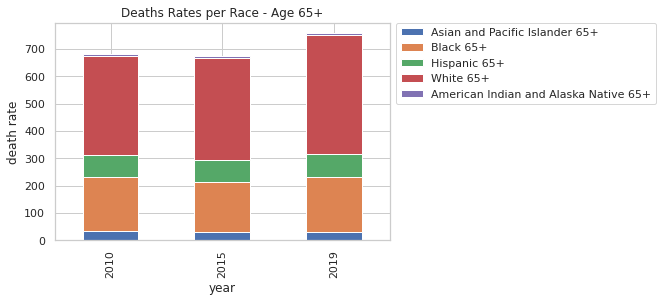

In [ ]:
df65 = df[['year', 'Asian and Pacific Islander 65+', 'Black 65+', 'Hispanic 65+', 'White 65+', 'American Indian and Alaska Native 65+']]
df65.groupby('year').mean().plot(kind='bar', stacked=True, ylabel='death rate', title='Deaths Rates per Race - Age 65+').legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

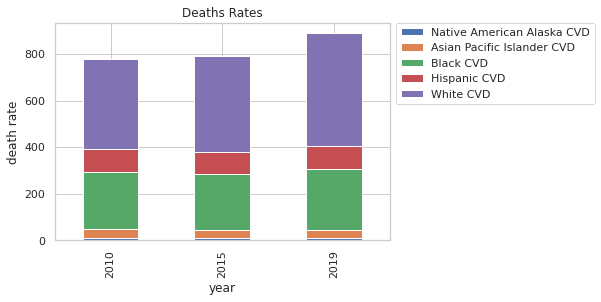

In [ ]:
dftotal = df[['year', 'Native American Alaska CVD', 'Asian Pacific Islander CVD', 'Black CVD', 'Hispanic CVD', 'White CVD']]
dftotal.groupby('year').mean().plot(kind='bar', stacked=True, ylabel='death rate', title='Deaths Rates').legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

###Change Over Time Correlation

In [ ]:
pd.set_option('display.max_rows', None)
corrm = df.corr()
all_cor = corrm['Deaths/100k'] 
#corrm['price'][pos_cor].sort_values(ascending = False).to_frame()
all_cor.sort_values(ascending = False).to_frame()

Deaths/100k
Deaths/100k                                            1.000000
Overall 65+                                            0.906851
White CVD                                              0.811172
White 65+                                              0.792994
Overall 35-64                                          0.692678
White 35-64                                            0.632697
total_cvd_change                                       0.501510
total_crude_cvd_change                                 0.447848
medicaid_rate                                          0.416599
Black 35-64                                            0.351015
year                                                   0.301517
Black CVD                                              0.233060
income_change                                          0.224892
Hispanic 35-64                                         0.209560
Black 65+                                              0.199047
bachelor_plus_change                                   0.171492
poverty_percent_all_ages                               0.158078
poverty_percent_ages_18+                               0.149513
Percent of adults with a high school diploma only      0.141116
Percent 65+                                            0.130695
Hispanic CVD                                           0.096286
Percent of adults completing some college or as...     0.086528
Hispanic 65+                                           0.081054
pop_65plus_change                                      0.080832
low_income_low_access_percent                          0.079310
Percent 18+                                            0.066724
medicaid_change                                        0.056011
American Indian and Alaska Native 35-64                0.043597
Native American Alaska CVD                             0.038898
65plus_cvd_deaths_crude                                0.035416
fips                                                   0.034660
total_cvd_deaths_crude                                 0.033956
low_income_low_access_change                           0.033333
American Indian and Alaska Native 65+                  0.032416
Percent 25+                                            0.030774
35to64_cvd_deaths_crude                                0.027771
Asian and Pacific Islander 35-64                       0.026271
Median age (years)                                     0.025867
hs_diploma_change                                      0.025281
Percent of adults with less than a high school ...     0.025192
Asian Pacific Islander CVD                             0.021160
Asian and Pacific Islander 65+                         0.020253
American Indian and Alaska Native                      0.018613
Percent 35+                                            0.012641
Less than a high school diploma                       -0.005248
poverty_estimate_all_ages                             -0.005840
Hispanic or Latino                                    -0.006100
Black or African American                             -0.006441
poverty_estimate_ages_18+                             -0.007095
total_medicaid_enrollment                             -0.011454
High school diploma only                              -0.018263
some_college_change                                   -0.018921
Asian and Pacific Islander                            -0.020203
65 years and over                                     -0.022905
18 years and over                                     -0.026740
Total Population                                      -0.026990
Some college or associate degree                      -0.027064
Total Population_25+                                  -0.027341
25 to 64 years                                        -0.028241
Total Population_35+                                  -0.029862
35 to 64 years                                        -0.031946
employed                                              -0.033243
labor_force         

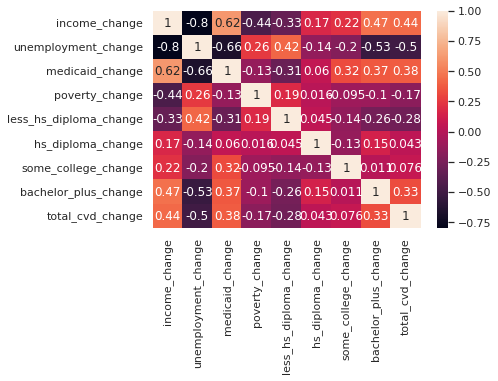

In [ ]:
change_over_time = df[['counties', 'income_change', 'unemployment_change', 'medicaid_change', 'poverty_change','less_hs_diploma_change', 'hs_diploma_change','some_college_change', 'bachelor_plus_change','total_cvd_change']]
sns.heatmap(change_over_time.corr(), annot = True)

###Correlations for High Income Counties

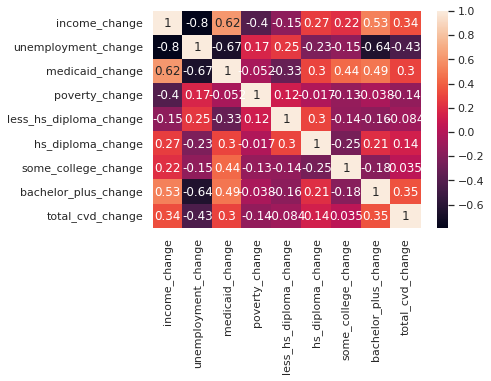

In [ ]:
df_high_income = df[(df.counties == 'high income counties')]
high_income_change_over_time = df_high_income[['counties', 'income_change', 'unemployment_change', 'medicaid_change', 'poverty_change','less_hs_diploma_change', 'hs_diploma_change','some_college_change', 'bachelor_plus_change','total_cvd_change']]
sns.heatmap(high_income_change_over_time.corr(), annot = True)

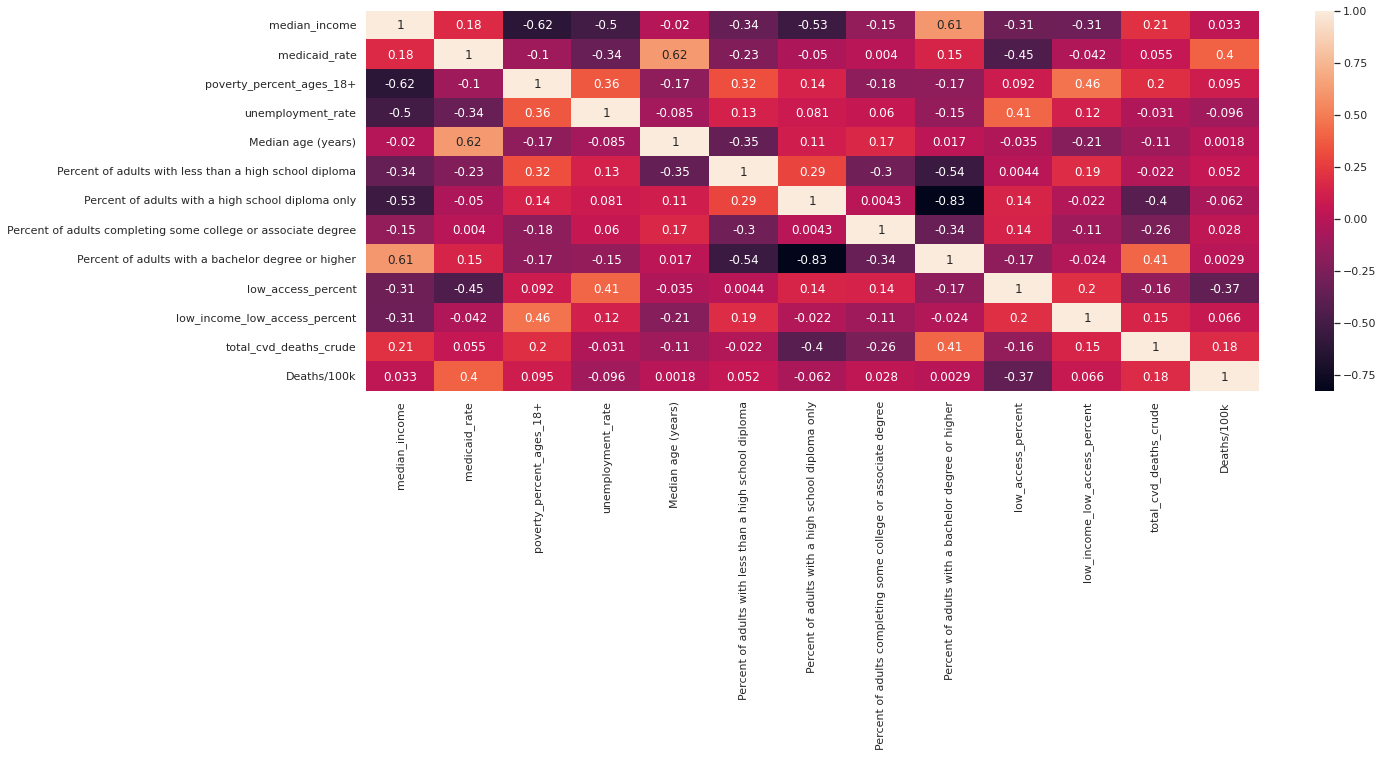

In [ ]:
corrs = df_high_income[['counties', 'median_income','medicaid_rate', 'poverty_percent_ages_18+', 'unemployment_rate', 'Median age (years)', 'Percent of adults with less than a high school diploma',
            'Percent of adults with a high school diploma only', 'Percent of adults completing some college or associate degree', 'Percent of adults with a bachelor degree or higher','low_access_percent','low_income_low_access_percent',
            'total_cvd_deaths_crude','Deaths/100k']]
plt.figure(figsize = (20,7))
sns.heatmap(corrs.corr(), annot = True)
plt.show()

###Correlations for Mid-Income Counties

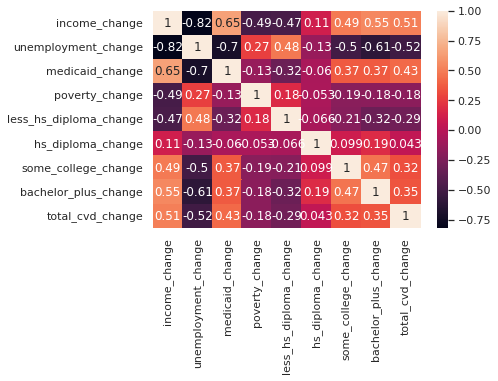

In [ ]:
df_mid_income = df[(df.counties == 'mid-income counties')]
mid_income_change_over_time = df_mid_income[['counties', 'income_change', 'unemployment_change', 'medicaid_change', 'poverty_change','less_hs_diploma_change', 'hs_diploma_change','some_college_change', 'bachelor_plus_change','total_cvd_change']]
sns.heatmap(mid_income_change_over_time.corr(), annot = True)

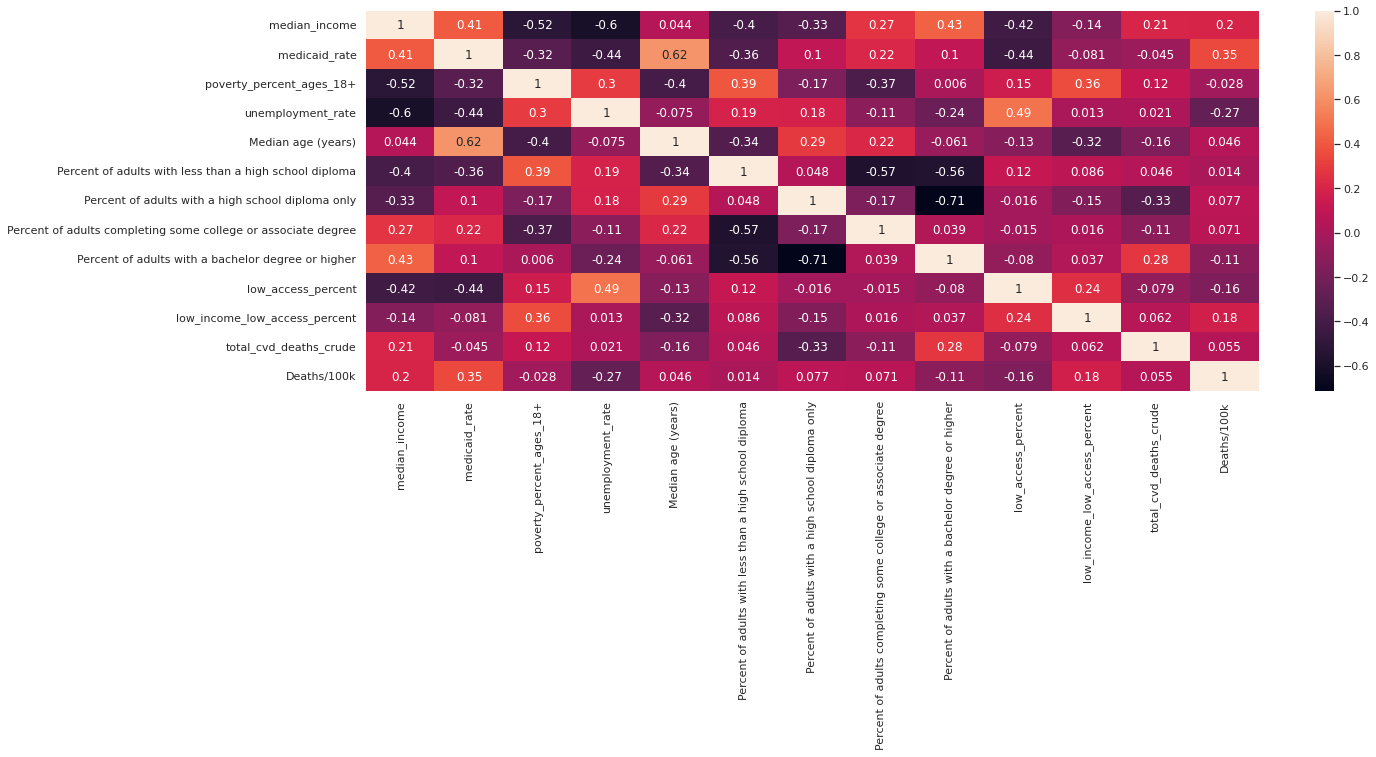

In [ ]:
corrs = df_mid_income[['counties', 'median_income','medicaid_rate', 'poverty_percent_ages_18+', 'unemployment_rate', 'Median age (years)', 'Percent of adults with less than a high school diploma',
            'Percent of adults with a high school diploma only', 'Percent of adults completing some college or associate degree', 'Percent of adults with a bachelor degree or higher','low_access_percent','low_income_low_access_percent',
            'total_cvd_deaths_crude','Deaths/100k']]
plt.figure(figsize = (20,7))
sns.heatmap(corrs.corr(), annot = True)
plt.show()

###Correlations for Low Income Counties

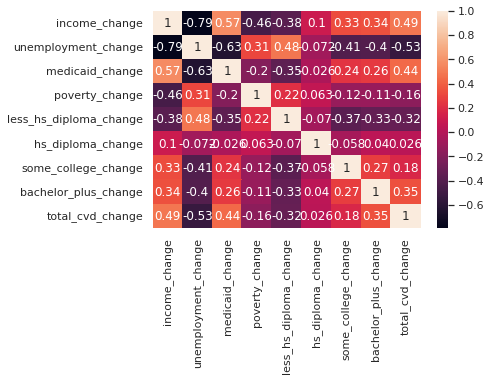

In [ ]:
df_low_income = df[(df.counties == 'low income counties')]
low_income_change_over_time = df_low_income[['counties', 'income_change', 'unemployment_change', 'medicaid_change', 'poverty_change','less_hs_diploma_change', 'hs_diploma_change','some_college_change', 'bachelor_plus_change','total_cvd_change']]
sns.heatmap(low_income_change_over_time.corr(), annot = True)

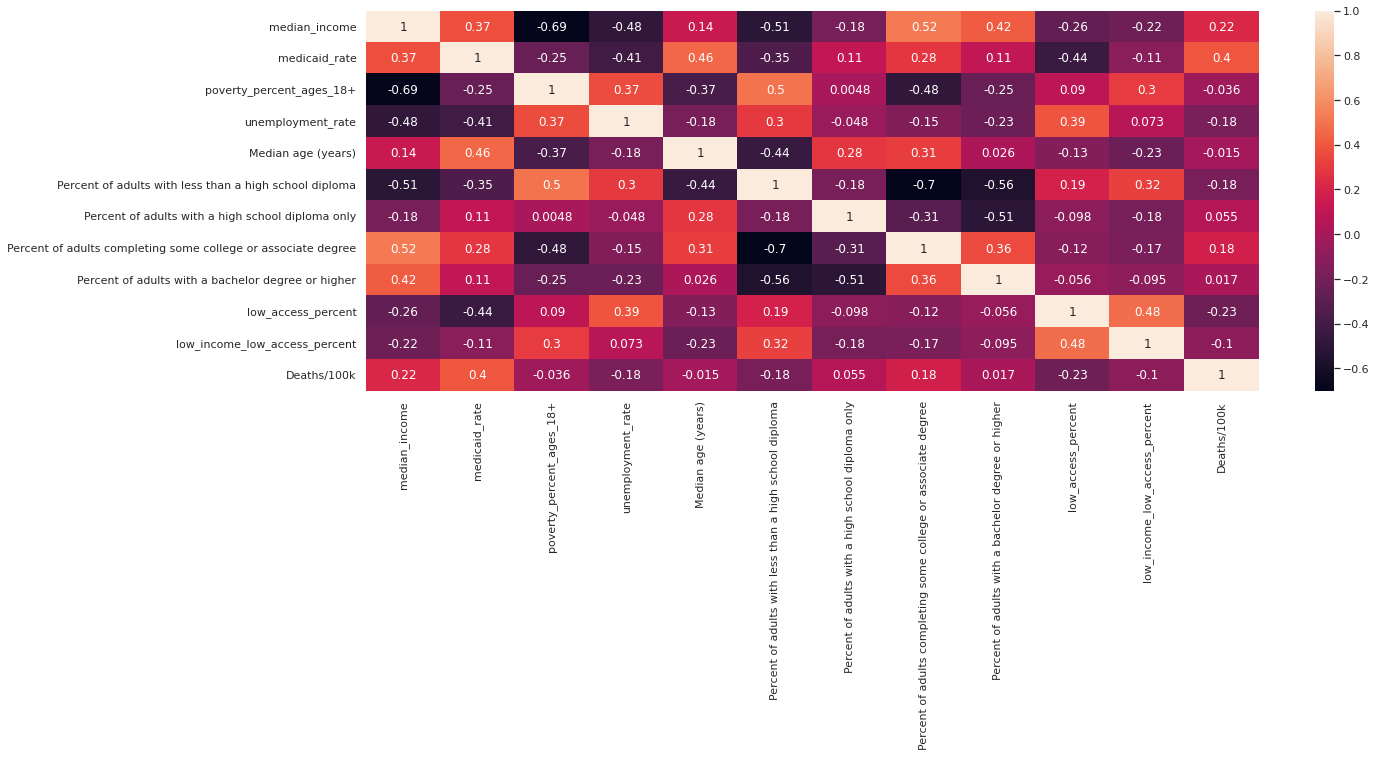

In [ ]:
corrs = df_low_income[['counties', 'median_income','medicaid_rate', 'poverty_percent_ages_18+', 'unemployment_rate', 'Median age (years)', 'Percent of adults with less than a high school diploma',
            'Percent of adults with a high school diploma only', 'Percent of adults completing some college or associate degree', 'Percent of adults with a bachelor degree or higher','low_access_percent','low_income_low_access_percent',
            'Deaths/100k']]
plt.figure(figsize = (20,7))
sns.heatmap(corrs.corr(), annot = True)
plt.show()

Comparing the correlations for each county income type, the correlations with variables seem to change. 

CVD Plots

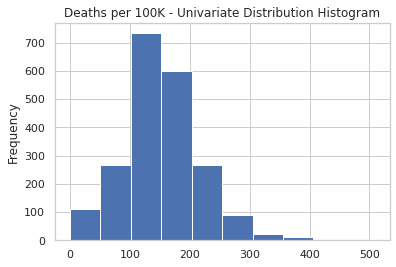

In [ ]:
#histogram of total death rates
df['Deaths/100k'].plot(kind = 'hist', xlabel = 'Deaths', title = 'Deaths per 100K - Univariate Distribution Histogram')
plt.show()

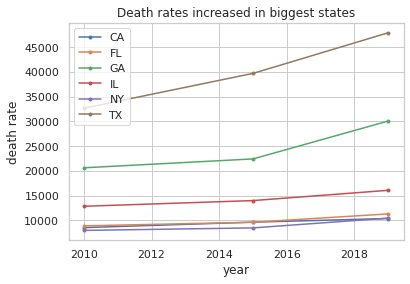

In [ ]:
#variations of total death rates per year by state
df.groupby(['year', 'state'])['Deaths/100k'].sum().unstack().plot(kind='line', ylabel='death rate', title='Death rates increased in biggest states', style='.-').legend(loc='best')
plt.show()

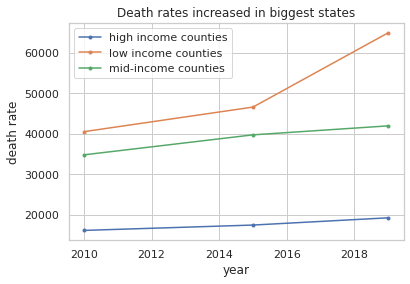

In [ ]:
df.groupby(['year', 'counties'])['Deaths/100k'].sum().unstack().plot(kind='line', ylabel='death rate', title='Death rates increased in biggest states', style='.-').legend(loc='best')
plt.show()

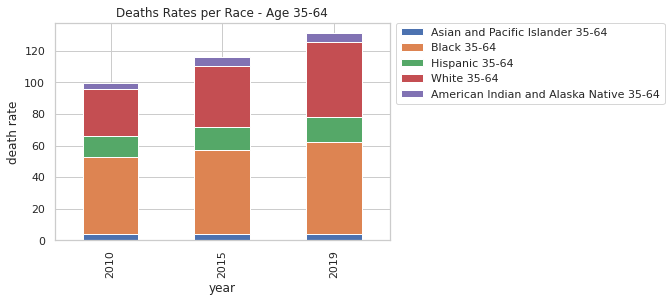

In [ ]:
df3564 = df[['year', 'Asian and Pacific Islander 35-64', 'Black 35-64', 'Hispanic 35-64', 'White 35-64','American Indian and Alaska Native 35-64']]
df3564.groupby('year').mean().plot(kind='bar', stacked=True, ylabel='death rate', title='Deaths Rates per Race - Age 35-64').legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

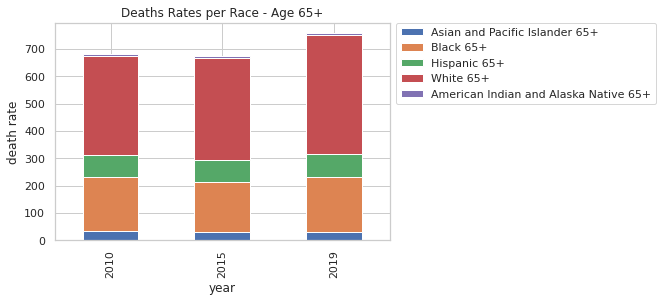

In [ ]:
df65 = df[['year', 'Asian and Pacific Islander 65+', 'Black 65+', 'Hispanic 65+', 'White 65+', 'American Indian and Alaska Native 65+']]
df65.groupby('year').mean().plot(kind='bar', stacked=True, ylabel='death rate', title='Deaths Rates per Race - Age 65+').legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

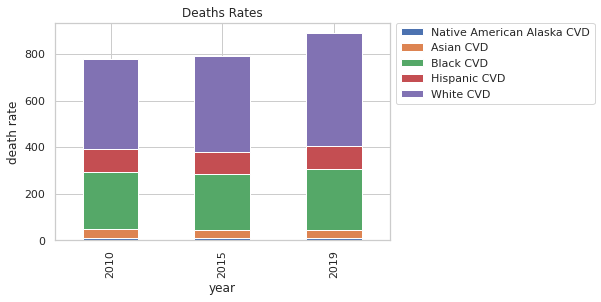

In [ ]:
df['Asian CVD'] = (df['Asian and Pacific Islander 65+'] + df['Asian and Pacific Islander 35-64']).fillna(0)
dftotal = df[['year','Native American Alaska CVD', 'Asian CVD', 'Black CVD', 'Hispanic CVD', 'White CVD']]
dftotal.groupby('year').mean().plot(kind='bar', stacked=True, ylabel='death rate', title='Deaths Rates').legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

#Testing CVD of Race + Age

In [ ]:
#Hispanic 35 to 64 number of deaths
hisp_pop = df['Hispanic or Latino']/df['Total Population']
perc_of_perc = hisp_pop*(df['Percent 35-64']/100)
hisp_35to64_pop = df['Total Population'] * perc_of_perc
df['hisp_35to64_crude'] = round((df['Hispanic 35-64'] * hisp_35to64_pop)/100000) 

In [ ]:
df['hisp_35to64_crude'].head()

0    35.0
1     0.0
2     1.0
3     4.0
4     0.0
Name: hisp_35to64_crude, dtype: float64

In [ ]:
#Hispanic 65+ number of deaths
hisp_pop = df['Hispanic or Latino']/df['Total Population']
perc_of_perc = hisp_pop*(df['Percent 65+']/100)
hisp_65plus_pop = df['Total Population'] * perc_of_perc
df['hisp_65+_crude'] = round((df['Hispanic 65+'] * hisp_65plus_pop)/100000)   

In [ ]:
df['hisp_65+_crude'].head()

0    165.0
1      0.0
2      0.0
3     21.0
4      0.0
Name: hisp_65+_crude, dtype: float64

In [ ]:
df['hisp_crude'] = df['hisp_35to64_crude'] + df['hisp_65+_crude']

In [ ]:
#Black 35 to 64 number of deaths
black_pop = df['Black or African American']/df['Total Population']
perc_of_perc = black_pop*(df['Percent 35-64']/100)
black_35to64_pop = df['Total Population'] * perc_of_perc
df['black_35to64_crude'] = round((df['Black 35-64'] * black_35to64_pop)/100000) 

In [ ]:
#Black 65+ number of deaths
black_pop = df['Black or African American']/df['Total Population']
perc_of_perc = black_pop *(df['Percent 65+']/100)
black_65plus_pop = df['Total Population'] * perc_of_perc
df['black_65plus_crude'] = round((df['Black 65+'] * black_65plus_pop)/100000) 

In [ ]:
df['black_crude'] = df['black_35to64_crude'] + df['black_65plus_crude']

In [ ]:
#White 35 to 64 number of deaths
white_pop = df['White']/df['Total Population']
perc_of_perc = white_pop*(df['Percent 35-64']/100)
white_35to64_pop = df['Total Population'] * perc_of_perc
df['white_35to64_crude'] = round((df['White 35-64'] * white_35to64_pop)/100000) 

In [ ]:
#White 65+ number of deaths
white_pop = df['White']/df['Total Population']
perc_of_perc = white_pop *(df['Percent 65+']/100)
white_65plus_pop = df['Total Population'] * perc_of_perc
df['white_65plus_crude'] = round((df['White 65+'] * white_65plus_pop)/100000) 

In [ ]:
df['white_crude'] = df['white_35to64_crude'] + df['white_65plus_crude']

In [ ]:
#Native American + Alaska (NAA) 35 to 64 number of deaths
naa_pop = df['American Indian and Alaska Native']/df['Total Population']
perc_of_perc = naa_pop*(df['Percent 35-64']/100)
naa_35to64_pop = df['Total Population'] * perc_of_perc
df['naa_35to64_crude'] = round((df['American Indian and Alaska Native 35-64'] * naa_35to64_pop)/100000) 
#df = df.rename(columns = {'naa_35to64_crude':'native_american_35to64_crude'}) 

In [ ]:
#Native American + Alaska (NAA)65+ number of deaths
naa_pop = df['American Indian and Alaska Native']/df['Total Population']
perc_of_perc = naa_pop *(df['Percent 65+']/100)
naa_65plus_pop = df['Total Population'] * perc_of_perc
df['naa_65plus_crude'] = round((df['American Indian and Alaska Native 65+'] * naa_65plus_pop)/100000)
#df = df.rename(columns = {'naa_65plus_crude':'native_american_65plus_crude'}) 

In [ ]:
df['native_american_crude'] = df['naa_65plus_crude'] + df['naa_35to64_crude']

In [ ]:
#Asian 35 to 64 number of deaths
asian_pop = df['Asian and Pacific Islander']/df['Total Population']
perc_of_perc = asian_pop*(df['Percent 35-64']/100)
asian_35to64_pop = df['Total Population'] * perc_of_perc
df['asian_35to64_crude'] = round((df['Asian and Pacific Islander 35-64'] * asian_35to64_pop)/100000) 

In [ ]:
#Asian 65+ number of deaths
asian_pop = df['Asian and Pacific Islander']/df['Total Population']
perc_of_perc = asian_pop *(df['Percent 65+']/100)
asian_65plus_pop = df['Total Population'] * perc_of_perc
df['asian_65plus_crude'] = round((df['Asian and Pacific Islander 65+'] * asian_65plus_pop)/100000)

In [ ]:
df['asian_crude'] = df['asian_35to64_crude'] + df['asian_65plus_crude']

In [ ]:
#df.drop(['Hispanic CVD', 'Black CVD', 'White CVD', 'Asian Pacific Islander CVD', 'Native American Alaska CVD'], axis = 1, inplace = True)

In [ ]:
df['Hispanic CVD'] = round(((df['hisp_35to64_crude'] + df['hisp_65+_crude'])/(hisp_35to64_pop + hisp_65plus_pop)) * 100000,1)

In [ ]:
df['Black CVD'] = round(((df['black_35to64_crude'] + df['black_65plus_crude'])/(black_35to64_pop + black_65plus_pop)) * 100000,1)

In [ ]:
df['White CVD'] = round(((df['white_35to64_crude'] + df['white_65plus_crude'])/(white_35to64_pop + white_65plus_pop)) * 100000,1)

In [ ]:
df['Asian CVD'] = round(((df['asian_35to64_crude'] + df['asian_65plus_crude'])/(asian_35to64_pop + asian_65plus_pop)) * 100000,1)

In [ ]:
df['Native American Alaska CVD'] = round(((df['naa_65plus_crude'] + df['naa_35to64_crude'])/(naa_35to64_pop + naa_65plus_pop)) * 100000,1)

#Comparing Total Pop and CVD Deaths across Race -- no significant differences

In [ ]:
df['black_cvd_perc'] = (df['black_crude']/df['total_cvd_deaths_crude']) * 100
df['white_cvd_perc'] = (df['white_crude']/df['total_cvd_deaths_crude']) * 100 
df['asian_cvd_perc'] = (df['asian_crude']/df['total_cvd_deaths_crude']) * 100
df['hispanic_cvd_perc'] = (df['hisp_crude']/df['total_cvd_deaths_crude']) * 100
df['native_american_cvd_perc'] = (df['native_american_crude']/df['total_cvd_deaths_crude']) * 100

In [ ]:
df['black_perc'] = (df['Black or African American']/df['Total Population']) *100
df['white_perc'] = (df['White']/df['Total Population']) *100
df['asian_perc'] = (df['Asian and Pacific Islander']/df['Total Population']) *100
df['hispanic_perc'] = (df['Hispanic or Latino']/df['Total Population']) *100
df['native_american_perc'] = (df['American Indian and Alaska Native']/df['Total Population']) * 100

In [ ]:
df2_race_perc = df.groupby(['year', 'counties'])['black_perc','white_perc','asian_perc', 'hispanic_perc', 'native_american_perc'].mean()
df2_race_cvd_perc = df.groupby(['year', 'counties'])['black_cvd_perc','white_cvd_perc','asian_cvd_perc', 'hispanic_cvd_perc', 'native_american_cvd_perc'].mean()

<ipython-input-215-4dc21ff08f59>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2_race_perc = df.groupby(['year', 'counties'])['black_perc','white_perc','asian_perc', 'hispanic_perc', 'native_american_perc'].mean()
<ipython-input-215-4dc21ff08f59>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2_race_cvd_perc = df.groupby(['year', 'counties'])['black_cvd_perc','white_cvd_perc','asian_cvd_perc', 'hispanic_cvd_perc', 'native_american_cvd_perc'].mean()


In [ ]:
race_df = pd.melt(df2_race_perc.reset_index(), id_vars = ['year', 'counties'], value_vars = ['black_perc', 'white_perc', 'asian_perc', 'hispanic_perc',
       'native_american_perc'])
race_df = race_df.rename(columns = {'variable': 'Race/Ethnicity', 'value': 'Count Rate'})
race_cvd_df = pd.melt(df2_race_cvd_perc.reset_index(), id_vars = ['year', 'counties'], value_vars = ['black_cvd_perc', 'white_cvd_perc', 'asian_cvd_perc', 'hispanic_cvd_perc',
       'native_american_cvd_perc'])
race_cvd_df = race_cvd_df.rename(columns = {'variable': 'Race/Ethnicity', 'value': 'Deaths'})

In [ ]:
county_a= race_df.loc[race_df['counties'] == 'high income counties']
county_a_cvd = race_cvd_df.loc[race_df['counties'] == 'high income counties']
county_b= race_df.loc[race_df['counties'] == 'mid-income counties']
county_b_cvd = race_cvd_df.loc[race_df['counties'] == 'mid-income counties']
county_c= race_df.loc[race_df['counties'] == 'low income counties']
county_c_cvd = race_cvd_df.loc[race_df['counties'] == 'low income counties']

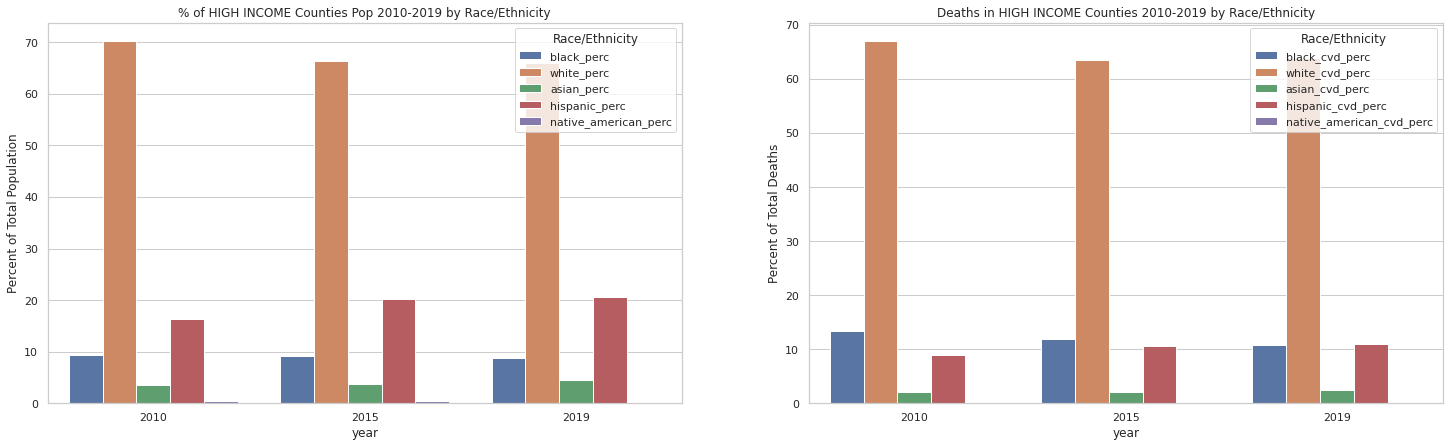

In [ ]:
plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
sns.barplot(data = county_a, x = 'year', y = 'Count Rate', hue = 'Race/Ethnicity')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Percent of Total Population')
plt.title('% of HIGH INCOME Counties Pop 2010-2019 by Race/Ethnicity')
plt.subplot(1,2,2)
sns.barplot(data = county_a_cvd, x = 'year', y = 'Deaths', hue = 'Race/Ethnicity')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Percent of Total Deaths')
plt.title('Deaths in HIGH INCOME Counties 2010-2019 by Race/Ethnicity')
plt.show()

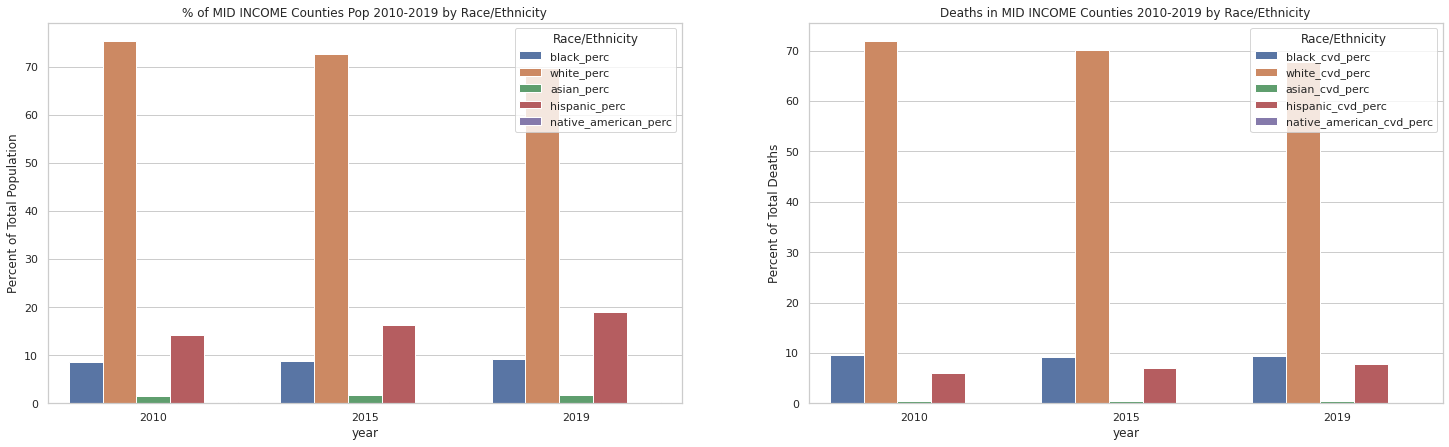

In [ ]:
plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
sns.barplot(data = county_b, x = 'year', y = 'Count Rate', hue = 'Race/Ethnicity')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Percent of Total Population')
plt.title('% of MID INCOME Counties Pop 2010-2019 by Race/Ethnicity')
plt.subplot(1,2,2)
sns.barplot(data = county_b_cvd, x = 'year', y = 'Deaths', hue = 'Race/Ethnicity')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Percent of Total Deaths')
plt.title('Deaths in MID INCOME Counties 2010-2019 by Race/Ethnicity')
plt.show()

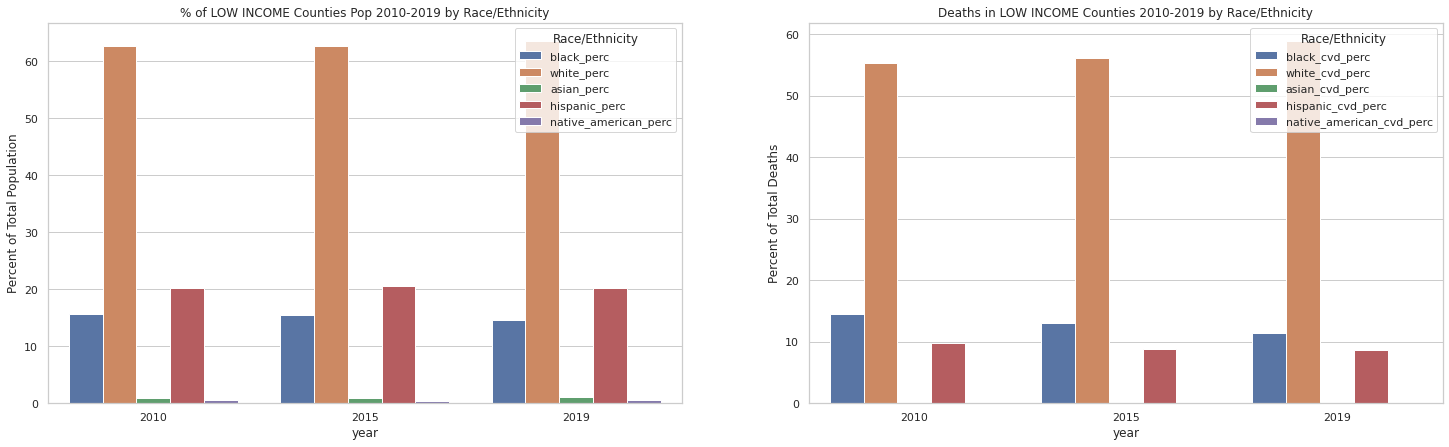

In [ ]:
plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
sns.barplot(data = county_c, x = 'year', y = 'Count Rate', hue = 'Race/Ethnicity')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Percent of Total Population')
plt.title('% of LOW INCOME Counties Pop 2010-2019 by Race/Ethnicity')
plt.subplot(1,2,2)
sns.barplot(data = county_c_cvd, x = 'year', y = 'Deaths', hue = 'Race/Ethnicity')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Percent of Total Deaths')
plt.title('Deaths in LOW INCOME Counties 2010-2019 by Race/Ethnicity')
plt.show()

#Comparing CVD Death RATES with Race

In [ ]:
df['black_cvd_perc'] = (df['Black CVD']/df['Deaths/100k']) * 100
df['white_cvd_perc'] = (df['White CVD']/df['Deaths/100k']) *100
df['asian_cvd_perc'] = (df['Asian CVD']/df['Deaths/100k']) *100
df['hispanic_cvd_perc'] = (df['Hispanic CVD']/df['Deaths/100k']) *100
df['native_american_cvd_perc'] = (df['Native American Alaska CVD']/df['Deaths/100k'])

In [ ]:
f2_race_perc = df.groupby(['year', 'counties'])['black_perc','white_perc','asian_perc', 'hispanic_perc', 'native_american_perc'].mean()
df2_race_cvd_perc = df.groupby(['year', 'counties'])['black_cvd_perc','white_cvd_perc','asian_cvd_perc', 'hispanic_cvd_perc', 'native_american_cvd_perc'].mean()

<ipython-input-222-0175dfca406e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  f2_race_perc = df.groupby(['year', 'counties'])['black_perc','white_perc','asian_perc', 'hispanic_perc', 'native_american_perc'].mean()
<ipython-input-222-0175dfca406e>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2_race_cvd_perc = df.groupby(['year', 'counties'])['black_cvd_perc','white_cvd_perc','asian_cvd_perc', 'hispanic_cvd_perc', 'native_american_cvd_perc'].mean()


In [ ]:
race_df = pd.melt(df2_race_perc.reset_index(), id_vars = ['year', 'counties'], value_vars = ['black_perc', 'white_perc', 'asian_perc', 'hispanic_perc',
       'native_american_perc'])
race_df = race_df.rename(columns = {'variable': 'Race/Ethnicity', 'value': 'Count Rate'})
race_cvd_df = pd.melt(df2_race_cvd_perc.reset_index(), id_vars = ['year', 'counties'], value_vars = ['black_cvd_perc', 'white_cvd_perc', 'asian_cvd_perc', 'hispanic_cvd_perc',
       'native_american_cvd_perc'])
race_cvd_df = race_cvd_df.rename(columns = {'variable': 'Race/Ethnicity', 'value': 'Death Rate'})

In [ ]:
county_a= race_df.loc[race_df['counties'] == 'high income counties']
county_a_cvd = race_cvd_df.loc[race_df['counties'] == 'high income counties']
county_b= race_df.loc[race_df['counties'] == 'mid-income counties']
county_b_cvd = race_cvd_df.loc[race_df['counties'] == 'mid-income counties']
county_c= race_df.loc[race_df['counties'] == 'low income counties']
county_c_cvd = race_cvd_df.loc[race_df['counties'] == 'low income counties']

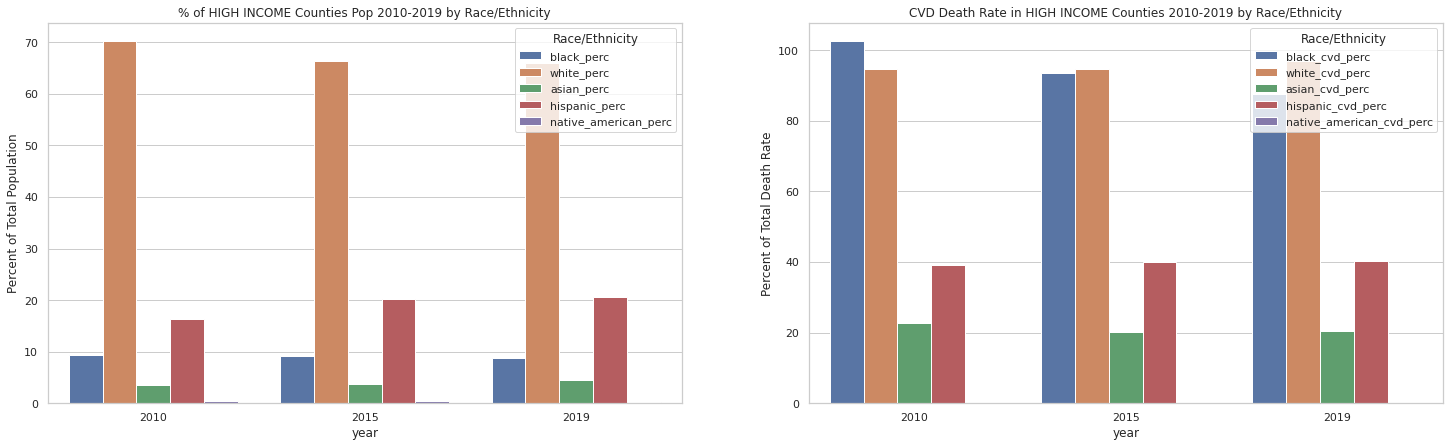

In [ ]:
plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
sns.barplot(data = county_a, x = 'year', y = 'Count Rate', hue = 'Race/Ethnicity')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Percent of Total Population')
plt.title('% of HIGH INCOME Counties Pop 2010-2019 by Race/Ethnicity')
plt.subplot(1,2,2)
sns.barplot(data = county_a_cvd, x = 'year', y = 'Death Rate', hue = 'Race/Ethnicity')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Percent of Total Death Rate')
plt.title('CVD Death Rate in HIGH INCOME Counties 2010-2019 by Race/Ethnicity')
plt.show()

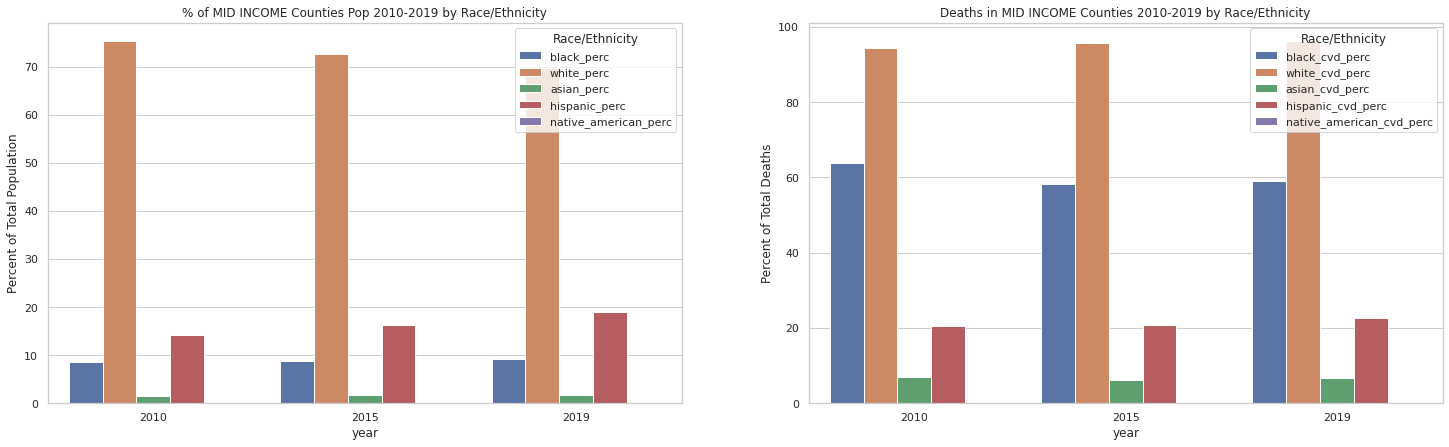

In [ ]:
plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
sns.barplot(data = county_b, x = 'year', y = 'Count Rate', hue = 'Race/Ethnicity')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Percent of Total Population')
plt.title('% of MID INCOME Counties Pop 2010-2019 by Race/Ethnicity')
plt.subplot(1,2,2)
sns.barplot(data = county_b_cvd, x = 'year', y = 'Death Rate', hue = 'Race/Ethnicity')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Percent of Total Deaths')
plt.title('Deaths in MID INCOME Counties 2010-2019 by Race/Ethnicity')
plt.show()

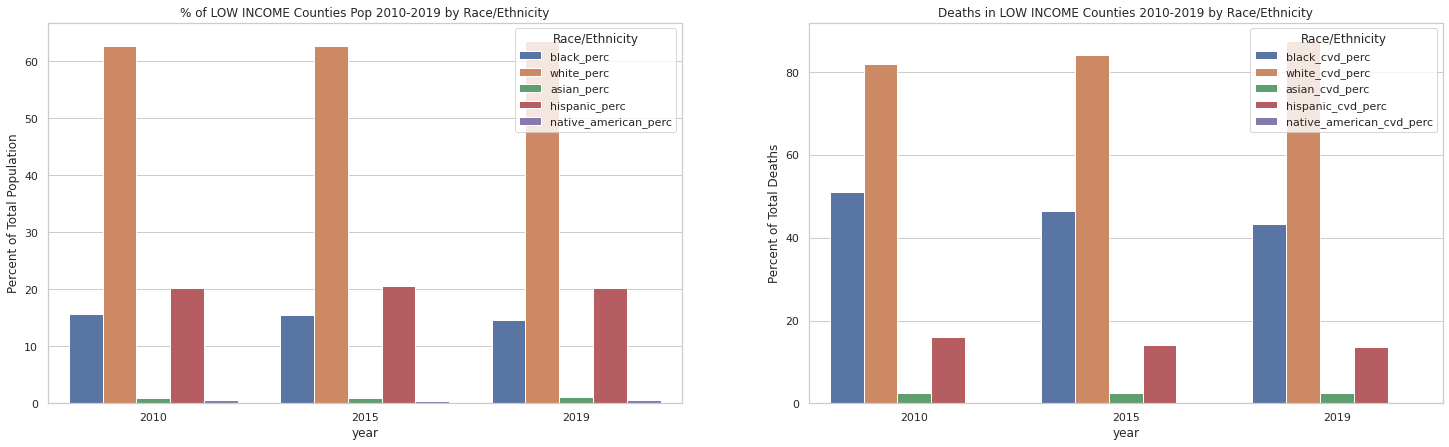

In [ ]:
plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
sns.barplot(data = county_c, x = 'year', y = 'Count Rate', hue = 'Race/Ethnicity')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Percent of Total Population')
plt.title('% of LOW INCOME Counties Pop 2010-2019 by Race/Ethnicity')
plt.subplot(1,2,2)
sns.barplot(data = county_c_cvd, x = 'year', y = 'Death Rate', hue = 'Race/Ethnicity')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Percent of Total Deaths')
plt.title('Deaths in LOW INCOME Counties 2010-2019 by Race/Ethnicity')
plt.show()

#Statistical Analysis

Looking at significance of Socioeconomic factors 
4 groups:
- income(median income and poverty)
- unemployment 
- education (less than hs, hs, some college, bach and higher) 
- neighborhood factors(medicaid, food access)

In [ ]:
stats_df = df[['median_income','poverty_percent_ages_18+','unemployment_rate','total_medicaid_enrollment',
               'Percent of adults with less than a high school diploma',
               'Percent of adults with a high school diploma only',
               'Percent of adults completing some college or associate degree',
               'Percent of adults with a bachelor degree or higher',
               'low_access_percent', 'low_income_low_access_percent',
               'Deaths/100k']]

In [ ]:
pg.ttest(stats_df['median_income'], stats_df['Deaths/100k'])


/usr/local/lib/python3.8/dist-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


T   dof alternative  p-val                CI95%   cohen-d  \
T-test  160.487057  4210   two-sided    0.0  [48819.6, 50027.12]  4.945678   

       BF10  power  
T-test  inf    1.0

In [ ]:
pg.ttest(stats_df['poverty_percent_ages_18+'], stats_df['Deaths/100k'])

/usr/local/lib/python3.8/dist-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


T   dof alternative  p-val               CI95%  cohen-d BF10  \
T-test -95.926319  4210   two-sided    0.0  [-141.58, -135.91]  2.95613  inf   

        power  
T-test    1.0

In [ ]:
pg.ttest(stats_df['unemployment_rate'], stats_df['Deaths/100k'])

/usr/local/lib/python3.8/dist-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


T   dof alternative  p-val               CI95%   cohen-d BF10  \
T-test -101.05818  4210   two-sided    0.0  [-148.82, -143.16]  3.114277  inf   

        power  
T-test    1.0

In [ ]:
pg.ttest(stats_df['total_medicaid_enrollment'], stats_df['Deaths/100k'])

T   dof alternative         p-val                CI95%  \
T-test  14.811124  4210   two-sided  2.016087e-48  [17792.45, 23221.4]   

        cohen-d       BF10  power  
T-test  0.45643  6.871e+44    1.0

In [ ]:
pg.ttest(stats_df['Percent of adults with less than a high school diploma'], stats_df['Deaths/100k'])

/usr/local/lib/python3.8/dist-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


T   dof alternative  p-val               CI95%   cohen-d BF10  \
T-test -93.214159  4210   two-sided    0.0  [-138.23, -132.54]  2.872551  inf   

        power  
T-test    1.0

In [ ]:
pg.ttest(stats_df['Percent of adults with a high school diploma only'], stats_df['Deaths/100k'])

/usr/local/lib/python3.8/dist-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


T   dof alternative  p-val               CI95%   cohen-d BF10  \
T-test -82.450058  4210   two-sided    0.0  [-122.43, -116.75]  2.540837  inf   

        power  
T-test    1.0

In [ ]:
pg.ttest(stats_df['Percent of adults completing some college or associate degree'], stats_df['Deaths/100k'])

/usr/local/lib/python3.8/dist-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


T   dof alternative  p-val               CI95%   cohen-d BF10  \
T-test -85.075501  4210   two-sided    0.0  [-125.96, -120.28]  2.621744  inf   

        power  
T-test    1.0

In [ ]:
pg.ttest(stats_df['Percent of adults with a bachelor degree or higher'], stats_df['Deaths/100k'])

/usr/local/lib/python3.8/dist-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


T   dof alternative  p-val               CI95%  cohen-d BF10  \
T-test -90.778762  4210   two-sided    0.0  [-135.09, -129.38]   2.7975  inf   

        power  
T-test    1.0

In [ ]:
pg.ttest(stats_df['low_access_percent'], stats_df['Deaths/100k'])

/usr/local/lib/python3.8/dist-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


T   dof alternative  p-val             CI95%   cohen-d BF10  \
T-test -59.951081  4210   two-sided    0.0  [-97.18, -91.03]  1.847493  inf   

        power  
T-test    1.0

In [ ]:
pg.ttest(stats_df['low_income_low_access_percent'], stats_df['Deaths/100k'])

/usr/local/lib/python3.8/dist-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


T   dof alternative  p-val               CI95%   cohen-d BF10  \
T-test -96.824023  4210   two-sided    0.0  [-144.58, -138.84]  2.983795  inf   

        power  
T-test    1.0

In [ ]:
df_final = df[[
    'fips',
 'state',
 'county',
 'year',
 'median_income',
 'counties',
 'poverty_estimate_all_ages',
 'poverty_percent_all_ages',
 'poverty_estimate_ages_18+',
 'poverty_percent_ages_18+',
 'labor_force',
 'employed',
 'unemployed',
 'unemployment_rate',
 'total_medicaid_enrollment',
 'Total Population',
 '35 to 64 years',
 '65 years and over',
 'White',
 'Black or African American',
 'American Indian and Alaska Native',
 'Asian and Pacific Islander',
 'Hispanic or Latino',
 'Less than a high school diploma',
 'Percent of adults with less than a high school diploma',
 'High school diploma only',
 'Percent of adults with a high school diploma only',
 'Some college or associate degree',
 'Percent of adults completing some college or associate degree',
 'Bachelor degree or higher',
 'Percent of adults with a bachelor degree or higher',
 'county_index',
 'low_access_percent',
 'low_income_low_access_percent',
 'American Indian and Alaska Native 35-64',
 'American Indian and Alaska Native 65+',
 'Asian and Pacific Islander 35-64',
 'Asian and Pacific Islander 65+',
 'Black 35-64',
 'Black 65+',
 'Hispanic 35-64',
 'Hispanic 65+',
 'Overall 35-64',
 'Overall 65+',
 'White 35-64',
 'White 65+',
 'Total Population_35+',
 'Percent 35-64',
 'Percent 65+',
 'Percent 35+',
 'total_cvd_deaths_crude',
 'income_change',
 'medicaid_rate',
 'total_pop_change',
 'unemployment_change',
 'medicaid_change',
 'poverty_change',
 'less_hs_diploma_change',
 'hs_diploma_change',
 'some_college_change',
 'bachelor_plus_change',
 'low_access_change',
 'low_income_low_access_change',
 'Deaths/100k',
 'total_cvd_change',
 'Hispanic CVD',
 'Black CVD',
 'White CVD',
 'Asian CVD',
 'Native American Alaska CVD',
 'black_cvd_perc',
 'white_cvd_perc',
 'asian_cvd_perc',
 'hispanic_cvd_perc',
 'native_american_cvd_perc',
 'black_perc',
 'white_perc',
 'asian_perc',
 'hispanic_perc',
 'native_american_perc'
]]

In [ ]:
#df_final.to_csv('/content/drive/MyDrive/Team 33 Capstone Project/Dataset with all counties/UPDATE_cvd_and_socioeconomic_factors_all_counties_2010-2019[CVD_adjusted].csv')

In [ ]:
pd.set_option('display.max_rows', None)
corrm = df_final.corr()
all_cor = corrm['Deaths/100k'] 
#corrm['price'][pos_cor].sort_values(ascending = False).to_frame()
all_cor.sort_values(ascending = False).to_frame()

Deaths/100k
Deaths/100k                                            1.000000
Overall 65+                                            0.906851
White CVD                                              0.875847
White 65+                                              0.792994
Overall 35-64                                          0.692678
White 35-64                                            0.632697
total_cvd_change                                       0.501510
medicaid_rate                                          0.416599
Black 35-64                                            0.351015
year                                                   0.301517
Black CVD                                              0.265578
income_change                                          0.224892
Hispanic 35-64                                         0.209560
Black 65+                                              0.199047
bachelor_plus_change                                   0.171492
black_perc                                             0.168681
poverty_percent_all_ages                               0.158078
poverty_percent_ages_18+                               0.149513
white_cvd_perc                                         0.144419
Percent of adults with a high school diploma only      0.141116
Percent 65+                                            0.130695
Hispanic CVD                                           0.129865
Percent of adults completing some college or as...     0.086528
Hispanic 65+                                           0.081054
low_income_low_access_percent                          0.079310
medicaid_change                                        0.056011
American Indian and Alaska Native 35-64                0.043597
Native American Alaska CVD                             0.041760
fips                                                   0.034660
total_cvd_deaths_crude                                 0.033956
low_income_low_access_change                           0.033333
American Indian and Alaska Native 65+                  0.032416
Asian and Pacific Islander 35-64                       0.026271
hs_diploma_change                                      0.025281
Percent of adults with less than a high school ...     0.025192
Asian and Pacific Islander 65+                         0.020253
American Indian and Alaska Native                      0.018613
Percent 35+                                            0.012641
native_american_cvd_perc                               0.008742
Asian CVD                                              0.004941
Less than a high school diploma                       -0.005248
poverty_estimate_all_ages                             -0.005840
Hispanic or Latino                                    -0.006100
Black or African American                             -0.006441
poverty_estimate_ages_18+                             -0.007095
total_medicaid_enrollment                             -0.011454
High school diploma only                              -0.018263
some_college_change                                   -0.018921
Asian and Pacific Islander                            -0.020203
65 years and over                                     -0.022905
Total Population                                      -0.026990
Some college or associate degree                      -0.027064
Total Population_35+                                  -0.029862
35 to 64 years                                        -0.031946
employed                                              -0.033243
labor_force                                           -0.033788
hispanic_perc                                         -0.034827
unemployed                                            -0.036535
asian_perc                                            -0.044239
Bachelor degree or higher                             -0.045370
black_cvd_perc                                        -0.054025
total_pop_change                                      -0.054796
White               

-0.23613135907883837


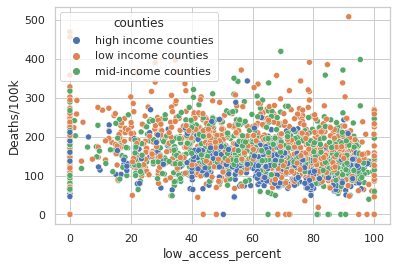

In [ ]:
print(df['low_access_percent'].corr(df['Deaths/100k']))
sns.scatterplot(data = df, x = 'low_access_percent', y = "Deaths/100k", hue = 'counties')

0.07930955507077703


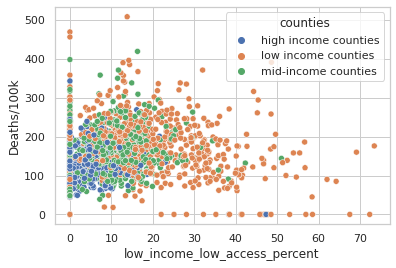

In [ ]:
print(df['low_income_low_access_percent'].corr(df['Deaths/100k']))
sns.scatterplot(data = df, x = 'low_income_low_access_percent', y = "Deaths/100k", hue = 'counties')

-0.3832515344841589


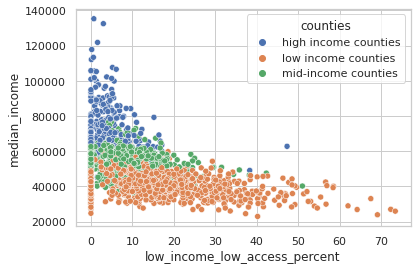

In [ ]:
print(df['low_income_low_access_percent'].corr(df['median_income']))
sns.scatterplot(data = df, x = 'low_income_low_access_percent', y = "median_income", hue = 'counties')

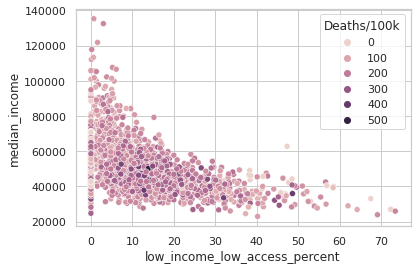

In [ ]:
sns.scatterplot(data = df, x = 'low_income_low_access_percent', y = "median_income", hue = 'Deaths/100k')

-0.14952593330761843


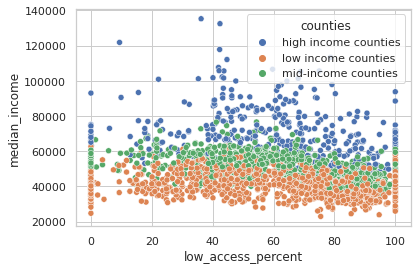

In [ ]:
print(df['low_access_percent'].corr(df['median_income']))
sns.scatterplot(data = df, x = 'low_access_percent', y = "median_income", hue = 'counties')

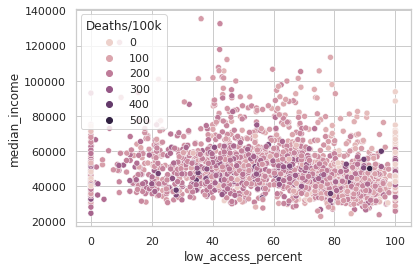

In [ ]:
sns.scatterplot(data = df, x = 'low_access_percent', y = "median_income", hue = 'Deaths/100k')